In [4]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [5]:
from __future__ import print_function
!pip install keract
!pip install utils
import os
from glob import glob

import keras
import keract
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten
from keras.models import Sequential
from keras.datasets import mnist


class MNIST:
    # input image dimensions
    img_rows, img_cols = 28, 28
    input_shape = (img_rows, img_cols, 1)
    num_classes = 10


    def get_mnist_data():
   
        (x_train, y_train), (x_test, y_test) = mnist.load_data()

        x_train = x_train.reshape(x_train.shape[0], MNIST.img_rows, MNIST.img_cols, 1)
        x_test = x_test.reshape(x_test.shape[0], MNIST.img_rows, MNIST.img_cols, 1)

        x_train = x_train.astype('float32')
        x_test = x_test.astype('float32')
        x_train /= 255
        x_test /= 255
        print('x_train shape:', x_train.shape)
        print(x_train.shape[0], 'train samples')
        print(x_test.shape[0], 'test samples')

        # convert class vectors to binary class matrices
        y_train = keras.utils.to_categorical(y_train, MNIST.num_classes)
        y_test = keras.utils.to_categorical(y_test, MNIST.num_classes)
        return x_train, y_train, x_test, y_test


x_train, y_train, x_test, y_test = MNIST.get_mnist_data()
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                         activation='relu',
                         input_shape=MNIST.input_shape))
        
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.35))
model.add(Dense(MNIST.num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])


model.fit(x_train, y_train,
          batch_size=64,
          validation_split=0.20,
          epochs=15,
          verbose=1,
          validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Using TensorFlow backend.


11493376/11490434 [==============================] - 0s 0us/step
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 151s 3ms/step - loss: 0.2442 - accuracy: 0.9251 - val_loss: 0.0623 - val_accuracy: 0.9810
Epoch 2/15
60000/60000 [==============================] - 150s 3ms/step - loss: 0.0932 - accuracy: 0.9729 - val_loss: 0.0405 - val_accuracy: 0.9871
Epoch 3/15
60000/60000 [==============================] - 152s 3ms/step - loss: 0.0733 - accuracy: 0.9789 - val_loss: 0.0348 - val_accuracy: 0.9874
Epoch 4/15
60000/60000 [==============================] - 152s 3ms/step - loss: 0.0623 - accuracy: 0.9824 - val_loss: 0.0375 - val_accuracy: 0.9871
Epoch 5/15
60000/60000 [==============================] - 151s 3ms/step - loss: 0.0562 - accuracy: 0.9837 - val_loss: 0.0313 - val_accura

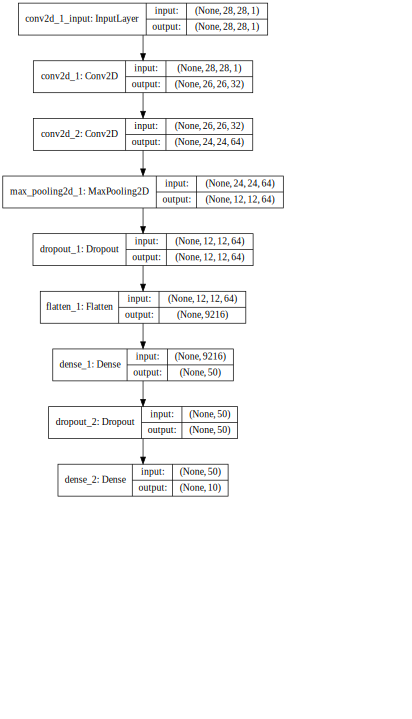

In [6]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True, 
                 show_layer_names=True, rankdir='TB',dpi=50).create(prog='dot', format='svg'))

In [7]:
image_index=1

import numpy as np

test_image =np.expand_dims(x_test[image_index], axis=0)
test_image.shape

model.predict_proba(test_image,batch_size=1)



array([[3.4124502e-11, 1.4817270e-10, 1.0000000e+00, 4.0638558e-11,
        1.5068487e-12, 6.5028630e-14, 1.1113911e-10, 1.3291383e-11,
        2.8251164e-11, 6.0983729e-14]], dtype=float32)

In [0]:
def get_activations(model, model_inputs, print_shape_only=True, layer_name=None):
    import keras.backend as K
    print('----- activations -----')
    activations = []
    inp = model.input

    model_multi_inputs_cond = True
    if not isinstance(inp, list):
        
        inp = [inp]
        model_multi_inputs_cond = False

    outputs = [layer.output for layer in model.layers if
               layer.name == layer_name or layer_name is None]  
    #print("the outputs of the layer is {}".format(outputs))
    funcs = [K.function(inp + [K.learning_phase()], [out]) for out in outputs]  

    if model_multi_inputs_cond:
        list_inputs = []
        list_inputs.extend(model_inputs)
        list_inputs.append(1.)
    else:
        list_inputs = [model_inputs, 1.]

    layer_outputs = [func([model_inputs, 1.])[0] for func in funcs]
    layer_outputs = [func(list_inputs)[0] for func in funcs]
    for layer_activations in layer_outputs:
        activations.append(layer_activations)
        if print_shape_only:
            print(layer_activations.shape)
        else:
            print(layer_activations)
    return activations

In [0]:
def display_activations(activation_maps):
    import numpy as np
    import matplotlib.pyplot as plt
    import openpyxl
    from openpyxl import Workbook,load_workbook

 
    batch_size = activation_maps[0].shape[0]
    assert batch_size == 1, 'One image at a time to visualize.'
    for i, activation_map in enumerate(activation_maps):
        print('Displaying activation map {}'.format(i))
        shape = activation_map.shape
        if len(shape) == 4:
            activations = np.hstack(np.transpose(activation_map[0], (2, 0, 1)))
            #print("The activations for the layer is {}".format(activations))
        elif len(shape) == 2:
            # try to make it square as much as possible. we can skip some activations.
            activations = activation_map[0]
            if i==6:
              path='/gdrive//My Drive//results_MNIST_50.xlsx'
              wb = load_workbook(path)
              wb.get_sheet_names()
              ws=wb.active
              row=0
              column=0
              max = ws.max_row
              maxc =ws.max_column
              for row, entry in enumerate(activations,start=1):
                ws.cell(row=row+max, column=column+maxc, value=entry)
              
              wb.save(path)
            print("The activations for the layer is {}".format(activations))
            num_activations = len(activations)
            if num_activations > 1024:  # too hard to display it on the screen.
                square_param = int(np.floor(np.sqrt(num_activations)))
                activations = activations[0: square_param * square_param]
                activations = np.reshape(activations, (square_param, square_param))
            else:
                activations = np.expand_dims(activations, axis=0)
        else:
            raise Exception('len(shape) = 3 has not been implemented.')
        

        fig, ax = plt.subplots(figsize=(18, 12))
        ax.imshow(activations, interpolation='None', cmap='binary')
        plt.show()       

In [0]:
def img_samenum(x_test,y_test,number):

  """
  retrieve images of same digit and reshape
  """

  x_test_2=[x_test[y_test==number]]

  x_test_2array=np.array(x_test_2[0],dtype='float')
  print(x_test_2array.shape)

  x_test_img=x_test_2array.reshape(x_test_2array.shape[0],28,28,1)
  print(x_test_img.shape)
  return x_test_img


In [0]:
import numpy as np
def test_image(test_input,image_index):
  """
  pass the image to predict the probilities and get the final shape
  """

  image =np.expand_dims(test_input[image_index], axis=0)
  #print(test_image.shape)

  print(model.predict_proba(image,batch_size=1))
  print(image.shape)
  activations_0=get_activations(model,image)
  display_activations(activations_0)

In [12]:
#loading fresh test dataset from MNIST

(x_train_filter, y_train_filter), (x_test_filter, y_test_filter) = mnist.load_data()

x_test_filter.shape[0]

10000

In [13]:
#retrieveing images for num 0

x_test_img=img_samenum(x_test_filter,y_test_filter,0)

(980, 28, 28)
(980, 28, 28, 1)


[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
(1, 28, 28, 1)
----- activations -----
(1, 26, 26, 32)
(1, 24, 24, 64)
(1, 12, 12, 64)
(1, 12, 12, 64)
(1, 9216)
(1, 50)
(1, 50)
(1, 10)
Displaying activation map 0


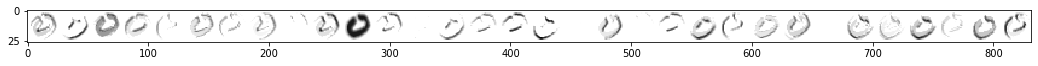

Displaying activation map 1


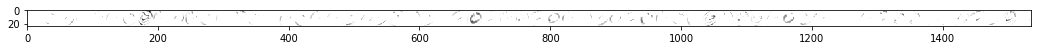

Displaying activation map 2


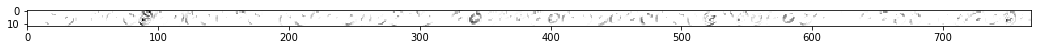

Displaying activation map 3


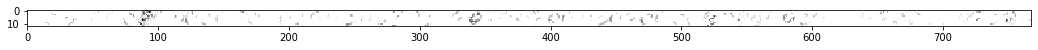

Displaying activation map 4
The activations for the layer is [0. 0. 0. ... 0. 0. 0.]


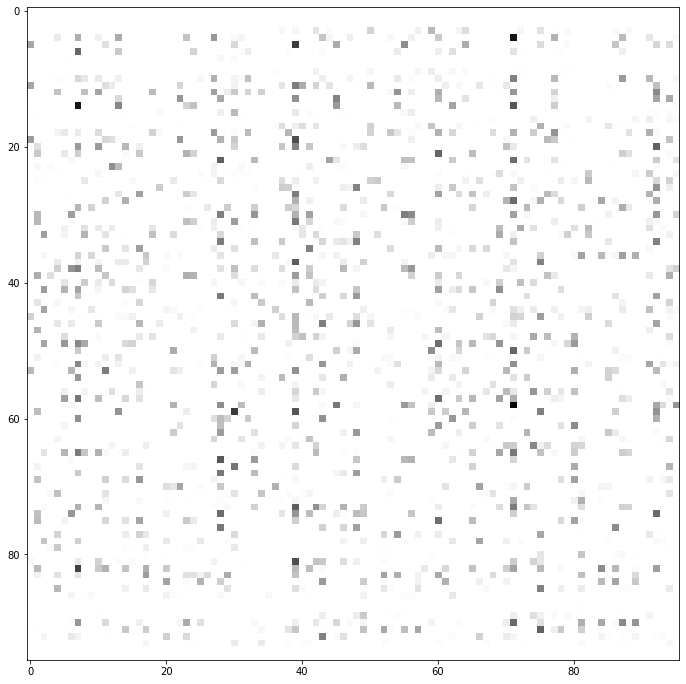

Displaying activation map 5
The activations for the layer is [2167.7717  1045.2947     0.         0.      1056.7574  1566.0197
    0.      2472.4827   393.8674  3049.274   4251.1567  2827.4397
 3190.7598     0.       526.44586 1124.1039  1202.6703  2080.663
 1782.5785  3020.6277  2408.0156  2315.6682  1142.8342    99.12052
  727.8427   483.51672  465.0235     0.       487.70364 2849.062
 1036.9861  1179.401   1527.6025   317.6314   325.11664 2525.041
  678.49963 2635.1567   882.03937 3458.3015  1727.988   3275.0852
 3341.486      0.      1079.7533  1573.9176   115.58711  478.6631
 3256.746    456.52246]


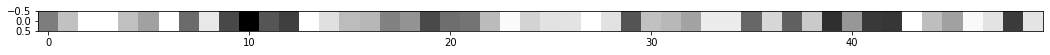

Displaying activation map 6


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).


The activations for the layer is [   0.         0.         0.         0.         0.      2393.6514
    0.      3870.0815   751.3508  4967.424      0.      4380.1357
 4902.0225     0.       859.21173    0.      1694.8663     0.
    0.      4271.499   3386.5017  3789.5835  1386.2505   280.4311
    0.       866.7105   828.87286  354.03915    0.         0.
    0.      1787.0787  2002.8662   641.79785  771.3943  3638.36
  602.43854    0.         0.      5181.73    2757.5967  4702.796
 4527.9277     0.      1212.3184  2516.3013   116.83596  306.80405
 4845.8457  1004.69916]


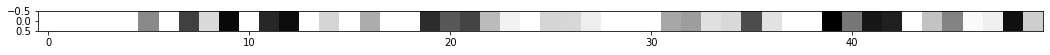

Displaying activation map 7
The activations for the layer is [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


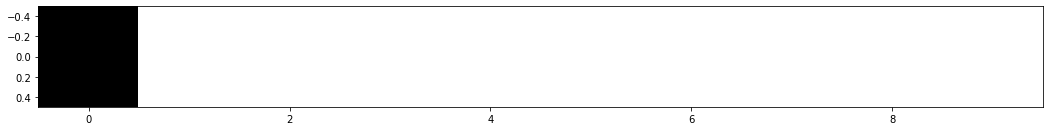

In [14]:
#first image of 0

test_image(x_test_img,3)

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
(1, 28, 28, 1)
----- activations -----
(1, 26, 26, 32)
(1, 24, 24, 64)
(1, 12, 12, 64)
(1, 12, 12, 64)
(1, 9216)
(1, 50)
(1, 50)
(1, 10)
Displaying activation map 0


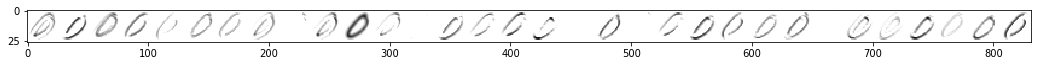

Displaying activation map 1


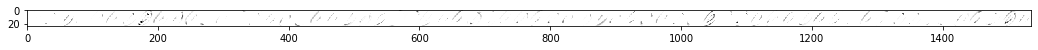

Displaying activation map 2


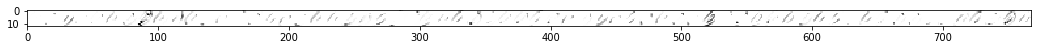

Displaying activation map 3


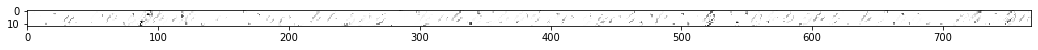

Displaying activation map 4
The activations for the layer is [0. 0. 0. ... 0. 0. 0.]


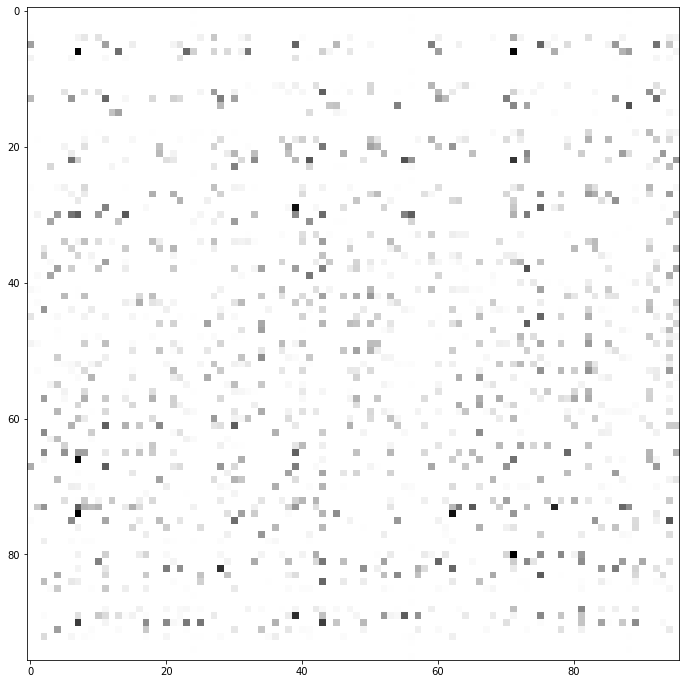

Displaying activation map 5
The activations for the layer is [1985.834    248.66513    0.         0.       301.92978  934.3339
   78.74524 1507.487    523.17194 2041.2869  3331.4363  2986.094
 3019.5957     0.       487.36218  652.67725  282.1018  2206.6519
 1216.7994  2563.5383  2875.916   1607.8741   788.9019    28.13959
  576.90515 1119.4143   961.29614  459.46704  934.62604 2680.5322
  690.31104 1567.1254   782.9541   300.93915  274.24695 2365.9788
  734.32245 2384.763    133.75699 2817.107   1149.0428  2699.6448
 2853.971      0.       496.98404 2275.5127     0.       255.30945
 2079.2715  1124.1364 ]


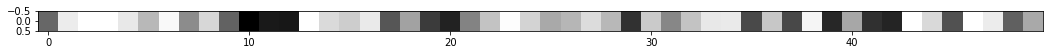

Displaying activation map 6
The activations for the layer is [3211.245      0.         0.         0.       292.60352 1665.424
   16.45345 1961.4412   614.82855 3246.6843     0.      4811.0244
 4686.3022     0.         0.         0.       526.05066 3282.0298
 1939.5741     0.      4650.145   2483.6206  1249.1046     0.
    0.      1442.6111  1083.579      0.      1597.9799  4300.9365
  941.33746 2721.05    1413.026    295.85498  291.1043     0.
 1408.6718  3557.2378   380.69168    0.      2068.9094     0.
 4704.6978     0.       917.21643 3323.6099     0.       692.91547
 3219.5562     0.     ]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).


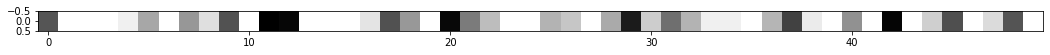

Displaying activation map 7
The activations for the layer is [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


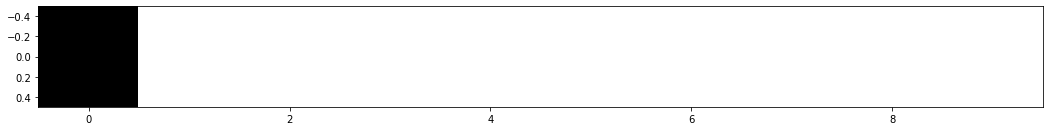

In [15]:
#second image of zero

test_image(x_test_img,15)

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
(1, 28, 28, 1)
----- activations -----
(1, 26, 26, 32)
(1, 24, 24, 64)
(1, 12, 12, 64)
(1, 12, 12, 64)
(1, 9216)
(1, 50)
(1, 50)
(1, 10)
Displaying activation map 0


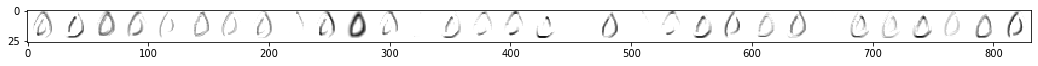

Displaying activation map 1


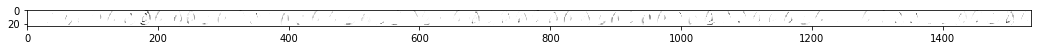

Displaying activation map 2


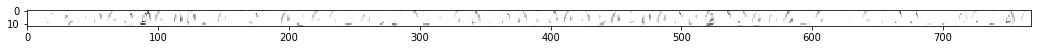

Displaying activation map 3


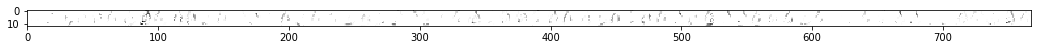

Displaying activation map 4
The activations for the layer is [0. 0. 0. ... 0. 0. 0.]


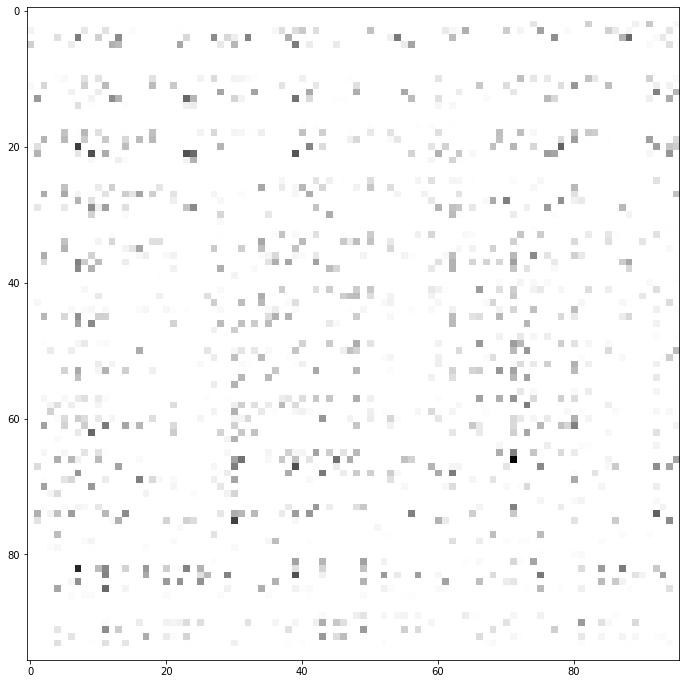

Displaying activation map 5
The activations for the layer is [2282.853   1208.3127     0.       315.60532  222.4812  1405.8988
    0.      2696.1042   343.3131  3448.1692  4292.821   2967.5823
 3168.7727     0.       309.71066  903.4865   944.54297 2662.5054
 1116.2915  2337.7317  2134.1396  2316.1948  1703.682    569.818
 1359.4088  1512.9838   346.61554 1452.0554  1054.2927  3154.9543
 1135.6763  1304.355   1122.9578  1127.2255     0.      2281.0825
 1113.3683  2936.8848   514.8688  3145.6216  1508.4172  2941.086
 2723.778      0.       809.5368  2399.7532   383.0218     0.
 3073.0247  1317.157  ]


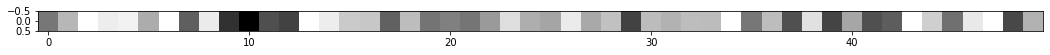

Displaying activation map 6
The activations for the layer is [   0.         0.         0.       128.26804  235.69447 2038.5668
    0.         0.       379.10385 5081.8994  6490.9565     0.
    0.         0.       514.3452     0.      1519.31       0.
    0.         0.      3247.8438     0.         0.         0.
    0.      2251.8496     0.      2238.84    1770.7463  4647.2686
    0.         0.      1773.2628  1654.6512     0.      3540.3828
 1937.9592     0.       703.9438  4791.007   2081.3645  4590.4683
 4052.6929     0.      1359.6635     0.         0.         0.
    0.      1959.7683 ]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).


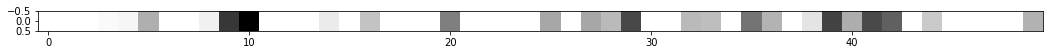

Displaying activation map 7
The activations for the layer is [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


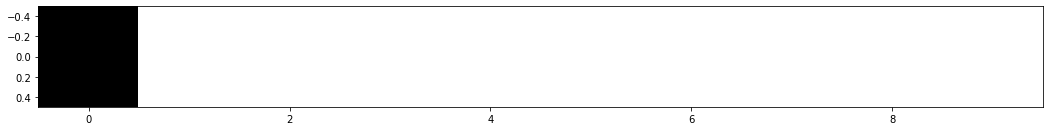

In [16]:
#third image of 0

test_image(x_test_img,555)

In [17]:
#retrieveing images for num 1

x_test_img_1=img_samenum(x_test_filter,y_test_filter,1)

(1135, 28, 28)
(1135, 28, 28, 1)


[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
(1, 28, 28, 1)
----- activations -----
(1, 26, 26, 32)
(1, 24, 24, 64)
(1, 12, 12, 64)
(1, 12, 12, 64)
(1, 9216)
(1, 50)
(1, 50)
(1, 10)
Displaying activation map 0


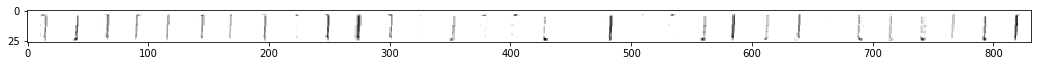

Displaying activation map 1


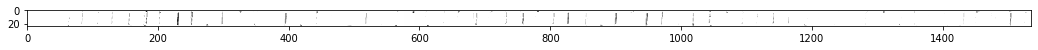

Displaying activation map 2


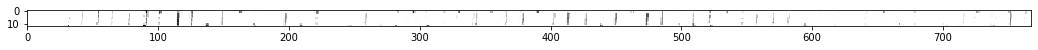

Displaying activation map 3


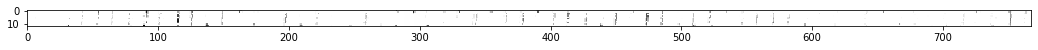

Displaying activation map 4
The activations for the layer is [0. 0. 0. ... 0. 0. 0.]


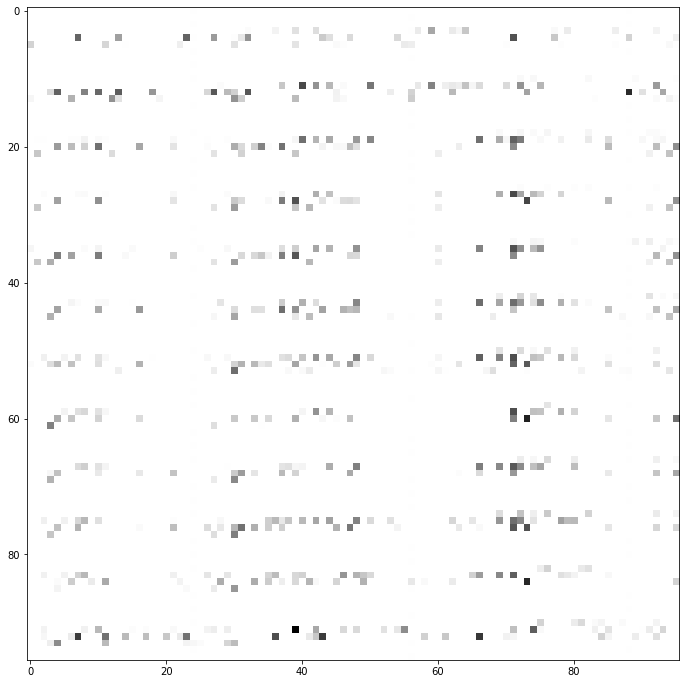

Displaying activation map 5
The activations for the layer is [1646.6165    540.99744  1747.7046    428.38248  2368.0977   1144.59
 1305.6969   2210.5115   2020.6921    270.31784  1001.01654  2094.7002
 1369.1139   1595.6123   1023.79535  1902.8607    914.4573   1068.2892
 1071.6514   1219.5759    458.27542  1374.2056    631.33966   420.08096
 2001.0712   2369.144    1531.9813   2590.1272   1900.4705   1601.1603
 1944.4629   1935.2825    614.80505  2154.5308   2008.3314   1322.7178
  931.96936    19.365454  208.0025    605.1497    945.7384   1278.474
 1326.9602    911.9781   1270.5238   2223.6382    854.3947   1188.9745
 2318.9924   1961.0759  ]


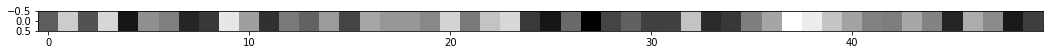

Displaying activation map 6
The activations for the layer is [   0.        580.8477   2631.0215    507.45532  3501.3687      0.
 1920.9973   2955.8528   2967.7344    321.95032     0.          0.
 2105.0413   2148.7632   1616.8899   2466.7815      0.       1683.6206
 1709.4043   1929.2793    858.03345  2067.813     753.8942    708.36896
 2875.4949   3518.4324   2153.185       0.       2794.2764      0.
 2845.721    2876.2327   1172.3539      0.          0.       1705.0349
 1335.123      10.613649  300.25443   676.9677      0.       2079.6726
 2221.2917   1440.3782   1885.7505   3046.383       0.       1901.2468
 3176.079    2821.3894  ]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).


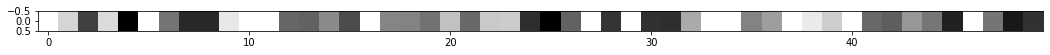

Displaying activation map 7
The activations for the layer is [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


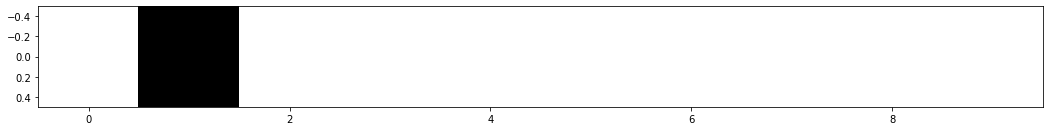

In [18]:
#first image of 1

test_image(x_test_img_1,23)

[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
(1, 28, 28, 1)
----- activations -----
(1, 26, 26, 32)
(1, 24, 24, 64)
(1, 12, 12, 64)
(1, 12, 12, 64)
(1, 9216)
(1, 50)
(1, 50)
(1, 10)
Displaying activation map 0


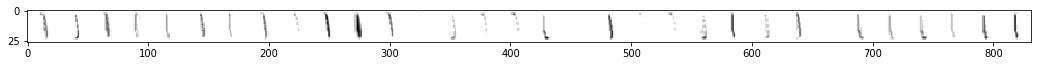

Displaying activation map 1


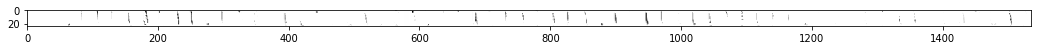

Displaying activation map 2


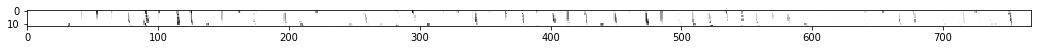

Displaying activation map 3


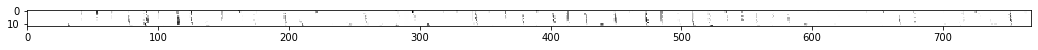

Displaying activation map 4
The activations for the layer is [0. 0. 0. ... 0. 0. 0.]


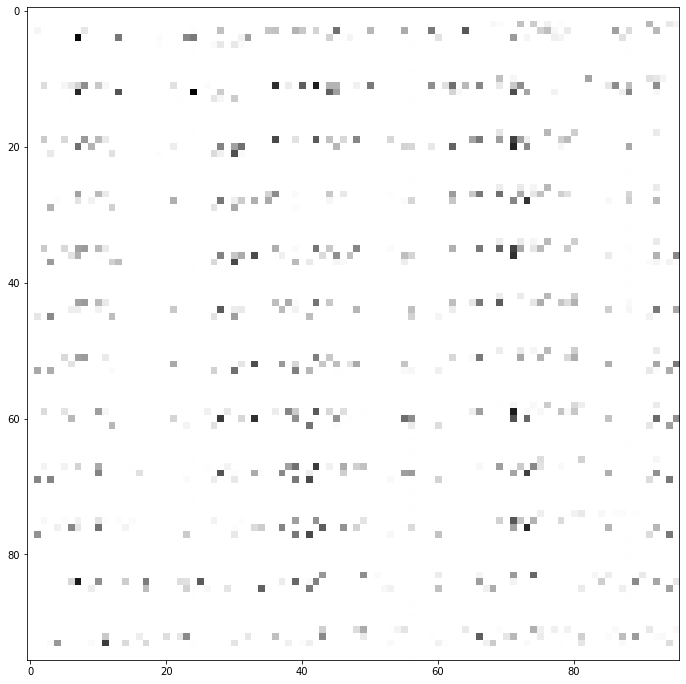

Displaying activation map 5
The activations for the layer is [1527.2136   484.06567 2044.6044  1003.72906 2693.4832  1628.7657
 1401.6211  1918.1646  1506.4143   276.14273  539.91864 1877.9255
  972.739   1554.1627   753.9449  2104.0361  1470.6481  1466.894
 1396.8002  1478.2955   975.2587  1310.8256  1057.4686   671.89197
 1540.8116  2052.6238   812.1488  2490.785   2345.8962   742.6552
 1901.6708  2227.5793   940.47974 2175.119   1656.7874   980.4698
 1318.6683     0.         0.       253.91359 1218.7694  1805.2379
 1137.5948   515.534   1335.9772  2513.2869   963.068   1075.7402
 2283.1724  1954.9506 ]


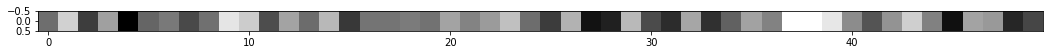

Displaying activation map 6
The activations for the layer is [   0.        957.6376   2887.4438   1415.5857      0.       2408.585
 2117.255    3212.2285   2153.795     519.5288      0.          0.
 1359.799    2379.3765    932.1671   3230.5295      0.       1833.2537
    0.       2028.0598   1406.1505   1799.571    1487.3282      0.
    0.       2637.5051    791.1963   3662.9827   3089.7463   1148.9241
 2854.3093   3065.9363   1058.3839   3304.0562   2298.877    1605.7616
 1921.9332      0.         46.286575    0.          0.          0.
    0.          0.          0.       4017.1042   1315.0105      0.
 3516.5493   2813.4827  ]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).


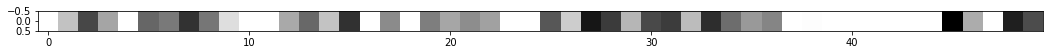

Displaying activation map 7
The activations for the layer is [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


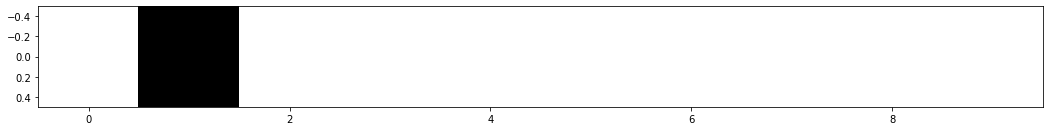

In [19]:
#second image of 1

test_image(x_test_img_1,456)

[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
(1, 28, 28, 1)
----- activations -----
(1, 26, 26, 32)
(1, 24, 24, 64)
(1, 12, 12, 64)
(1, 12, 12, 64)
(1, 9216)
(1, 50)
(1, 50)
(1, 10)
Displaying activation map 0


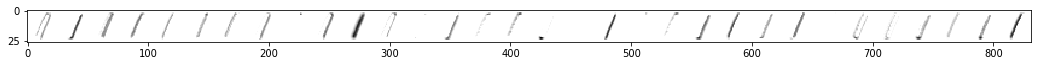

Displaying activation map 1


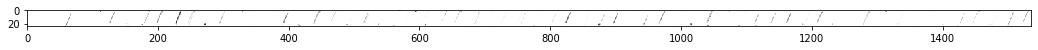

Displaying activation map 2


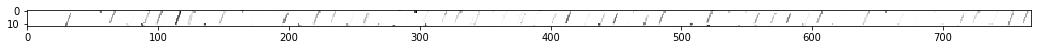

Displaying activation map 3


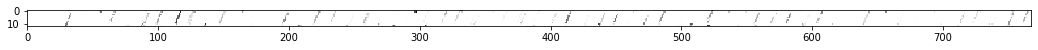

Displaying activation map 4
The activations for the layer is [0. 0. 0. ... 0. 0. 0.]


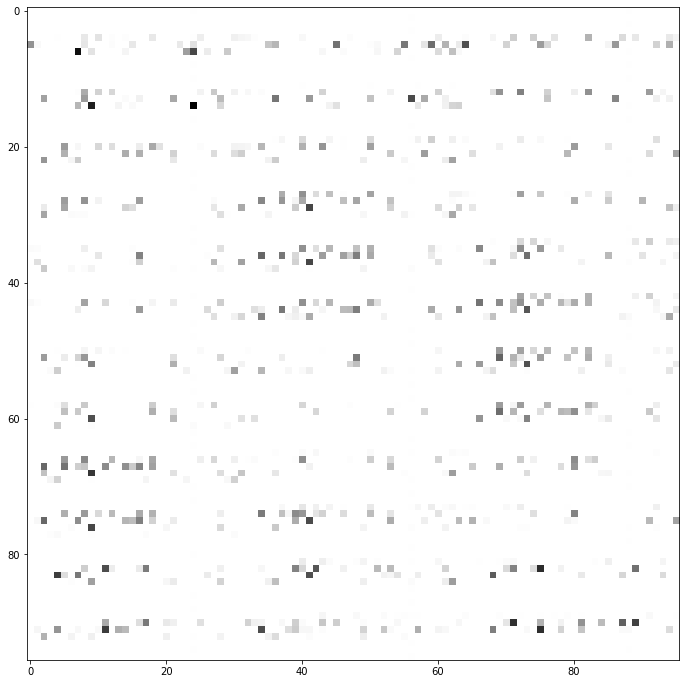

Displaying activation map 5
The activations for the layer is [1887.8756   625.36945 1644.4      486.06445 2046.0472  1558.72
 1497.543   2678.5122  1978.2444  1155.9769  1280.9105  1796.7854
  843.3956   838.66254  797.0112  2166.3748  1024.8043   807.9965
 1198.3297  1025.1252   566.43    1297.4491   907.72784  572.82947
 1930.7683  2147.4524  1517.5519  2273.2207  1652.5573  2289.711
 1661.1874  2047.5376   712.56964 2017.0773  1595.8049  1937.5374
 1166.093    623.98596  134.97282  656.1939   896.10266 1331.9965
  828.1586   503.2774  1181.9656  2222.7915   747.7648   740.4855
 1963.6965  1979.2693 ]


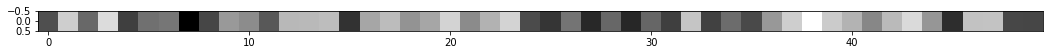

Displaying activation map 6
The activations for the layer is [   0.      1002.4481  2658.8672   429.73474 3160.0361  2429.3442
    0.      3877.029   2994.5305  1484.5948     0.      2707.1985
    0.      1395.8397  1256.537      0.      1618.0757   852.3356
 1687.1163  1435.2341  1051.0493  1957.5645  1349.5118     0.
    0.      2911.9092  2103.6475     0.         0.      3506.7703
    0.         0.       950.70374 3049.9114  2468.7852     0.
    0.       797.20636  242.36562  922.797      0.         0.
 1240.2725   653.61084 1779.6085  3413.6467   861.7344     0.
 2934.5466  2787.2275 ]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).


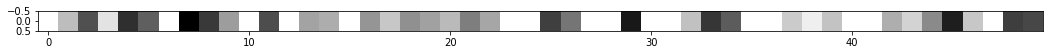

Displaying activation map 7
The activations for the layer is [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


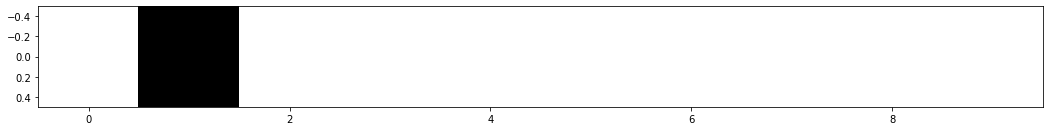

In [20]:
#third image of 1

test_image(x_test_img_1,1100)

In [21]:
#retrieveing images for num 2

x_test_img_2=img_samenum(x_test_filter,y_test_filter,2)

(1032, 28, 28)
(1032, 28, 28, 1)


[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]
(1, 28, 28, 1)
----- activations -----
(1, 26, 26, 32)
(1, 24, 24, 64)
(1, 12, 12, 64)
(1, 12, 12, 64)
(1, 9216)
(1, 50)
(1, 50)
(1, 10)
Displaying activation map 0


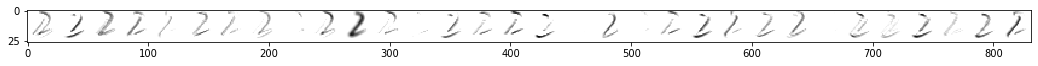

Displaying activation map 1


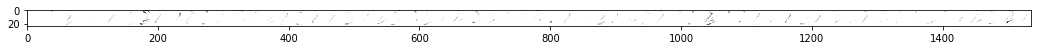

Displaying activation map 2


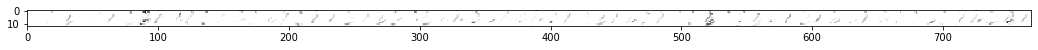

Displaying activation map 3


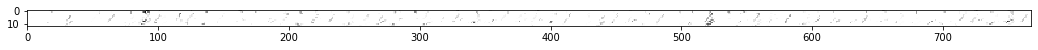

Displaying activation map 4
The activations for the layer is [0. 0. 0. ... 0. 0. 0.]


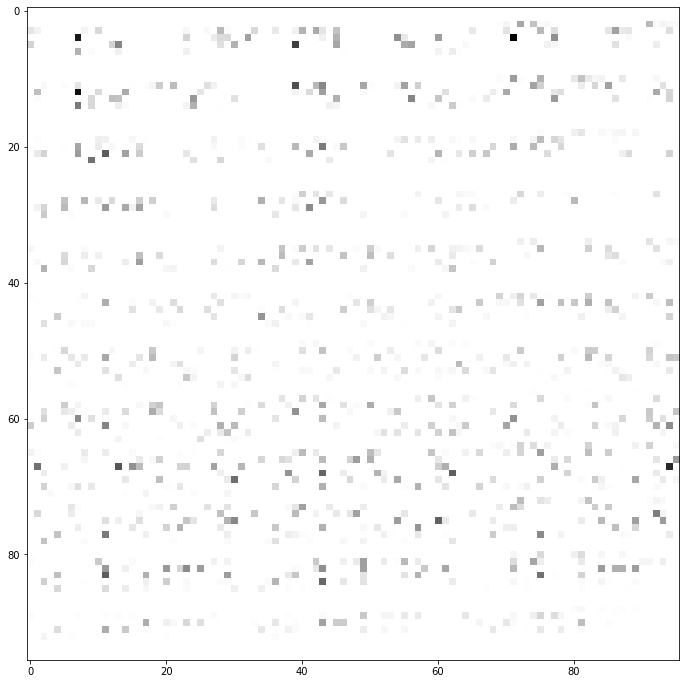

Displaying activation map 5
The activations for the layer is [1515.4486     0.       613.3121   915.6672   890.06744 1416.1093
  948.47455 1089.5829   214.68315 2231.1206  2763.061   2310.5637
 1923.396      0.         0.      1102.9888  1360.2245  2858.5881
 1253.678   1311.1334  1029.7251  1142.4957  2093.5542   839.79504
 1904.158   2584.3057   232.16162 2107.9236  3245.02    1447.1525
 1818.9791  3158.0813  1486.8744  1924.6041   186.82191 1518.2933
  869.00256 1841.0562     0.       687.74243 2630.0159  3168.1597
 2260.2273     0.       574.6459   839.0396   712.40155  469.71097
  588.4414  2983.703  ]


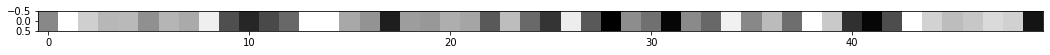

Displaying activation map 6
The activations for the layer is [1947.4591     0.       678.94385 1219.7803  1379.1033  2216.6577
 1538.6261  1385.2852     0.      3084.2026     0.         0.
 2399.4749     0.         0.      1643.7947  1856.3215  4381.271
    0.      1838.883   1630.0079  1348.9844  2933.4546     0.
 2901.2634  3825.0112   417.8009  2946.306      0.      2111.3677
    0.      4795.7383  2349.2922  2860.7957   152.607   1941.9064
    0.      2542.9854     0.       547.7912  3643.8782  4823.7104
    0.         0.       637.7809   996.21375 1091.3813   546.19507
  619.672      0.     ]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).


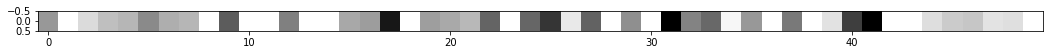

Displaying activation map 7
The activations for the layer is [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


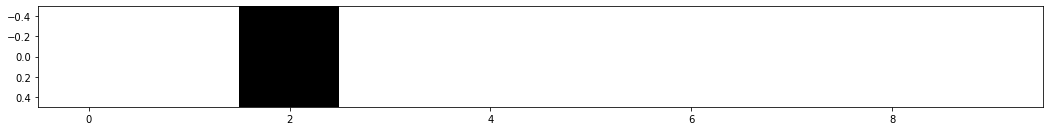

In [22]:
#test image for 2

test_image(x_test_img_2,334)

[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]
(1, 28, 28, 1)
----- activations -----
(1, 26, 26, 32)
(1, 24, 24, 64)
(1, 12, 12, 64)
(1, 12, 12, 64)
(1, 9216)
(1, 50)
(1, 50)
(1, 10)
Displaying activation map 0


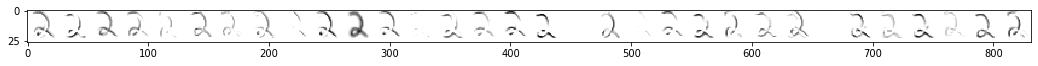

Displaying activation map 1


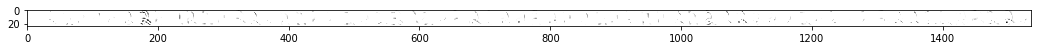

Displaying activation map 2


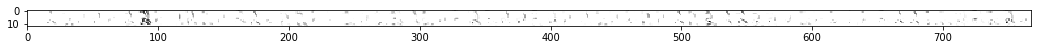

Displaying activation map 3


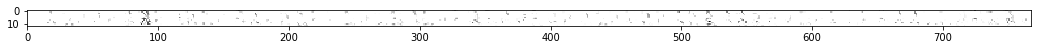

Displaying activation map 4
The activations for the layer is [0. 0. 0. ... 0. 0. 0.]


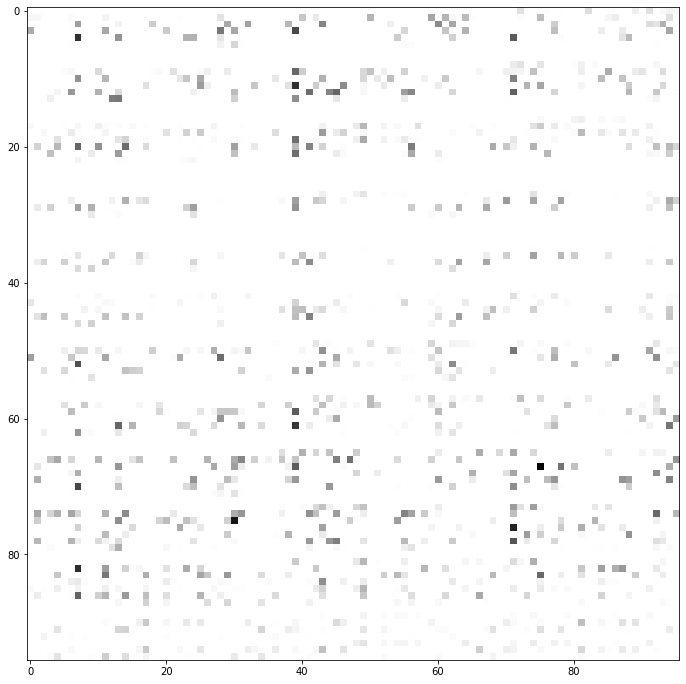

Displaying activation map 5
The activations for the layer is [   0.         0.       330.843    233.7721   504.49448  655.5269
   63.65405  607.799      0.      2767.1655  3546.7695  2944.5864
 2624.5012     0.       112.22678  223.32458  446.3619  3885.6035
  896.92865 1089.6912   554.9911  2810.2444  2940.5786   274.50586
 2581.3684  3094.197      0.      3174.1191  4125.3145   434.27792
 2770.079   3217.4773   984.7692  2340.5916     0.       447.50836
  787.94666 2881.4373     0.       424.64813 3229.5002  3332.226
 3404.2148     0.       668.8472   574.8384   636.06866  246.66841
    0.      3143.315  ]


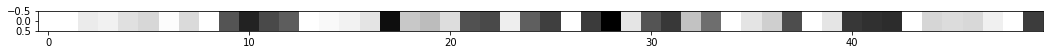

Displaying activation map 6
The activations for the layer is [   0.         0.        84.47362  512.0991   850.3011     0.
    0.       964.7833     0.         0.         0.         0.
    0.         0.        55.91723    0.       749.3071     0.
  733.5662  1718.0297     0.         0.      4653.4375   714.022
 3650.995   4714.4497     0.      4724.4785  5941.2334     0.
 4111.0864     0.      1503.0785  3498.2168     0.       328.11163
    0.      4155.436      0.       279.0809     0.         0.
 4941.391      0.      1095.5673     0.      1011.13074    0.
    0.         0.     ]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).


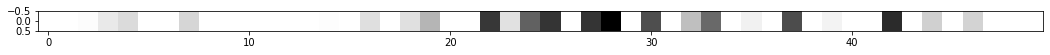

Displaying activation map 7
The activations for the layer is [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


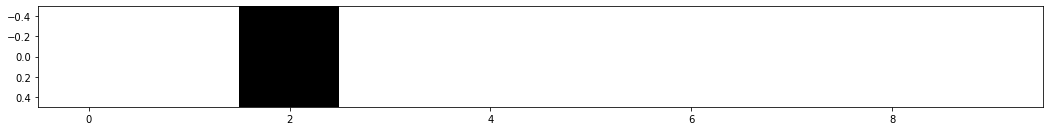

In [23]:
#test image for 2

test_image(x_test_img_2,111)

[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]
(1, 28, 28, 1)
----- activations -----
(1, 26, 26, 32)
(1, 24, 24, 64)
(1, 12, 12, 64)
(1, 12, 12, 64)
(1, 9216)
(1, 50)
(1, 50)
(1, 10)
Displaying activation map 0


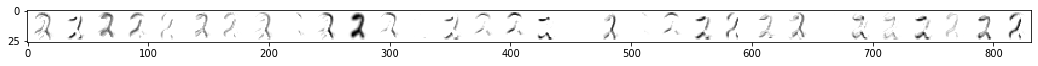

Displaying activation map 1


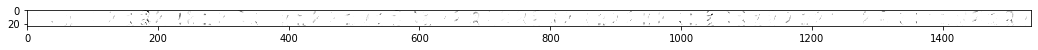

Displaying activation map 2


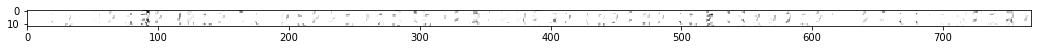

Displaying activation map 3


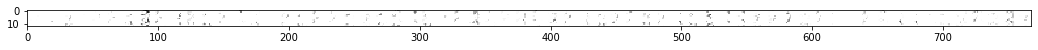

Displaying activation map 4
The activations for the layer is [0. 0. 0. ... 0. 0. 0.]


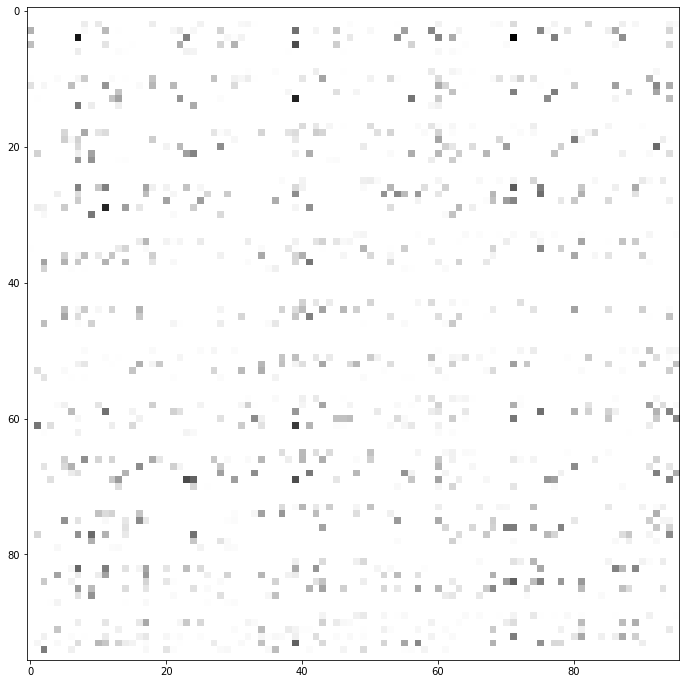

Displaying activation map 5
The activations for the layer is [   0.       548.5956   428.79803  710.7278   928.37286  736.569
  198.4403  1401.928    851.3182  1821.6217  2882.1296  2555.5537
 2018.1592     0.       759.4094   857.5977   888.85944 3241.4963
  955.17566 1190.92     314.6341  2383.123   1332.8373   770.328
 1929.4991  2701.6653   466.2278  2865.9922  3533.8862   661.16815
 2817.9446  2787.54     974.4539  2112.4646   530.84186  202.61278
  469.5837  2345.876      0.       788.1757  2382.6313  2679.136
 2169.346    565.426    331.01556  368.49026 1321.093    513.9922
  468.22406 2736.0278 ]


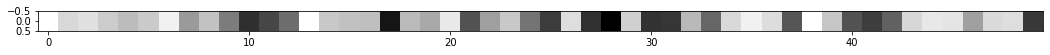

Displaying activation map 6
The activations for the layer is [   0.      1071.65       0.         0.      1833.3531  1206.0503
  207.18222 2127.8547     0.      2835.4583  4578.165   4187.723
 3200.0332     0.      1237.3052  1614.3121     0.      4997.985
 1447.4314  1679.3049     0.      3883.0461     0.      1447.821
    0.         0.       720.40985 4938.6475     0.      1105.7278
    0.      4422.5454  1150.7463  3514.5388   869.3363     0.
    0.      3744.7395     0.         0.      3947.576   4125.555
 3467.484    887.7492   548.2704   777.477   1830.41     825.29346
  628.1256  4525.233  ]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).


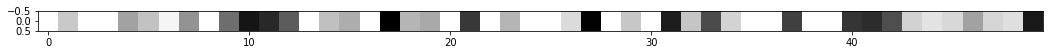

Displaying activation map 7
The activations for the layer is [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


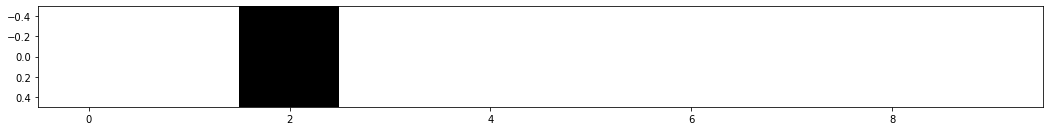

In [24]:
#test image for 2

test_image(x_test_img_2,767)

In [25]:
#retrieveing images for num 3

x_test_img_3=img_samenum(x_test_filter,y_test_filter,3)

(1010, 28, 28)
(1010, 28, 28, 1)


[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]
(1, 28, 28, 1)
----- activations -----
(1, 26, 26, 32)
(1, 24, 24, 64)
(1, 12, 12, 64)
(1, 12, 12, 64)
(1, 9216)
(1, 50)
(1, 50)
(1, 10)
Displaying activation map 0


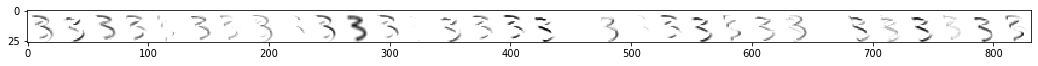

Displaying activation map 1


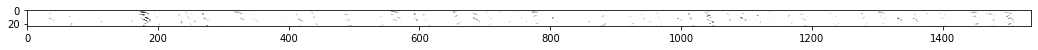

Displaying activation map 2


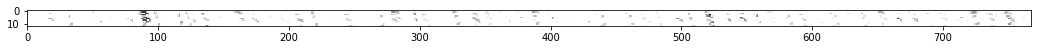

Displaying activation map 3


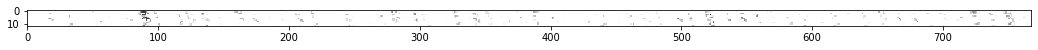

Displaying activation map 4
The activations for the layer is [0. 0. 0. ... 0. 0. 0.]


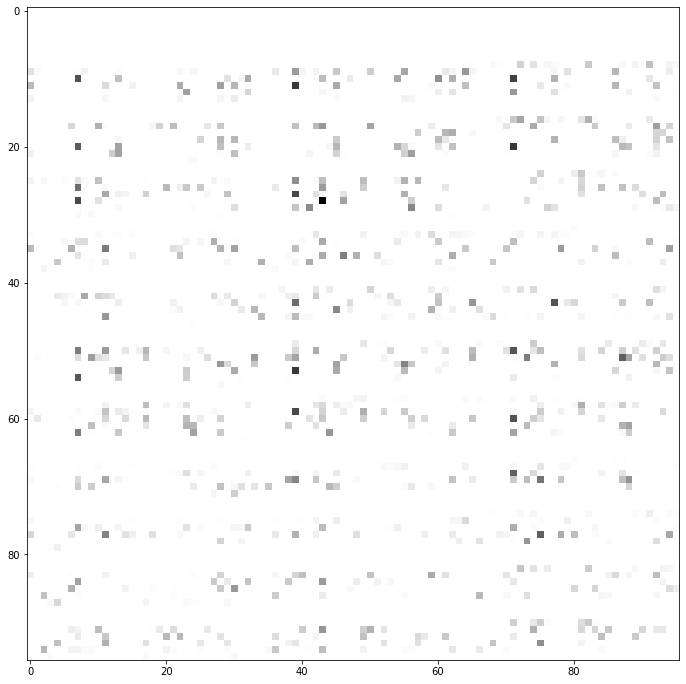

Displaying activation map 5
The activations for the layer is [   0.       366.1951     0.      2441.5547   854.483    791.0846
 1233.283     95.22176    0.      1404.3033   900.33344  544.84863
  891.2961    78.14798  643.076   1661.7831  2815.7188  2825.2944
 3487.7976  2211.988    460.58783 1327.4314   838.693   2034.4668
  267.52756 2199.6162     0.       795.466   3032.7178     0.
 1961.9445  1937.1346  1504.7639     0.       450.13583   32.6247
  738.80896  321.22546    0.         0.       934.7378  3321.2288
 1441.3809     0.       796.46674    0.      2293.523    757.4051
    0.      2139.7314 ]


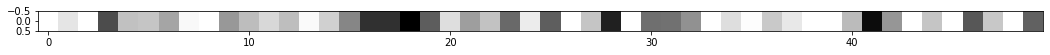

Displaying activation map 6
The activations for the layer is [   0.       776.5659   124.7494  3652.2297  1435.9827  1023.30457
    0.       129.83603    0.         0.      1578.8304     0.
    0.         0.         0.         0.         0.      3971.5828
    0.      3284.5283     0.      2510.9683     0.         0.
  447.88144    0.         0.       979.5168  4078.764      0.
 2806.71    2832.3118  2336.3433     0.       720.88995    0.
    0.         0.       347.7602     0.         0.      4932.8516
 2760.3584     0.      1628.504      0.         0.      1566.6547
    0.      3038.3174 ]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).


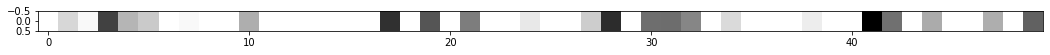

Displaying activation map 7
The activations for the layer is [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


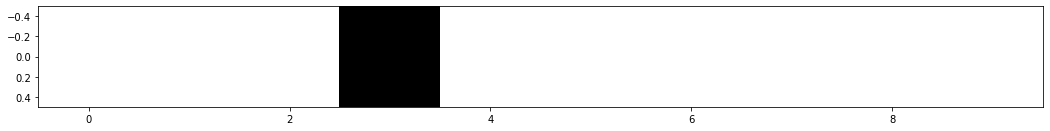

In [26]:
#test image for 3

test_image(x_test_img_3,767)

[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]
(1, 28, 28, 1)
----- activations -----
(1, 26, 26, 32)
(1, 24, 24, 64)
(1, 12, 12, 64)
(1, 12, 12, 64)
(1, 9216)
(1, 50)
(1, 50)
(1, 10)
Displaying activation map 0


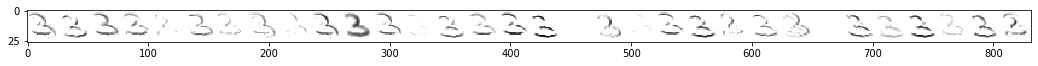

Displaying activation map 1


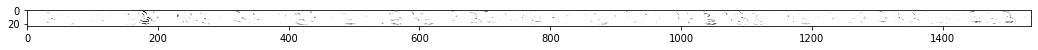

Displaying activation map 2


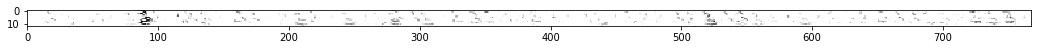

Displaying activation map 3


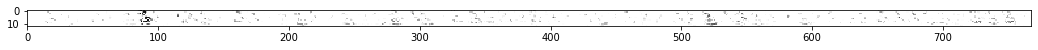

Displaying activation map 4
The activations for the layer is [0. 0. 0. ... 0. 0. 0.]


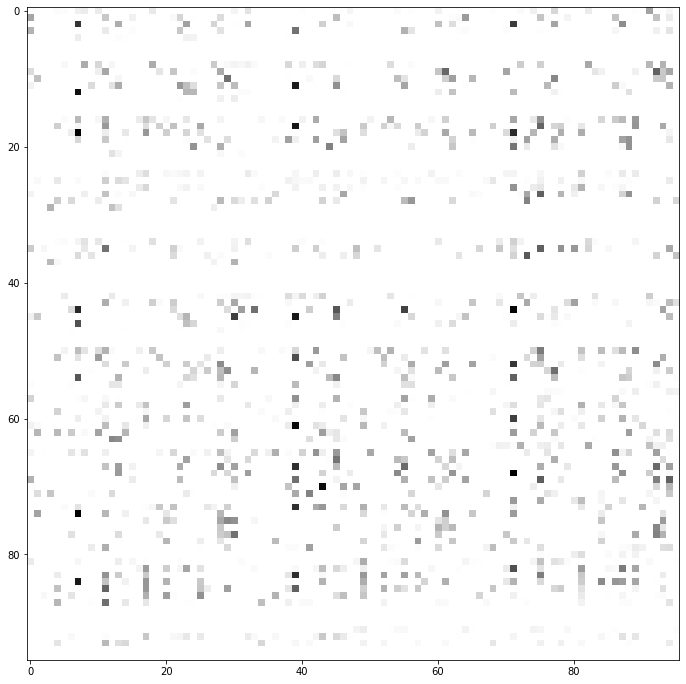

Displaying activation map 5
The activations for the layer is [ 894.511        3.8355458    0.        2691.0798     375.7642
 1187.2847    2139.4014     912.19336      0.        2339.89
 1154.555     1268.3263     896.9712     782.2379       0.
 1570.0975    2706.6853    3004.5486    2314.8284    2147.788
  508.57492   1033.3486    1202.0127    2042.3418    1295.9617
 3363.3608       0.        1510.3881    3173.952      185.90875
 1482.6017    2583.6423    1412.7838    1576.4365       0.
  153.76524   1169.8501     579.155        0.           0.
 1176.9241    3316.6184    2022.5348       0.         469.37976
    0.        2219.0762     156.89882    553.58514   3159.6626   ]


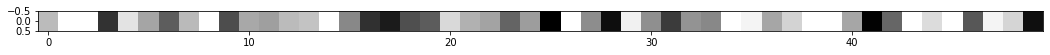

Displaying activation map 6
The activations for the layer is [6.7208594e+02 3.0867562e+00 0.0000000e+00 3.4563281e+03 6.2968573e+02
 1.6238528e+03 2.8963198e+03 0.0000000e+00 0.0000000e+00 3.3295542e+03
 1.8067462e+03 1.8561687e+03 1.3942985e+03 1.2688057e+03 0.0000000e+00
 2.2317776e+03 0.0000000e+00 0.0000000e+00 3.2261648e+03 2.4516279e+03
 2.4396431e+02 0.0000000e+00 0.0000000e+00 2.7132468e+03 2.3806619e+03
 0.0000000e+00 0.0000000e+00 0.0000000e+00 4.7793076e+03 1.0162270e+01
 2.1535137e+03 3.8987617e+03 1.7832452e+03 2.2146851e+03 0.0000000e+00
 0.0000000e+00 1.6753621e+03 0.0000000e+00 0.0000000e+00 0.0000000e+00
 1.8118112e+03 4.7715522e+03 3.3918323e+03 0.0000000e+00 7.4039392e+02
 0.0000000e+00 0.0000000e+00 2.3444211e+00 6.9541479e+02 0.0000000e+00]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).


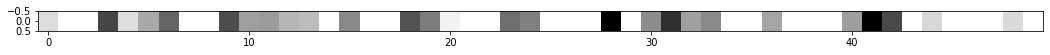

Displaying activation map 7
The activations for the layer is [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


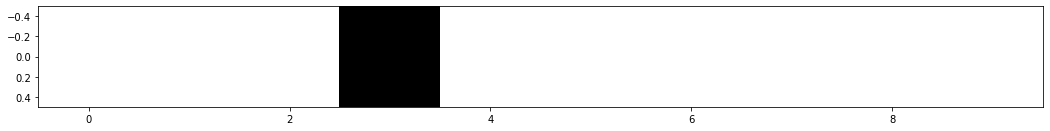

In [27]:
#test image for 3

test_image(x_test_img_3,347)

[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]
(1, 28, 28, 1)
----- activations -----
(1, 26, 26, 32)
(1, 24, 24, 64)
(1, 12, 12, 64)
(1, 12, 12, 64)
(1, 9216)
(1, 50)
(1, 50)
(1, 10)
Displaying activation map 0


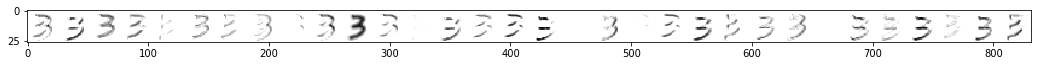

Displaying activation map 1


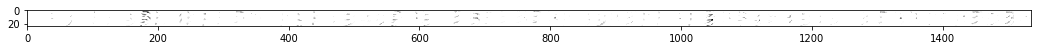

Displaying activation map 2


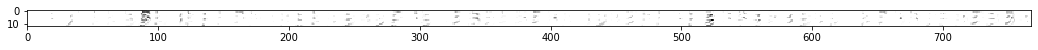

Displaying activation map 3


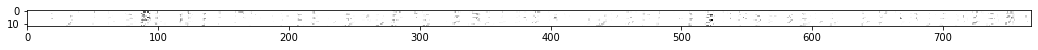

Displaying activation map 4
The activations for the layer is [0. 0. 0. ... 0. 0. 0.]


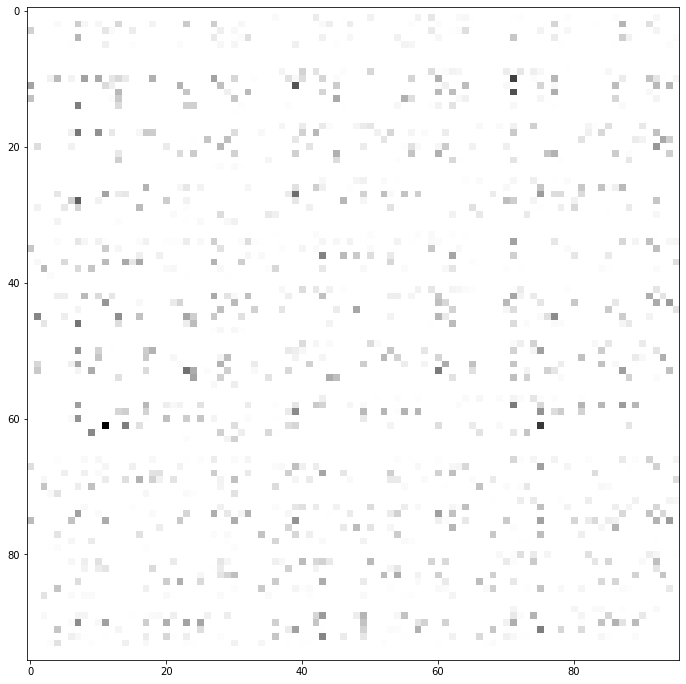

Displaying activation map 5
The activations for the layer is [1542.8171   245.3225     0.      2552.4946   408.33298  836.1706
 1996.155   1066.5745  1084.4905  1811.9739  1216.6813   465.82074
  696.42474  114.10142  878.7587  1287.6315  2017.8207  2962.2075
 2777.0244  2531.096      0.      1892.6743   611.18024 2001.8113
 1258.1227  3440.3635   758.8662  1619.486   2990.451     16.17133
 2028.6886  1287.9662  2425.716    778.5432   130.26472    0.
 1021.1727   730.3988   420.6717   544.42035  512.6173  3777.089
 1287.5913   519.0475  1005.52094   90.82188 3208.3      913.6608
  462.64893 2763.7808 ]


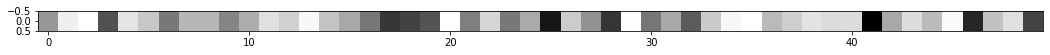

Displaying activation map 6
The activations for the layer is [2291.6794    262.31714     0.       3713.5867    473.4175   1260.3297
 2970.6277      0.       1789.1803   2534.9856      0.        530.583
    0.          0.          0.       2180.596       0.          0.
 4536.5225   3948.5994      0.       2698.197    1215.6106   3010.8945
 2044.7196   4892.9775   1395.0878   2348.0986      0.          0.
    0.       2296.9854      0.        928.2654    308.2204      0.
 1786.9286      0.          0.        821.91125   740.15295  5932.55
 2126.8584      0.       1692.9052     19.690462 4834.371    1387.316
  379.19437     0.      ]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).


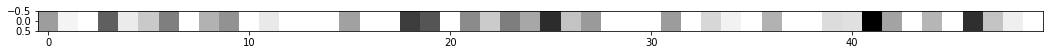

Displaying activation map 7
The activations for the layer is [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


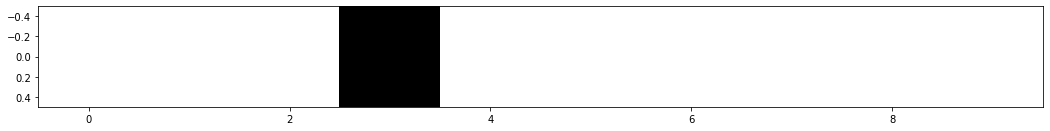

In [28]:
#test image for 3

test_image(x_test_img_3,967)

(982, 28, 28)
(982, 28, 28, 1)
[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]
(1, 28, 28, 1)
----- activations -----
(1, 26, 26, 32)
(1, 24, 24, 64)
(1, 12, 12, 64)
(1, 12, 12, 64)
(1, 9216)
(1, 50)
(1, 50)
(1, 10)
Displaying activation map 0


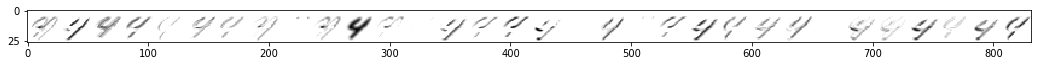

Displaying activation map 1


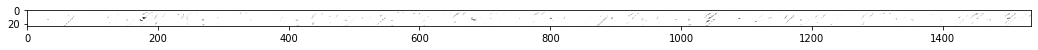

Displaying activation map 2


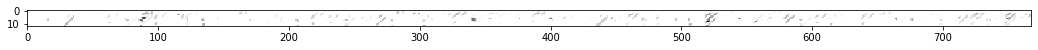

Displaying activation map 3


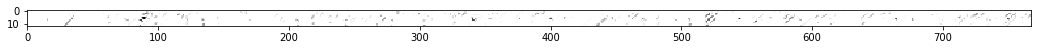

Displaying activation map 4
The activations for the layer is [0. 0. 0. ... 0. 0. 0.]


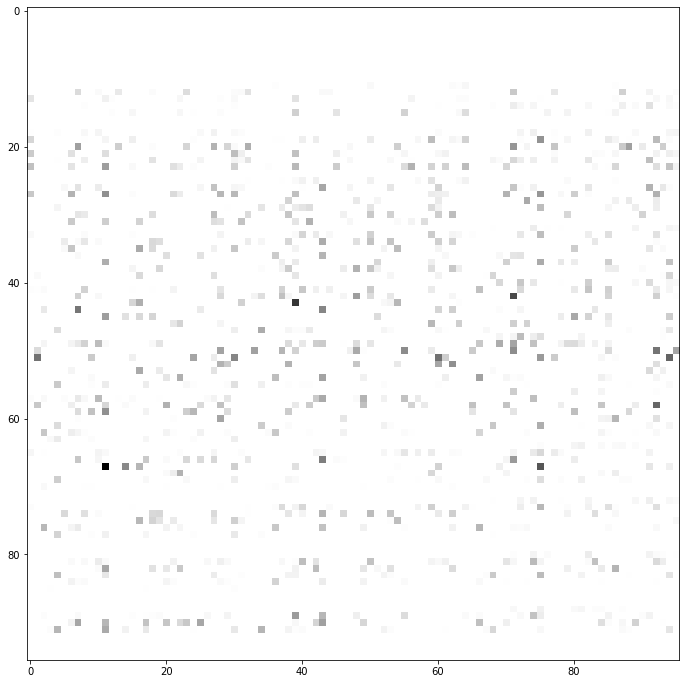

Displaying activation map 5
The activations for the layer is [ 947.8244    781.34753   515.4009   1634.974    1619.2428   1555.1193
   49.601498 1083.4564    728.17816  1211.838    1651.6934    956.09937
  910.8313     87.0308   2392.071    1343.1788   1711.2216   1022.3287
 1861.7664   2352.1128   1368.2644   2825.0183   1275.4907   1281.1333
 1223.8835    616.9546    389.44846  1212.3015    946.8242    738.1428
  899.6363    554.32416  1058.8146   1030.8542   1057.8418   1015.1118
 2236.5203    670.6658   1381.3342    888.8342   1140.6528   1755.9655
 2669.8115     16.254442 2893.8694   1566.5131   1195.7866   1384.8235
 1014.8774    218.53804 ]


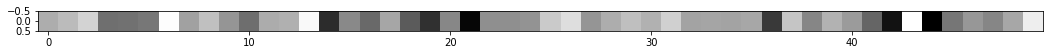

Displaying activation map 6
The activations for the layer is [   0.         0.       937.36304 2402.9014     0.      2422.5898
    0.         0.         0.         0.      2760.336   1822.3398
 1696.1101   108.4114  3855.184      0.      2645.5503  1756.761
    0.         0.      2354.0017     0.      2310.462      0.
 2082.6702  1023.9111     0.      2011.7911  1641.2198  1253.0857
 1691.9559     0.      1726.1079  1874.7223  1816.664   1901.3518
    0.       908.7351  2194.376   1639.7837     0.         0.
 4303.732      0.      4591.404      0.      1568.9741  2208.464
    0.       347.61853]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).


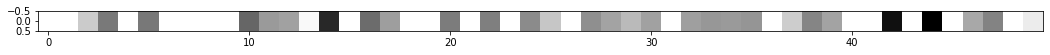

Displaying activation map 7
The activations for the layer is [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


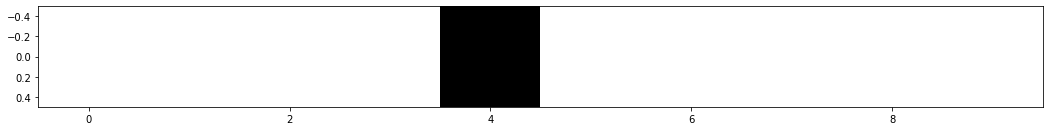

In [29]:
#retrieveing images for num 4

x_test_img_4=img_samenum(x_test_filter,y_test_filter,4)

#test image for 4

test_image(x_test_img_4,677)

[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]
(1, 28, 28, 1)
----- activations -----
(1, 26, 26, 32)
(1, 24, 24, 64)
(1, 12, 12, 64)
(1, 12, 12, 64)
(1, 9216)
(1, 50)
(1, 50)
(1, 10)
Displaying activation map 0


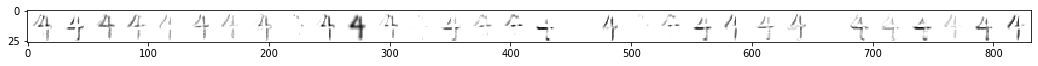

Displaying activation map 1


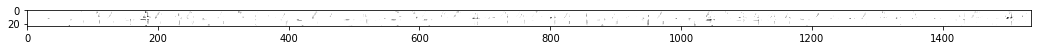

Displaying activation map 2


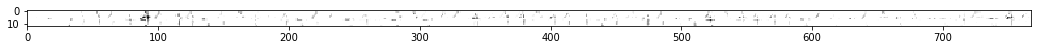

Displaying activation map 3


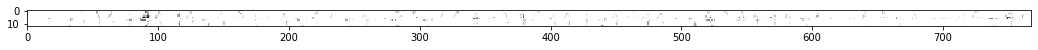

Displaying activation map 4
The activations for the layer is [0. 0. 0. ... 0. 0. 0.]


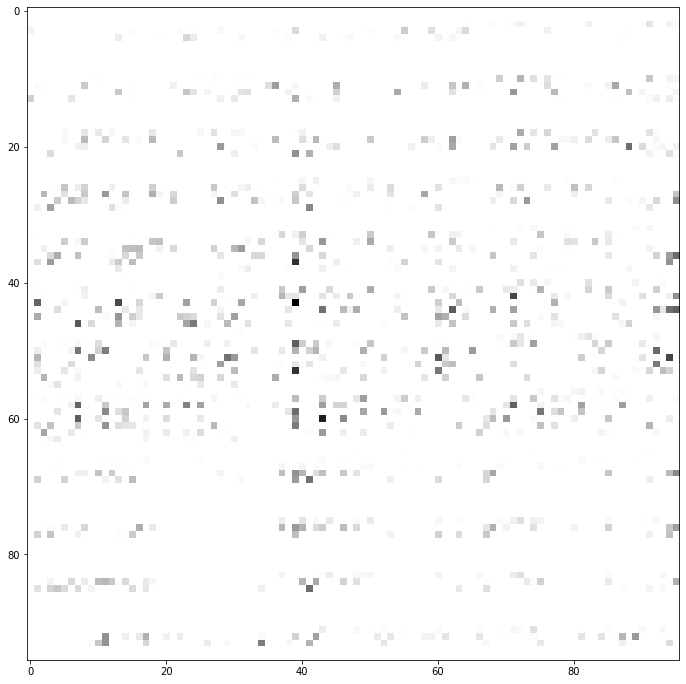

Displaying activation map 5
The activations for the layer is [1.9334726e+02 1.0166411e+03 6.1087067e+02 1.6729855e+03 2.3254678e+03
 1.0692961e+03 2.6135468e+02 2.0469775e+03 1.2902529e+03 8.3810742e+02
 1.7936876e+03 8.3528497e+02 9.2453851e+02 5.2050238e+02 2.8134028e+03
 9.0174896e+02 1.2748533e+03 1.2952410e+03 1.7009509e+03 2.4923201e+03
 6.2302856e+02 3.6009395e+03 2.0313733e+03 1.7392031e+03 1.8499138e+03
 1.3522505e+03 9.2623901e+02 2.2454990e+03 9.4910632e+02 0.0000000e+00
 2.0429025e+03 7.1352039e+02 9.2679584e+02 1.9473378e+03 1.0123448e+03
 1.8362219e+02 2.5305581e+03 1.0917656e+00 1.1477169e+03 5.2819073e+02
 8.7546289e+02 1.7374976e+03 2.6011157e+03 5.2261481e+02 2.9347773e+03
 1.9275160e+03 1.0008221e+03 1.4046058e+03 8.3864276e+02 6.5421240e+02]


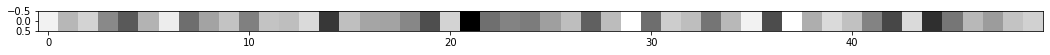

Displaying activation map 6
The activations for the layer is [ 167.90724     0.       1147.6603   2324.6309      0.          0.
  392.93512  2877.8176      0.        926.7137   2576.2822      0.
 1337.7251    601.6591   4207.776    1160.5867   1732.8043   1878.9916
    0.       3799.5798      0.       5195.0156   2675.9746   2598.3616
    0.       2050.934    1379.173    3362.7156   1484.5259      0.
 3004.01        0.       1341.6971   2784.9407   1596.2772      0.
    0.         13.800569    0.        869.9465   1288.8378      0.
 3902.3855    707.7392   3934.384    2877.0059   1517.092       0.
    0.          0.      ]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).


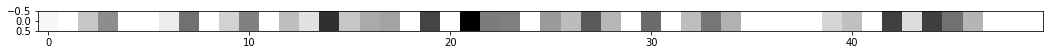

Displaying activation map 7
The activations for the layer is [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


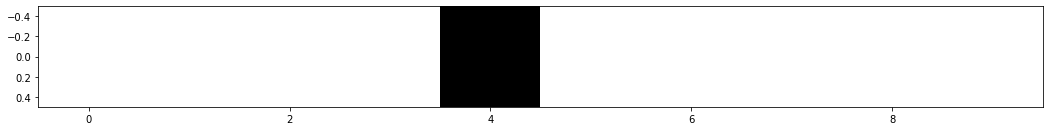

In [30]:

#test image for 4

test_image(x_test_img_4,177)

[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]
(1, 28, 28, 1)
----- activations -----
(1, 26, 26, 32)
(1, 24, 24, 64)
(1, 12, 12, 64)
(1, 12, 12, 64)
(1, 9216)
(1, 50)
(1, 50)
(1, 10)
Displaying activation map 0


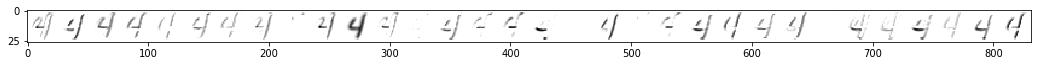

Displaying activation map 1


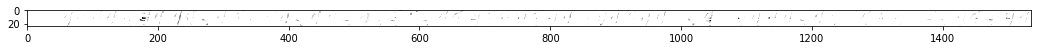

Displaying activation map 2


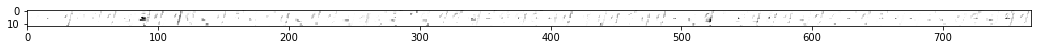

Displaying activation map 3


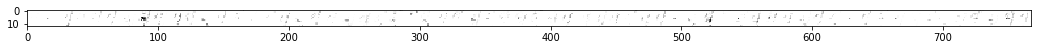

Displaying activation map 4
The activations for the layer is [0. 0. 0. ... 0. 0. 0.]


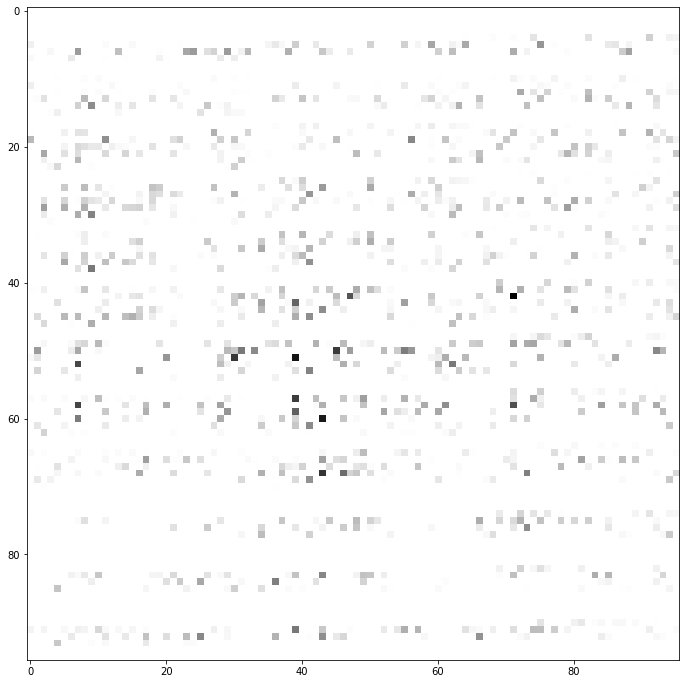

Displaying activation map 5
The activations for the layer is [ 916.43256 1141.647    549.3006  1579.6848  2372.4495   867.2424
  690.49927 3223.118   1624.1399   927.96497 1755.1665  1188.0447
  818.5098   368.87842 2801.576    887.4106  1597.6439   584.6753
 1167.7365  2755.1245   525.22406 3127.7883  1955.3949  1984.4343
 2370.7078  1227.0981   879.46906 2642.431    541.0993   550.9233
 1888.3275   336.8125   659.78217 2342.511   1121.7118  1218.4846
 2718.1025   605.48785 1443.4806  1149.7211   401.20752 1101.8405
 2035.2926   465.34082 2979.607   2457.9321   905.3585   788.0226
 1282.4165   938.6035 ]


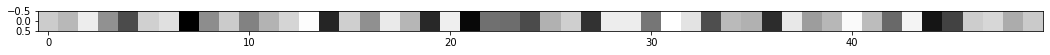

Displaying activation map 6
The activations for the layer is [   0.         0.       792.25073 2288.4     3378.297   1161.001
  991.25854 4288.495   2210.5703  1110.8092  2874.6396     0.
 1209.6135     0.      4309.7407  1410.7019     0.       994.0672
 1742.8054     0.       765.5451     0.         0.      2793.9338
 3682.4202     0.         0.      3809.0156  1012.9249   541.9258
 2449.7957   805.39484 1268.8567     0.      1675.1777  1667.5195
 4293.612    625.8255  2368.698   1763.553    854.90405 2082.2776
    0.       349.23917 4783.195   3448.4353     0.      1309.0789
 1482.5839  1170.8024 ]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).


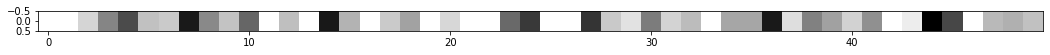

Displaying activation map 7
The activations for the layer is [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


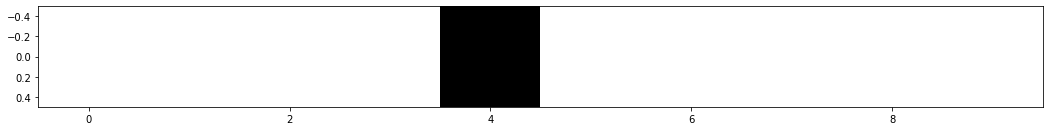

In [31]:

#test image for 4

test_image(x_test_img_4,977)

(892, 28, 28)
(892, 28, 28, 1)
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
(1, 28, 28, 1)
----- activations -----
(1, 26, 26, 32)
(1, 24, 24, 64)
(1, 12, 12, 64)
(1, 12, 12, 64)
(1, 9216)
(1, 50)
(1, 50)
(1, 10)
Displaying activation map 0


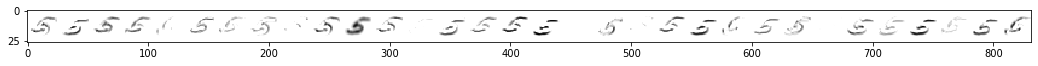

Displaying activation map 1


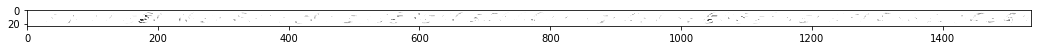

Displaying activation map 2


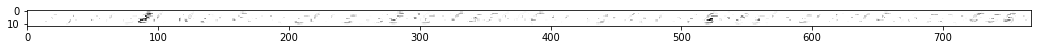

Displaying activation map 3


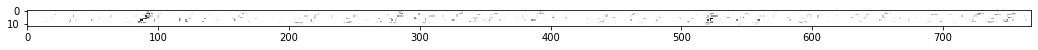

Displaying activation map 4
The activations for the layer is [0. 0. 0. ... 0. 0. 0.]


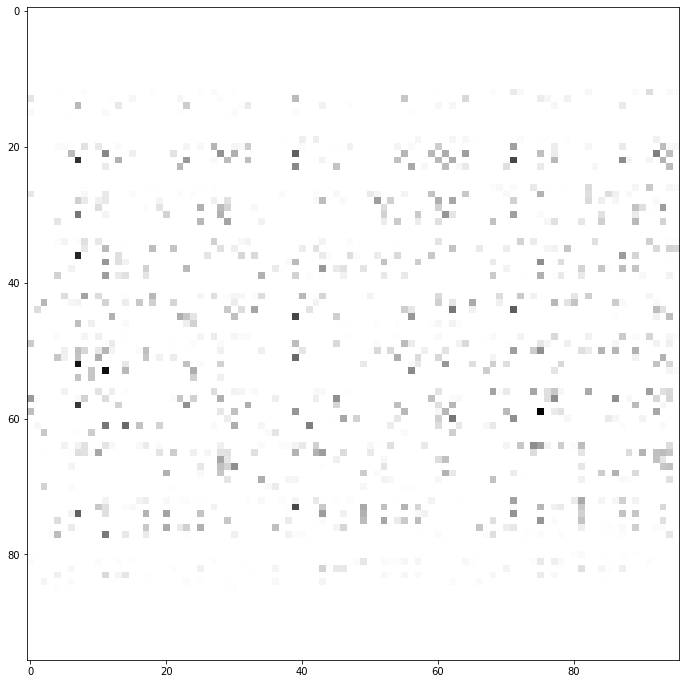

Displaying activation map 5
The activations for the layer is [1840.8278  1950.807      0.      1912.6766   446.35187 2629.6067
  543.00006 1750.9198  1105.128   2848.7903  1902.5768     0.
  324.95102 1363.5483   656.34985 1455.0037  2573.2715  1029.4462
 3106.8442   984.34265 1256.1515  2261.7732  1443.7585   510.5867
  492.47287  529.3316   117.13693  261.8542   953.95526  570.1621
  444.67285 1127.6069  1020.33844  301.56622    0.       544.17596
 1468.7102   246.43549 1896.5083   638.7837  1140.8864  3233.4365
 1357.6389     0.      2407.0818   737.99225 1726.6432   893.8889
 1582.3538   770.4778 ]


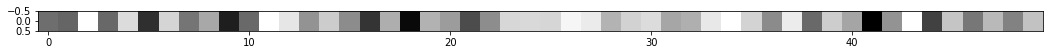

Displaying activation map 6
The activations for the layer is [   0.         0.         0.      2850.4636   788.6529  4198.642
  421.2875  2923.8494  1551.3619  4293.1016     0.         0.
  378.747   2558.5864  1207.9906  2025.4565     0.      1413.7979
 4621.4478     0.      1719.6205     0.      1731.9642   624.14795
  920.5311   584.5173     0.       236.29097 1131.2405     0.
  414.38477    0.      1234.1138   240.22665    0.       823.42175
    0.       214.56837 3176.7961     0.      1697.229      0.
 2082.9517     0.      3985.0466  1017.4925     0.         0.
 2313.9841   711.254  ]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).


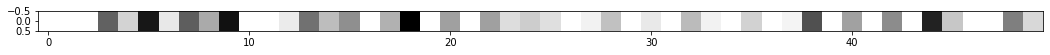

Displaying activation map 7
The activations for the layer is [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


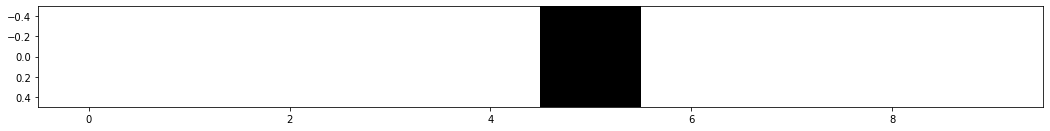

In [32]:
#retrieveing images for num 5

x_test_img_5=img_samenum(x_test_filter,y_test_filter,5)

#test image for 5

test_image(x_test_img_5,677)

[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
(1, 28, 28, 1)
----- activations -----
(1, 26, 26, 32)
(1, 24, 24, 64)
(1, 12, 12, 64)
(1, 12, 12, 64)
(1, 9216)
(1, 50)
(1, 50)
(1, 10)
Displaying activation map 0


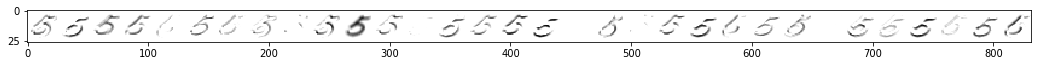

Displaying activation map 1


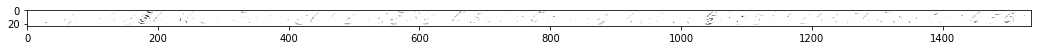

Displaying activation map 2


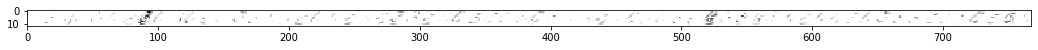

Displaying activation map 3


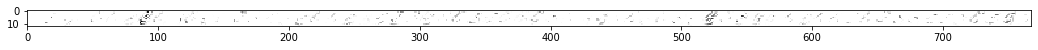

Displaying activation map 4
The activations for the layer is [0. 0. 0. ... 0. 0. 0.]


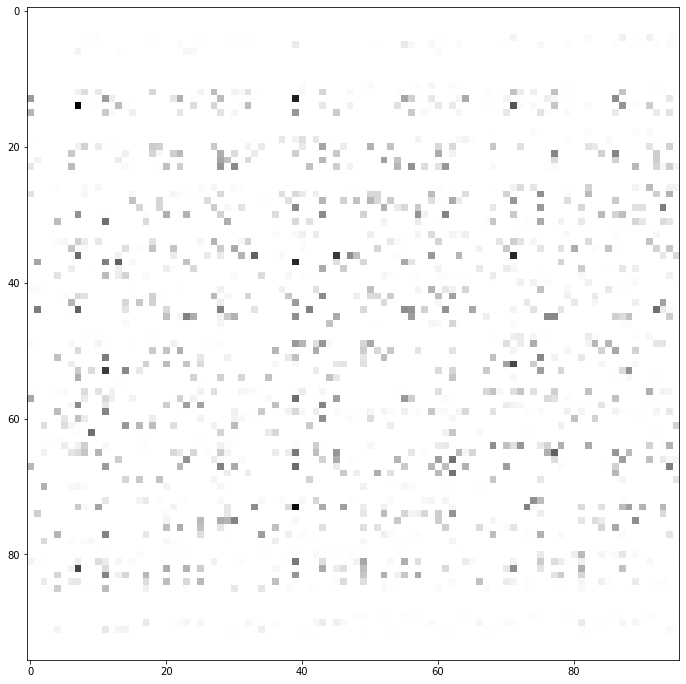

Displaying activation map 5
The activations for the layer is [2752.56     2143.5437      0.       2485.5723     35.99627  2996.8232
 1457.5337   2243.8687    516.56177  2811.677    1411.4432    867.4275
  916.57074  1571.3137     43.804035 2076.207    3157.87     1689.6133
 3367.2678   1446.9792   1368.5702   2072.292     945.39557   963.2442
  469.35223   975.7554    127.89324   413.75488  1595.1923   1063.9458
  631.7336   1484.7638   1191.7852     82.07537     0.        919.9323
 1362.2704    323.65384  1500.0612    991.7708    714.9993   3757.0808
 1144.1028      0.       2414.2742    826.2644   2030.8641    413.29727
 2196.0422   1233.0876  ]


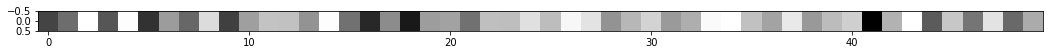

Displaying activation map 6
The activations for the layer is [   0.       2976.2073      0.          0.          0.       4243.73
 1884.1744   3291.7297      0.       4162.5176   2169.4976      0.
    0.       1973.8281      0.          0.       4573.167    2546.2124
    0.       2024.6561   2300.543    2775.5886   1901.7697   1712.9554
  503.86423   967.6865     57.321026  750.36414     0.       1807.2488
    0.       2152.3093   1387.0376      0.          0.          0.
 2080.3806      0.       1876.9031   1558.5596   1006.9641      0.
 1716.997       0.       3519.3164      0.       2568.347     424.22266
    0.       1722.0011  ]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).


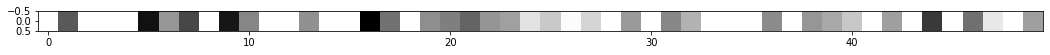

Displaying activation map 7
The activations for the layer is [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


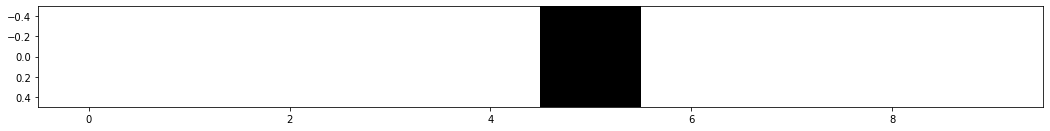

In [33]:
#test image for 5

test_image(x_test_img_5,877)

[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
(1, 28, 28, 1)
----- activations -----
(1, 26, 26, 32)
(1, 24, 24, 64)
(1, 12, 12, 64)
(1, 12, 12, 64)
(1, 9216)
(1, 50)
(1, 50)
(1, 10)
Displaying activation map 0


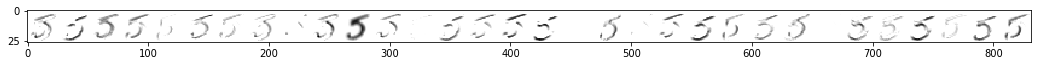

Displaying activation map 1


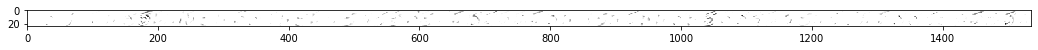

Displaying activation map 2


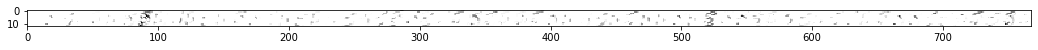

Displaying activation map 3


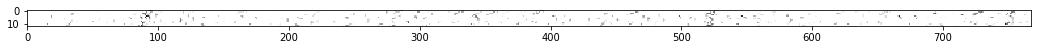

Displaying activation map 4
The activations for the layer is [0. 0. 0. ... 0. 0. 0.]


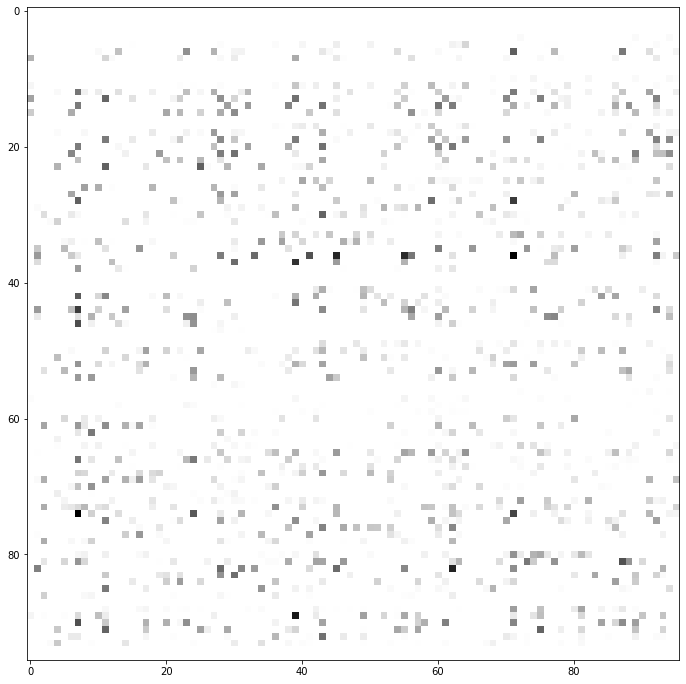

Displaying activation map 5
The activations for the layer is [2298.6196  2190.3108   285.7621  2295.3357   484.86627 2675.8093
 1189.937   2983.9165  1365.2015  2175.3826  1025.7526  2317.6008
 2011.5149  1505.9886   527.3799  1885.4496  2690.186   1523.0199
 3658.2185  1663.3198  1303.0409  2928.8042     0.       654.0876
  353.4346   968.7576   206.37628  761.5244  1462.4587  1176.6737
 1198.1437   961.47437  941.3349     0.       609.4246   728.5458
  649.1671   532.16583 1230.9951  1610.6771   673.83563 3811.0737
  871.7354   387.36407 2396.1616   295.3281  2872.478    958.3899
 2382.7668   802.3135 ]


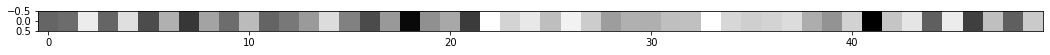

Displaying activation map 6
The activations for the layer is [3569.0784  2948.0435     0.         0.         0.         0.
 2010.9375  4062.5662  1682.004      0.      1757.2322  3900.8154
 3176.4258  2044.3181   821.4097  3013.2966     0.      2263.2605
    0.      2548.0574  2311.901   3921.7632     0.         0.
    0.      1562.2296     0.         0.         0.         0.
 1754.9755  1594.7151     0.         0.       936.0657  1358.9193
    0.         0.      1562.3583  2402.938      0.      5563.3154
 1698.933    317.99918    0.       727.9323  3846.4612  1134.9167
    0.      1474.9653 ]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).


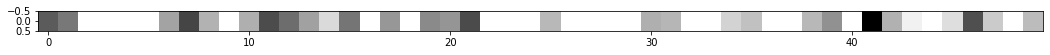

Displaying activation map 7
The activations for the layer is [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


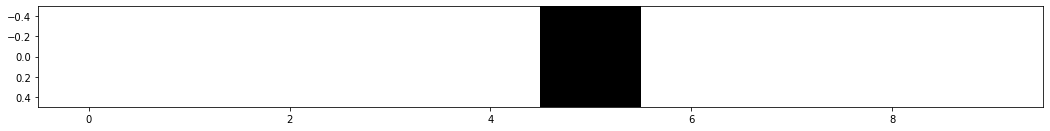

In [34]:
#test image for 5

test_image(x_test_img_5,377)

(958, 28, 28)
(958, 28, 28, 1)
[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
(1, 28, 28, 1)
----- activations -----
(1, 26, 26, 32)
(1, 24, 24, 64)
(1, 12, 12, 64)
(1, 12, 12, 64)
(1, 9216)
(1, 50)
(1, 50)
(1, 10)
Displaying activation map 0


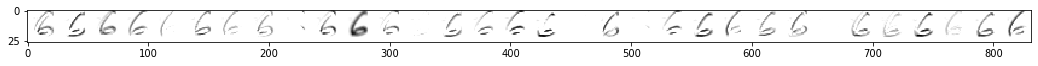

Displaying activation map 1


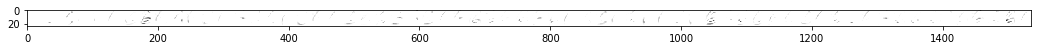

Displaying activation map 2


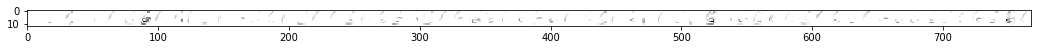

Displaying activation map 3


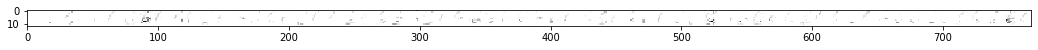

Displaying activation map 4
The activations for the layer is [0. 0. 0. ... 0. 0. 0.]


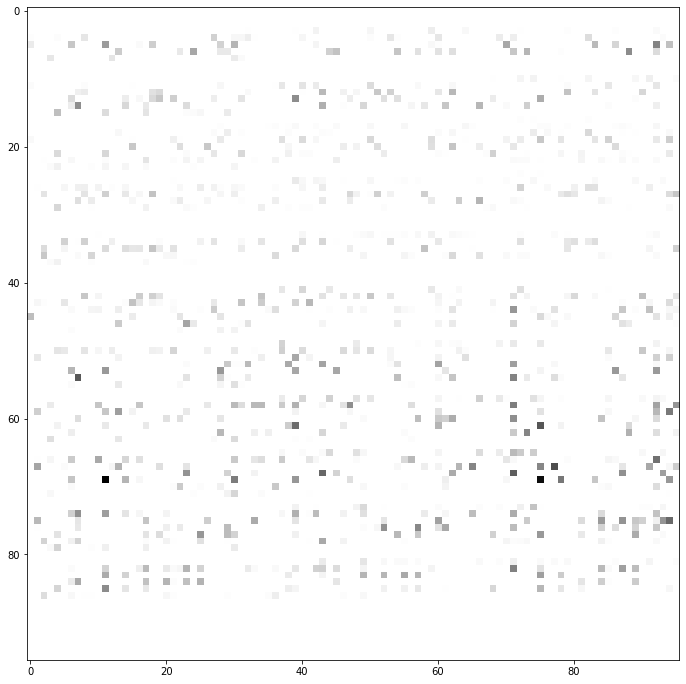

Displaying activation map 5
The activations for the layer is [ 250.20757 2494.5032     0.       559.0375   933.17126 3504.4604
    0.      2475.5042     0.      3467.7056  3221.3894   987.0106
  930.67175  177.88275  305.091   2553.499   1360.626   1647.8788
 3643.2969  1321.2158  2244.4753  1089.0466  2834.43     405.6957
  668.4355   923.4311     0.       517.733    915.3349  2569.516
  570.14    2287.107    724.18616 1605.3984     0.      1808.6312
 2360.5144   762.9985   274.8434   648.19885 2738.2634  1741.8142
 1706.0787     0.      1381.428   1629.9255   606.9402   335.24442
 2683.264   1052.598  ]


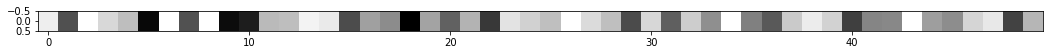

Displaying activation map 6
The activations for the layer is [ 569.1581  3711.0303     0.         0.      1647.2297  5139.7847
  478.0935     0.         0.         0.      4592.5693  1481.9368
 1109.446      0.       333.20932    0.         0.      2500.0347
    0.         0.         0.      1454.953   3737.0603     0.
 1530.5503  1578.843      0.         0.      1555.2684  3911.383
  858.8877  3680.4067     0.      2687.4006     0.         0.
    0.      1134.4297   405.45917  853.88336 4307.607      0.
 2756.5525     0.      2035.274   2405.076   1060.6395     0.
 4065.839      0.     ]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).


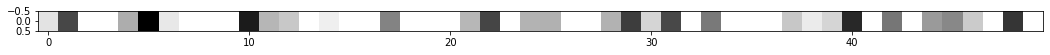

Displaying activation map 7
The activations for the layer is [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


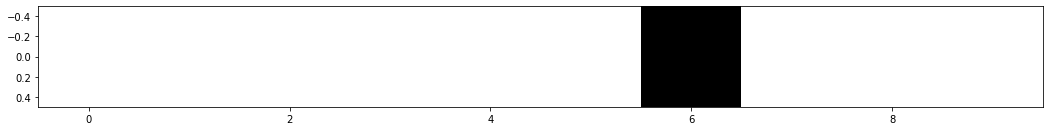

In [35]:
#retrieveing images for num 6

x_test_img_6=img_samenum(x_test_filter,y_test_filter,6)

#test image for 6

test_image(x_test_img_6,677)

[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
(1, 28, 28, 1)
----- activations -----
(1, 26, 26, 32)
(1, 24, 24, 64)
(1, 12, 12, 64)
(1, 12, 12, 64)
(1, 9216)
(1, 50)
(1, 50)
(1, 10)
Displaying activation map 0


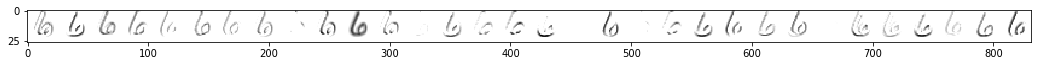

Displaying activation map 1


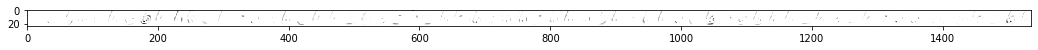

Displaying activation map 2


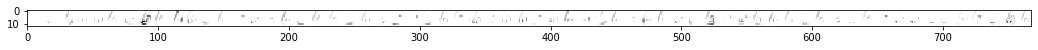

Displaying activation map 3


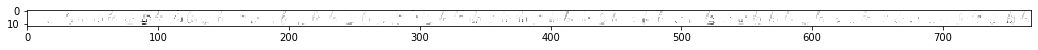

Displaying activation map 4
The activations for the layer is [0. 0. 0. ... 0. 0. 0.]


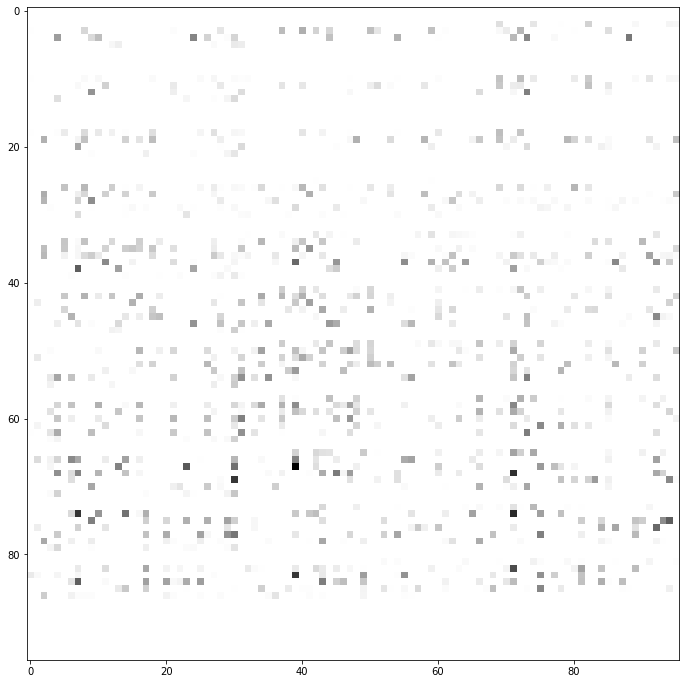

Displaying activation map 5
The activations for the layer is [1038.9353   2605.6023    335.99948   525.7021    925.3511   3310.3633
  499.5885   3258.008       0.       2767.3613   2922.914    1392.6226
 1132.6062    348.60052   387.64795  3285.619    1132.3573   1674.6819
 2162.0593    840.0976   2463.481     706.598    2993.205     116.07726
 1093.9374   1268.3362      0.       1690.8823   1214.3832   3321.1965
 1008.6585   2279.1296    638.04974  2757.7896      0.       1481.0065
 2675.4094    559.36646    19.680698 1218.4329   2761.034    1239.6195
 1452.5267      0.        824.2792   2262.5276    420.63376     0.
 3315.8625   1280.011   ]


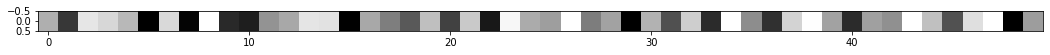

Displaying activation map 6
The activations for the layer is [   0.      3907.544      0.       976.3562     0.      4828.6763
  770.54364 5321.2476     0.      4133.9556  4105.7603  2598.5312
 1649.1423     0.       275.36868    0.      1496.45       0.
 2831.0925     0.         0.       954.80585 4504.4033   381.8463
 1777.8654  1888.9805     0.      2643.2358     0.      5351.824
 1665.6273  3328.5728   412.2233  4178.061      0.      2225.094
 3686.0315   876.6277     0.         0.      4050.7788     0.
 1982.9167     0.       968.1638     0.         0.         0.
    0.      1903.9296 ]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).


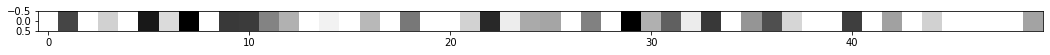

Displaying activation map 7
The activations for the layer is [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


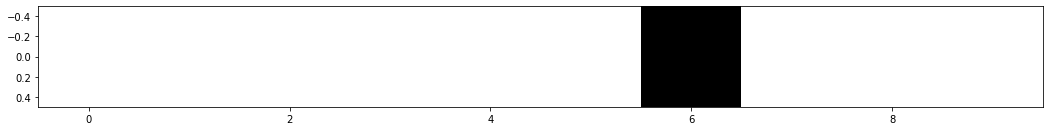

In [36]:
#test image for 6

test_image(x_test_img_6,277)

[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
(1, 28, 28, 1)
----- activations -----
(1, 26, 26, 32)
(1, 24, 24, 64)
(1, 12, 12, 64)
(1, 12, 12, 64)
(1, 9216)
(1, 50)
(1, 50)
(1, 10)
Displaying activation map 0


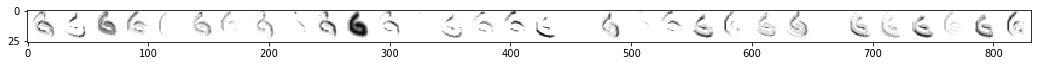

Displaying activation map 1


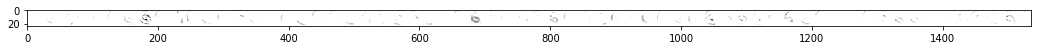

Displaying activation map 2


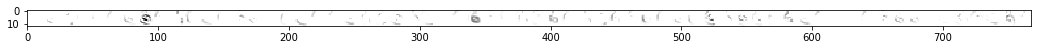

Displaying activation map 3


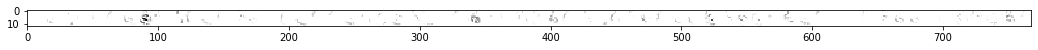

Displaying activation map 4
The activations for the layer is [0. 0. 0. ... 0. 0. 0.]


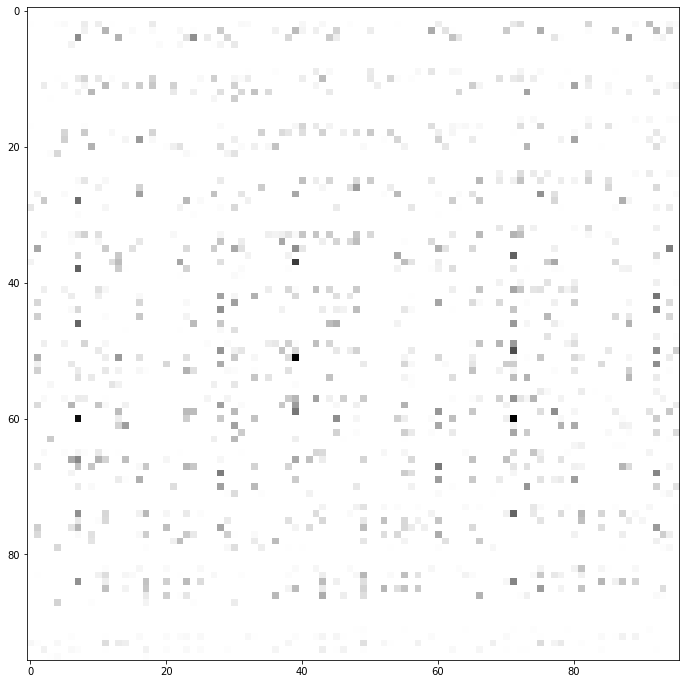

Displaying activation map 5
The activations for the layer is [ 383.45227 2331.538    320.16977  966.6607  1448.9277  3595.8428
  320.5404  2289.8987   157.6245  2241.8345  2788.941    716.92474
  396.27298  554.42285 1243.5502  2986.6895  1984.2311  1005.74713
 3013.8818  1346.6566  2492.6125  2148.0515  2868.465    776.90466
  955.8737   652.1216     0.      1213.5863  1313.4009  1672.1862
  989.6806  2366.8254  1062.763   2230.6426     0.      1048.6927
 3172.5361     0.       828.63794    0.      2619.1106  2222.8418
 2253.9731     0.      2118.8118  1281.4987  1077.049   1027.2452
 2415.2795   203.77588]


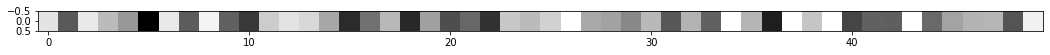

Displaying activation map 6
The activations for the layer is [ 687.4709  3617.1077   565.05286    0.      1931.2162  5433.11
  250.20053    0.       236.79153    0.      4493.0625  1180.5792
  956.8429  1095.9297  1592.4409  4434.176   3066.8142  1563.4808
 4386.6465     0.      3519.0122  2927.6472     0.         0.
 1915.9565  1066.1038     0.      1697.8165  1635.7101  2731.8167
 1671.1306  3301.008   1502.0475  3598.7385     0.      1723.4231
 4519.5107     0.         0.       177.87753 3933.942      0.
    0.         0.      3036.4866  1927.126   1726.6194     0.
    0.         0.     ]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).


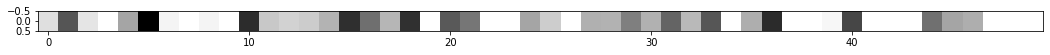

Displaying activation map 7
The activations for the layer is [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


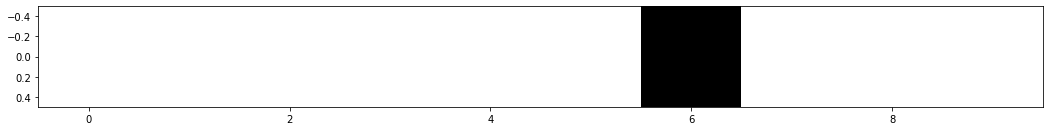

In [37]:
#test image for 6

test_image(x_test_img_6,77)

(1028, 28, 28)
(1028, 28, 28, 1)
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
(1, 28, 28, 1)
----- activations -----
(1, 26, 26, 32)
(1, 24, 24, 64)
(1, 12, 12, 64)
(1, 12, 12, 64)
(1, 9216)
(1, 50)
(1, 50)
(1, 10)
Displaying activation map 0


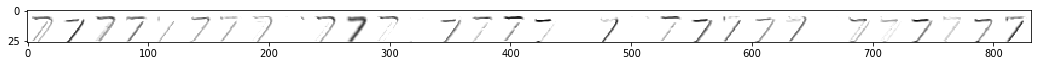

Displaying activation map 1


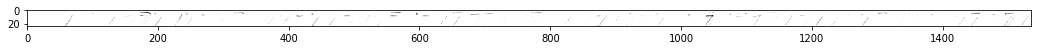

Displaying activation map 2


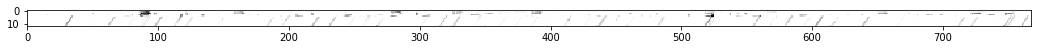

Displaying activation map 3


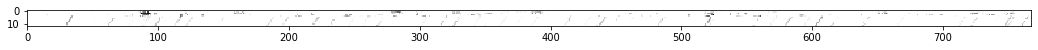

Displaying activation map 4
The activations for the layer is [0. 0. 0. ... 0. 0. 0.]


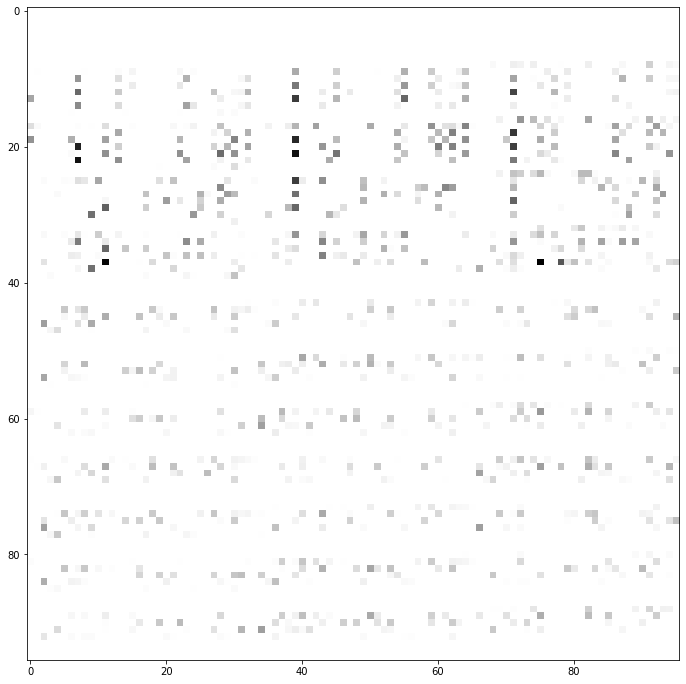

Displaying activation map 5
The activations for the layer is [ 430.2303    1042.9158       0.         961.8075       0.
    0.         412.8078     668.83234   2055.8145     380.51334
 1359.092     1588.4784    2515.8315       0.        1879.4784
  550.364      980.7607    2627.7368    1432.8572    2285.7642
    0.        2182.8828       0.           3.7401145    0.
 3010.7585    2139.614     1699.7692    2182.4055     769.497
 1443.5272     679.87115   1277.1422       0.        2049.515
    0.         237.1237    1361.5862     183.82263   2535.2258
  738.74786   1288.397      630.8347    2052.9365       0.
    0.        2784.423     1308.7249     190.94301   1589.3737   ]


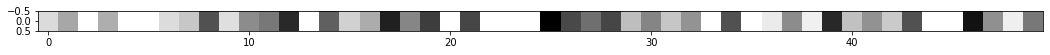

Displaying activation map 6
The activations for the layer is [   0.         0.         0.      1573.208      0.         0.
  603.00775    0.      3297.4287     0.         0.      2229.7478
 3815.4685     0.         0.         0.      1421.5692  3892.4475
 2135.012      0.       219.23       0.         0.         0.
    0.      4676.054   3384.045   2869.492   3065.6287  1614.5219
 2308.4592   996.38666 1918.8606   309.81003    0.         0.
  616.36145 2139.3794   481.4451     0.         0.      2247.866
 1204.8152  3032.538      0.         0.         0.      1853.9176
  564.11816 2399.5437 ]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).


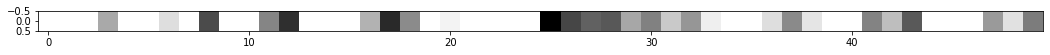

Displaying activation map 7
The activations for the layer is [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


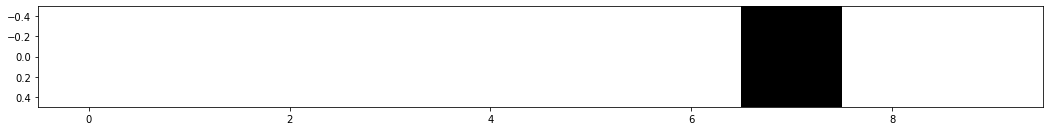

In [38]:
#retrieveing images for num 7

x_test_img_7=img_samenum(x_test_filter,y_test_filter,7)

#test image for 7

test_image(x_test_img_7,677)

[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
(1, 28, 28, 1)
----- activations -----
(1, 26, 26, 32)
(1, 24, 24, 64)
(1, 12, 12, 64)
(1, 12, 12, 64)
(1, 9216)
(1, 50)
(1, 50)
(1, 10)
Displaying activation map 0


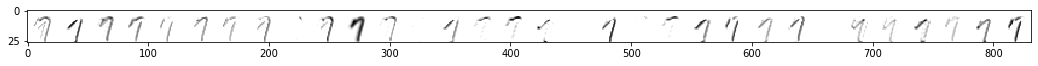

Displaying activation map 1


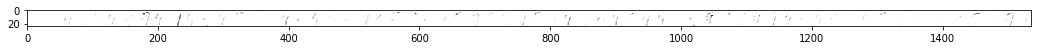

Displaying activation map 2


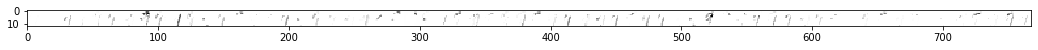

Displaying activation map 3


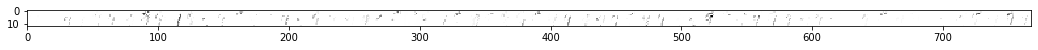

Displaying activation map 4
The activations for the layer is [0. 0. 0. ... 0. 0. 0.]


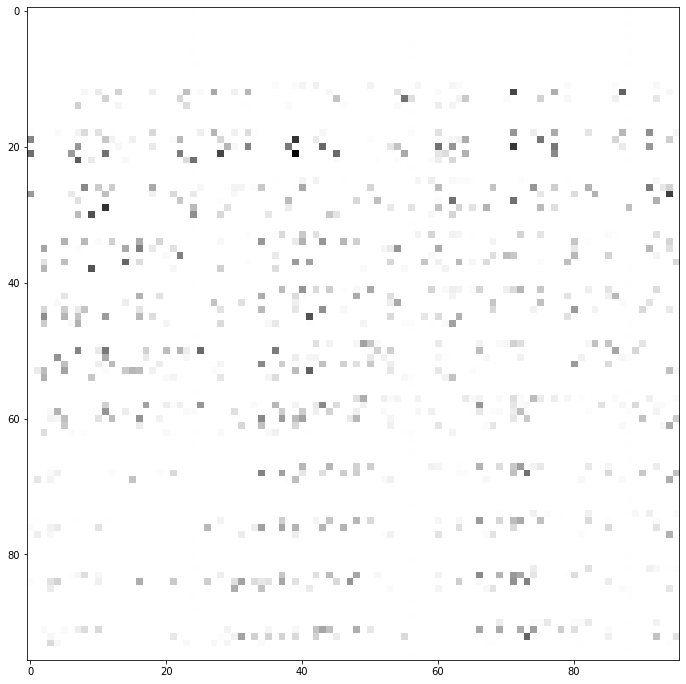

Displaying activation map 5
The activations for the layer is [ 721.3222   1808.0693      0.        720.3695    770.44275   407.70416
    7.142839 2367.855    2403.8464    429.76648  1690.5068   1665.0328
 2402.2227    232.0855   2466.5876     67.01254   642.7582   2110.3171
 1004.0068   1986.6307    327.94873  2804.3997    252.50294   593.568
 1176.611    2171.7085   2191.5308   2411.9746    843.54755   647.06775
 1487.4917      0.        785.7303   1098.2108   1838.7424    285.54163
 1463.1909   1555.7466    743.20074  2555.5747     66.231674 1153.9777
 1239.0038   1944.5134   1305.1339   1202.3152   1892.15     1069.6935
 1215.7339   1243.8735  ]


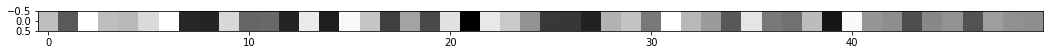

Displaying activation map 6
The activations for the layer is [1063.2974   2845.0908     23.385403    0.       1269.9263    818.1225
   27.33669  3665.0913   3929.0583      0.       2835.1196   2890.965
    0.        468.72467     0.          0.       1280.7208   3453.309
 1733.773    3061.476     581.8936      0.        503.2329    986.6702
    0.       3725.1165      0.          0.       1439.6888   1073.6018
 2498.5408      0.       1073.3959      0.          0.        442.60193
 2338.48        0.          0.          0.        396.4372   2097.1987
    0.       3153.646    2149.221       0.          0.          0.
    0.          0.      ]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).


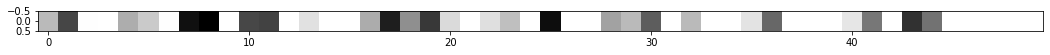

Displaying activation map 7
The activations for the layer is [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


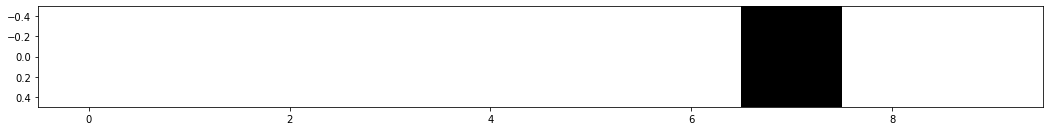

In [39]:
#test image for 7

test_image(x_test_img_7,277)

[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
(1, 28, 28, 1)
----- activations -----
(1, 26, 26, 32)
(1, 24, 24, 64)
(1, 12, 12, 64)
(1, 12, 12, 64)
(1, 9216)
(1, 50)
(1, 50)
(1, 10)
Displaying activation map 0


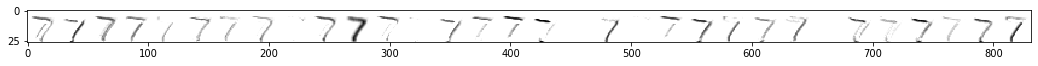

Displaying activation map 1


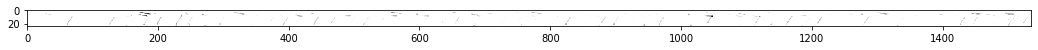

Displaying activation map 2


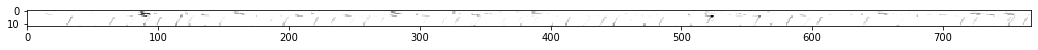

Displaying activation map 3


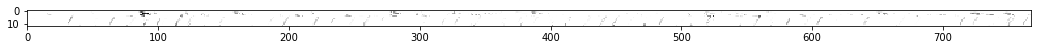

Displaying activation map 4
The activations for the layer is [0. 0. 0. ... 0. 0. 0.]


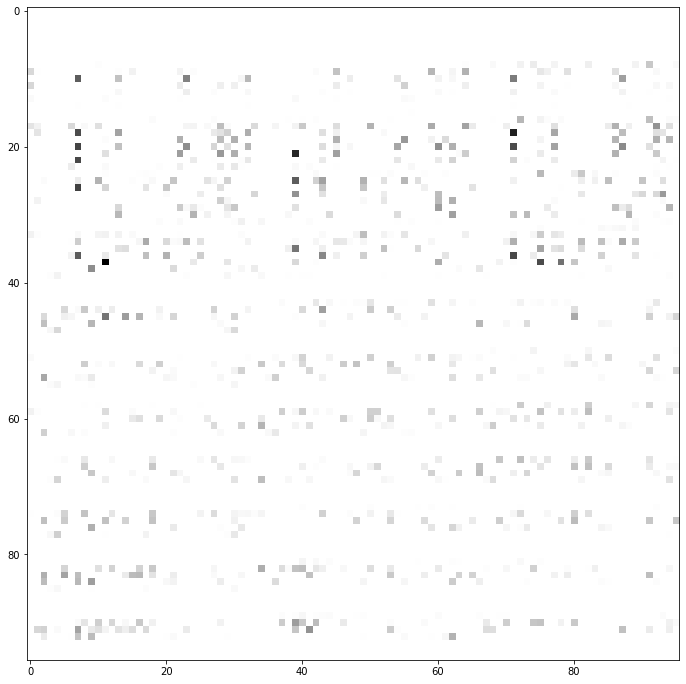

Displaying activation map 5
The activations for the layer is [ 238.3576   1548.2655      0.       1107.16      242.67262    76.745285
    0.       1390.3462   2371.2542    721.666    1435.5538   1647.8025
 2599.1345      0.       2293.0457    799.96814  1136.4882   2680.4707
 1098.4211   2287.8245    211.09566  2617.3293      0.        220.9589
    8.060372 2502.399    2259.3872   2366.2112   1909.182    1060.6196
 1777.2601    614.2801    965.42816   332.97546  2061.5898    342.55423
  434.79388  1612.4636     54.267765 2771.709    1045.0386    955.2684
  693.28705  2066.9058    242.66995     0.       2480.4568   1394.3317
  517.42596  1557.4197  ]


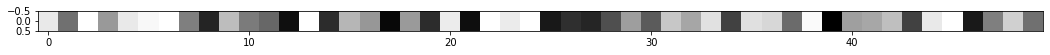

Displaying activation map 6
The activations for the layer is [   0.      2196.0234     0.         0.         0.         0.
    0.         0.      3627.8054     0.      2668.1384     0.
    0.         0.         0.       876.9765     0.         0.
 1947.128      0.       314.40222 3815.5354     0.       150.44707
    0.      4031.0037  3602.2007     0.         0.      1494.7782
 2585.651      0.      1591.937      0.      3526.3901   311.89597
  601.84717 2354.089      0.      3912.347   1751.0818     0.
 1256.9406     0.         0.         0.         0.      2417.5864
  688.2405  2186.4294 ]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).


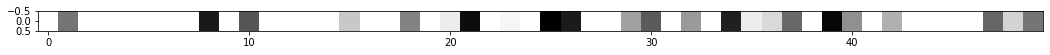

Displaying activation map 7
The activations for the layer is [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


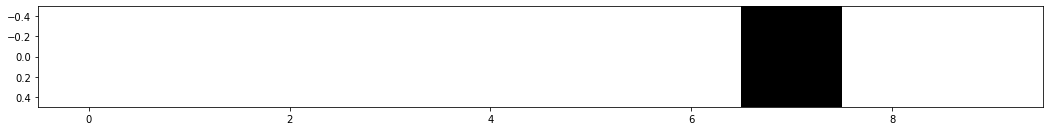

In [40]:
#test image for 7

test_image(x_test_img_7,777)

(974, 28, 28)
(974, 28, 28, 1)
[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
(1, 28, 28, 1)
----- activations -----
(1, 26, 26, 32)
(1, 24, 24, 64)
(1, 12, 12, 64)
(1, 12, 12, 64)
(1, 9216)
(1, 50)
(1, 50)
(1, 10)
Displaying activation map 0


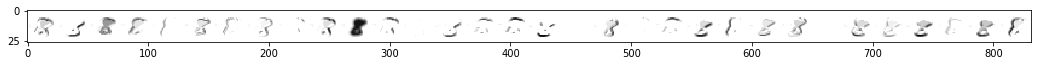

Displaying activation map 1


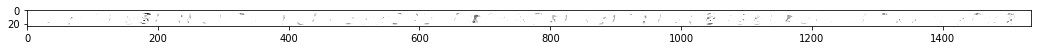

Displaying activation map 2


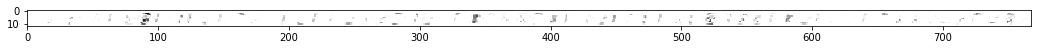

Displaying activation map 3


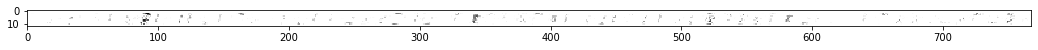

Displaying activation map 4
The activations for the layer is [0. 0. 0. ... 0. 0. 0.]


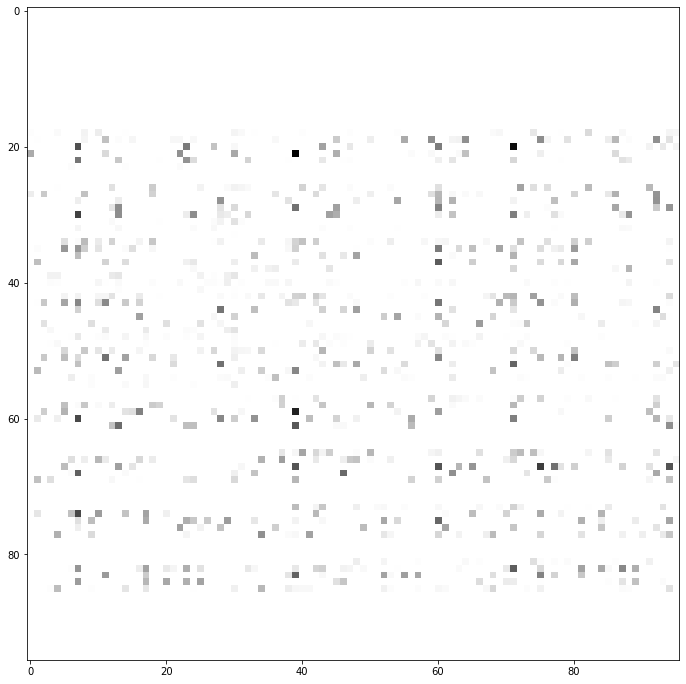

Displaying activation map 5
The activations for the layer is [1174.1238   1558.411     971.45386   963.33246  1305.3959   3513.3252
  431.23615  1763.7264    560.2744   1906.9634   2303.7126   1731.3036
 2078.2542    283.0701    658.8644   2405.2158   2509.617    1918.8022
 2728.2476   1785.4741   2231.8076   2173.5325   1345.0975     35.965874
  429.942    1325.9509    336.83383  1320.7765   2356.0657   1379.1587
 1243.2389   2989.0525   1207.8457   1321.5381    738.5412   1264.1838
 1520.6398    954.2395      0.       1157.9958   2436.022    2817.1045
 2001.637       0.       1990.0558   1163.4785    978.79486  1559.1095
 1629.3389   1313.3955  ]


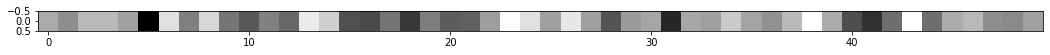

Displaying activation map 6
The activations for the layer is [1864.8209 2547.11   1282.2542    0.     1783.7959 5476.5293  597.9216
 2597.8357 1126.9366 3225.76   3799.7563 2791.3572    0.      600.5909
    0.     3546.6948 3427.2815    0.     4075.3486 2429.536     0.
 3303.9548 2149.0151    0.      731.2374 2003.927   551.7604    0.
 3640.219  2092.774  1602.0553 4328.602     0.        0.     1329.3452
 1995.8597 2069.082  1803.2533    0.        0.        0.        0.
 3007.7205    0.     3071.664  1694.9884 1768.8081 2718.1558 2550.745
    0.    ]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).


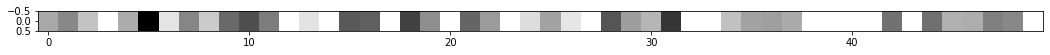

Displaying activation map 7
The activations for the layer is [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


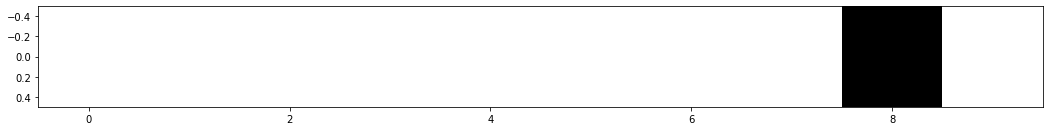

In [41]:
#retrieveing images for num 8

x_test_img_8=img_samenum(x_test_filter,y_test_filter,8)

#test image for 8

test_image(x_test_img_8,777)

[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
(1, 28, 28, 1)
----- activations -----
(1, 26, 26, 32)
(1, 24, 24, 64)
(1, 12, 12, 64)
(1, 12, 12, 64)
(1, 9216)
(1, 50)
(1, 50)
(1, 10)
Displaying activation map 0


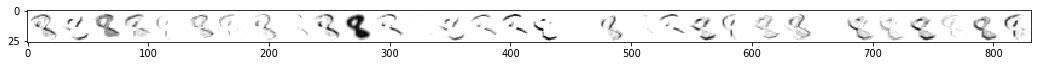

Displaying activation map 1


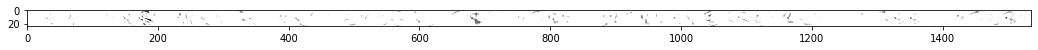

Displaying activation map 2


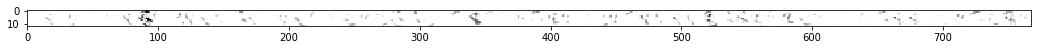

Displaying activation map 3


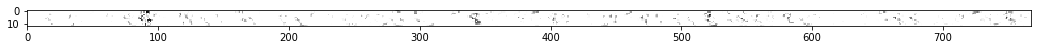

Displaying activation map 4
The activations for the layer is [ 0.       0.       0.      ...  0.      58.60839  0.     ]


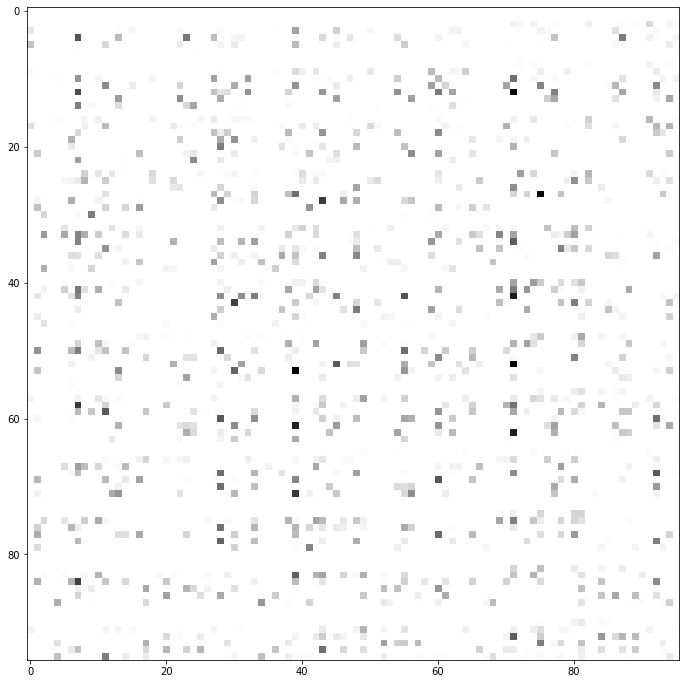

Displaying activation map 5
The activations for the layer is [ 322.1791   326.2387  2188.082    267.63095 2566.3013  2146.4866
  573.7423  1275.018   1050.415   1129.8889  3204.0977  2963.5503
 2140.1133   824.98254 1704.3917  1629.0469  2613.6765  1530.4359
 2960.3933  2376.769   1220.8553  3000.7178   690.7626   875.7816
 1672.8011  2285.4329   342.58    1824.4547  2587.3503   696.63654
 2110.5457  2537.767   1272.2242  1395.4374  1857.9227  1118.8501
 1069.5371   848.78094  763.15155  229.76184 2359.0266  3313.7925
 3723.5066     0.      2625.5205   921.3979  1099.912   2461.2898
 1267.0713  1197.5504 ]


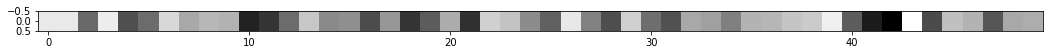

Displaying activation map 6
The activations for the layer is [ 552.8143     0.      2951.0354     0.      3437.652   2977.3123
  663.9532  2133.1182  1918.0074     0.         0.      4428.701
 3191.5276     0.         0.         0.         0.         0.
    0.      3581.436   1404.5221     0.         0.       814.3919
 2656.5332     0.       695.1136  2749.0942     0.       990.943
 2936.6396  3549.2466     0.         0.      2578.0596     0.
 1869.4971  1417.7018     0.       418.61694 3315.9172  5103.1504
    0.         0.      3766.6907  1265.9518  1709.3546     0.
    0.      1610.9977 ]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).


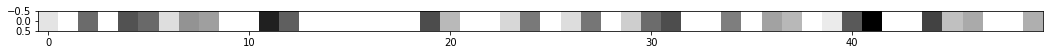

Displaying activation map 7
The activations for the layer is [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


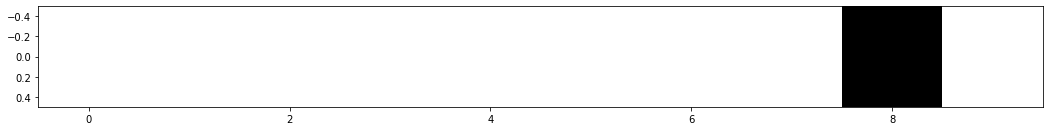

In [42]:
#test image for 8

test_image(x_test_img_8,888)

[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
(1, 28, 28, 1)
----- activations -----
(1, 26, 26, 32)
(1, 24, 24, 64)
(1, 12, 12, 64)
(1, 12, 12, 64)
(1, 9216)
(1, 50)
(1, 50)
(1, 10)
Displaying activation map 0


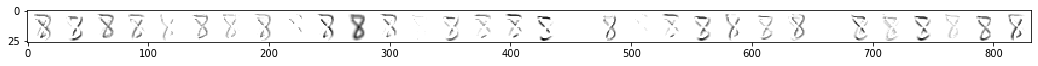

Displaying activation map 1


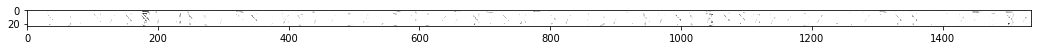

Displaying activation map 2


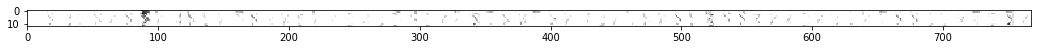

Displaying activation map 3


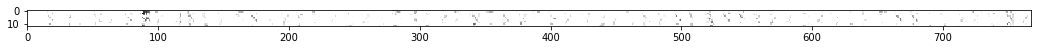

Displaying activation map 4
The activations for the layer is [0. 0. 0. ... 0. 0. 0.]


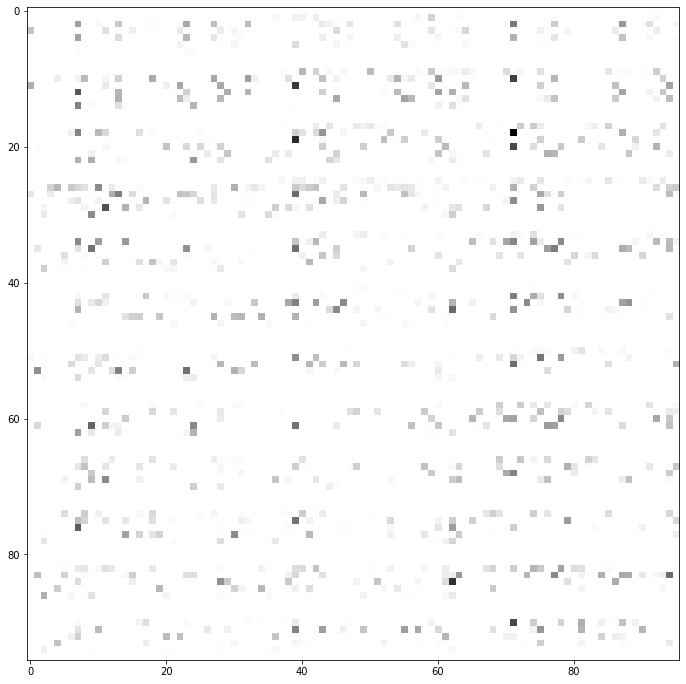

Displaying activation map 5
The activations for the layer is [0.0000000e+00 2.1018311e+02 1.6846396e+03 8.5020593e+02 2.4918772e+03
 2.5607825e+03 4.7919528e+02 1.1044016e+03 3.9637640e+02 1.0506772e+03
 2.0507000e+03 3.2653989e+03 3.1453345e+03 0.0000000e+00 1.5355673e+03
 2.2102480e+03 3.2469419e+03 2.0645642e+03 2.9754502e+03 2.2274863e+03
 1.8801005e+03 3.1189285e+03 0.0000000e+00 9.7037683e+02 3.8118948e+02
 1.4197673e+03 2.4043382e+02 1.0810217e+03 3.2153799e+03 0.0000000e+00
 2.7291790e+03 3.0233704e+03 8.2771527e+02 2.6716039e+00 1.7999252e+03
 9.1351343e+02 0.0000000e+00 1.0492251e+03 0.0000000e+00 9.8385944e+02
 2.8648279e+03 3.9395479e+03 2.8761602e+03 7.4566095e+02 1.8817692e+03
 5.6103275e+01 1.0398937e+03 2.3207866e+03 5.5812561e+02 1.1018616e+03]


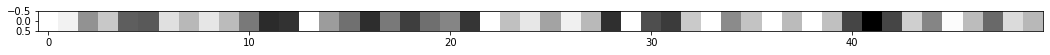

Displaying activation map 6
The activations for the layer is [   0.       417.74228 2770.5798     0.      3826.3442  4169.3486
  503.043   1738.4176     0.      1481.3441  3690.367      0.
    0.         0.      2618.9333  3494.5256  4999.974   3161.4607
    0.         0.      2962.7449     0.         0.      1449.1847
  881.3183  2092.067      0.         0.         0.         0.
 4308.447   4888.8745     0.       338.32303 2865.039   1379.5297
  325.7332  1516.4949     0.         0.      4643.492   6173.962
 5061.0396     0.      3357.4307   138.74593    0.         0.
  613.2105     0.     ]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).


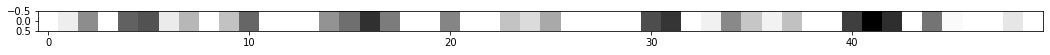

Displaying activation map 7
The activations for the layer is [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


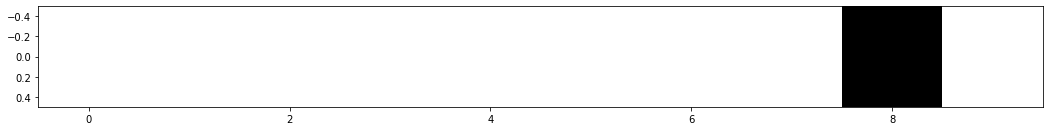

In [43]:
#test image for 8

test_image(x_test_img_8,111)

(1009, 28, 28)
(1009, 28, 28, 1)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
(1, 28, 28, 1)
----- activations -----
(1, 26, 26, 32)
(1, 24, 24, 64)
(1, 12, 12, 64)
(1, 12, 12, 64)
(1, 9216)
(1, 50)
(1, 50)
(1, 10)
Displaying activation map 0


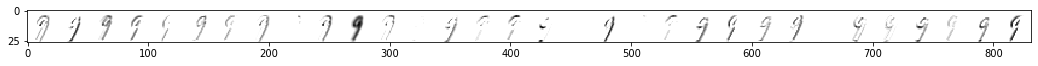

Displaying activation map 1


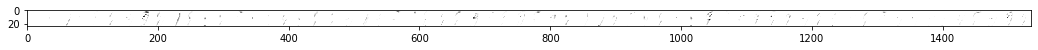

Displaying activation map 2


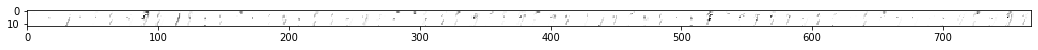

Displaying activation map 3


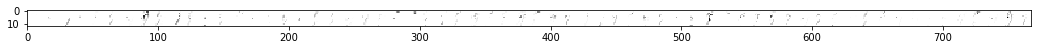

Displaying activation map 4
The activations for the layer is [0. 0. 0. ... 0. 0. 0.]


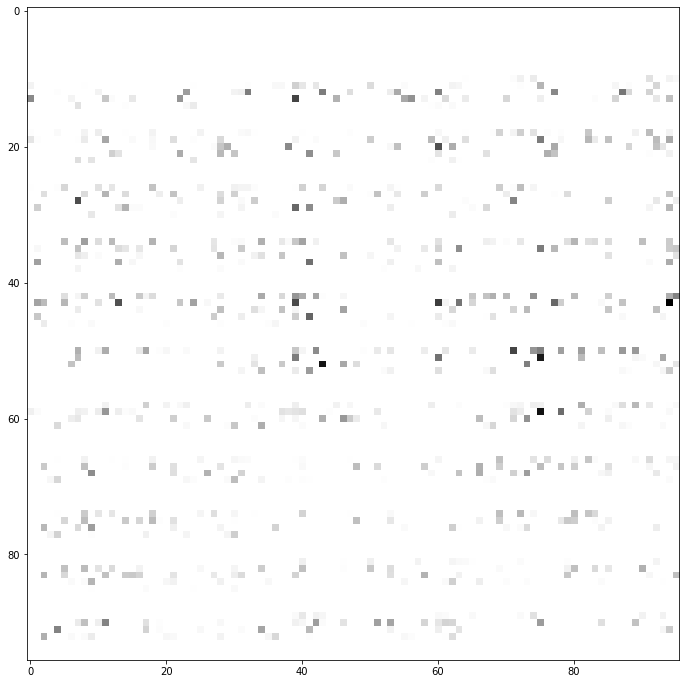

Displaying activation map 5
The activations for the layer is [ 579.2756   819.6315   930.65936  852.9683  1233.8855  1362.632
  626.72186 1426.9613  2131.0225   842.9323  2587.2512  1178.2166
 1024.0652   840.09454 2689.062   1171.8721  1310.2908   790.9225
 2618.0388  2686.3137   617.12317 3426.225    175.00194  646.9176
 1793.9287  2240.5881  1738.2948  1006.8956   957.2577   611.108
 1031.6427   774.7071  2026.6152   972.1316  1765.6832   654.3813
 2372.4795   347.67636 2110.1506  1048.1504   691.2001  2844.875
 2957.4219   690.287   2902.395    984.8614  2140.8438  2252.221
 1280.9148   723.5974 ]


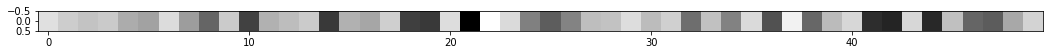

Displaying activation map 6
The activations for the layer is [ 964.3999  1405.5052  1390.628   1383.4537     0.         0.
    0.      2287.8323  3254.4856  1492.1178  3909.4585  1603.194
 1478.1704  1271.5498     0.         0.      2298.3325     0.
 3775.5037  4208.1104     0.      5183.1626     0.      1047.2822
 2847.3438  3390.7004  2611.0264  1421.0884  1407.2515   966.5538
 1583.2047     0.         0.      1445.7987  2510.315      0.
    0.       618.0314     0.      1736.4219   911.28345    0.
    0.       901.99426 4662.5044     0.         0.      3510.9778
 1996.9034     0.     ]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).


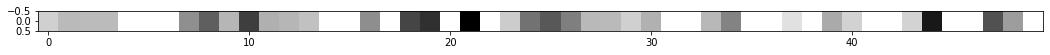

Displaying activation map 7
The activations for the layer is [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


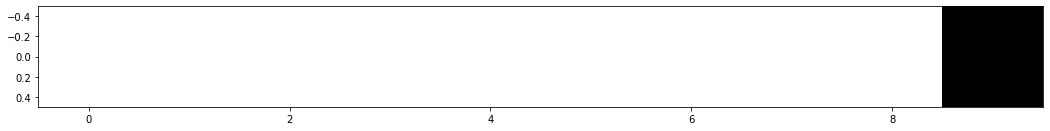

In [44]:
#retrieveing images for num 9

x_test_img_9=img_samenum(x_test_filter,y_test_filter,9)
#test image for 9

test_image(x_test_img_9,777)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
(1, 28, 28, 1)
----- activations -----
(1, 26, 26, 32)
(1, 24, 24, 64)
(1, 12, 12, 64)
(1, 12, 12, 64)
(1, 9216)
(1, 50)
(1, 50)
(1, 10)
Displaying activation map 0


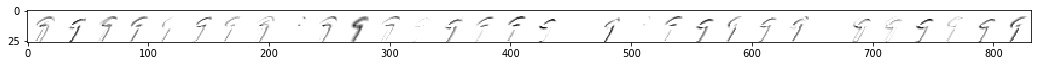

Displaying activation map 1


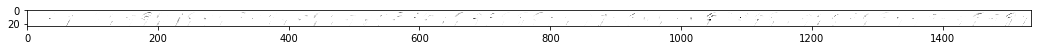

Displaying activation map 2


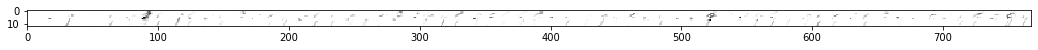

Displaying activation map 3


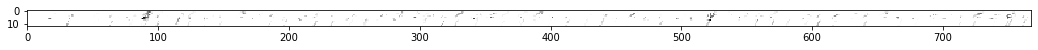

Displaying activation map 4
The activations for the layer is [0. 0. 0. ... 0. 0. 0.]


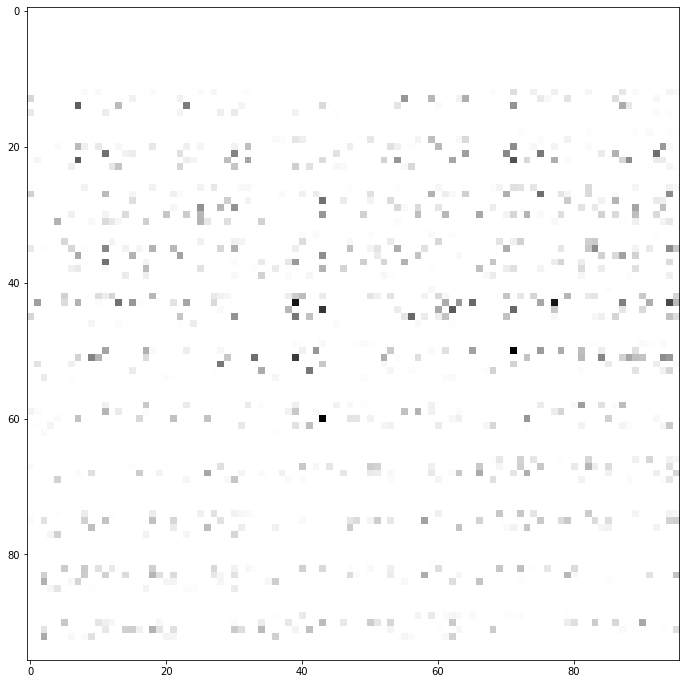

Displaying activation map 5
The activations for the layer is [ 541.4958  1514.2173   234.53079 1307.2457  1135.9087  1765.1437
  340.6989  1885.5985  1856.1146  1355.8707  2605.5605   658.0461
  630.08777  753.6401  2006.9226  1433.6681  1369.4851   668.1366
 3137.4011  2154.2876  1005.6788  2713.408   1006.2799   523.49585
  837.43164 1316.892   1192.4583   552.142    529.50433  960.2511
  603.4788   343.56708 1588.2876   548.27057 1261.889    450.48175
 2073.7473     0.      2319.844    711.72595  636.919   2343.0132
 1980.1354   141.88124 2771.0276   983.73584 2258.0144  1923.7032
 1325.1516   521.97485]


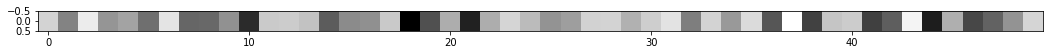

Displaying activation map 6
The activations for the layer is [ 623.25793 2519.0586   430.71063    0.      1840.137   2687.107
  657.4277  2836.962      0.         0.         0.         0.
  737.586    979.1137  3034.9797  2179.4683  2250.295   1053.0382
 4518.3037  3089.8044     0.      4102.147   1743.6124   988.15283
 1320.601   1811.7278     0.       896.2064   935.38745 1119.0414
 1118.9628   782.46313 2182.8733  1178.4375     0.       379.64822
 3069.587      0.      3234.3513  1002.9841     0.      3340.4624
 2672.8506     0.      4013.9285     0.         0.         0.
 1817.9979   841.2626 ]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).


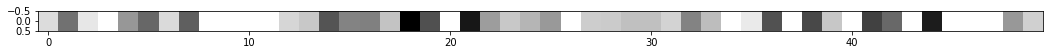

Displaying activation map 7
The activations for the layer is [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


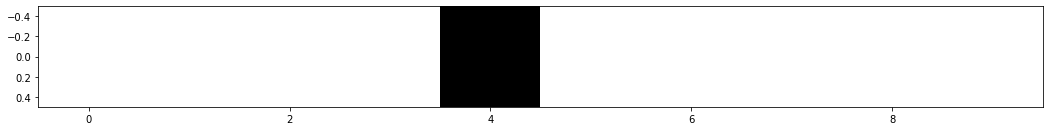

In [45]:
#test image for 9

test_image(x_test_img_9,999)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
(1, 28, 28, 1)
----- activations -----
(1, 26, 26, 32)
(1, 24, 24, 64)
(1, 12, 12, 64)
(1, 12, 12, 64)
(1, 9216)
(1, 50)
(1, 50)
(1, 10)
Displaying activation map 0


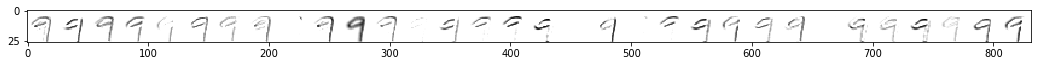

Displaying activation map 1


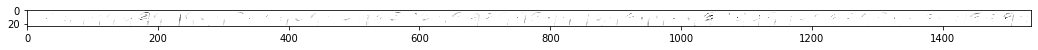

Displaying activation map 2


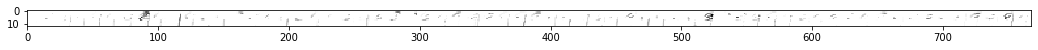

Displaying activation map 3


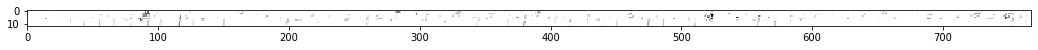

Displaying activation map 4
The activations for the layer is [0. 0. 0. ... 0. 0. 0.]


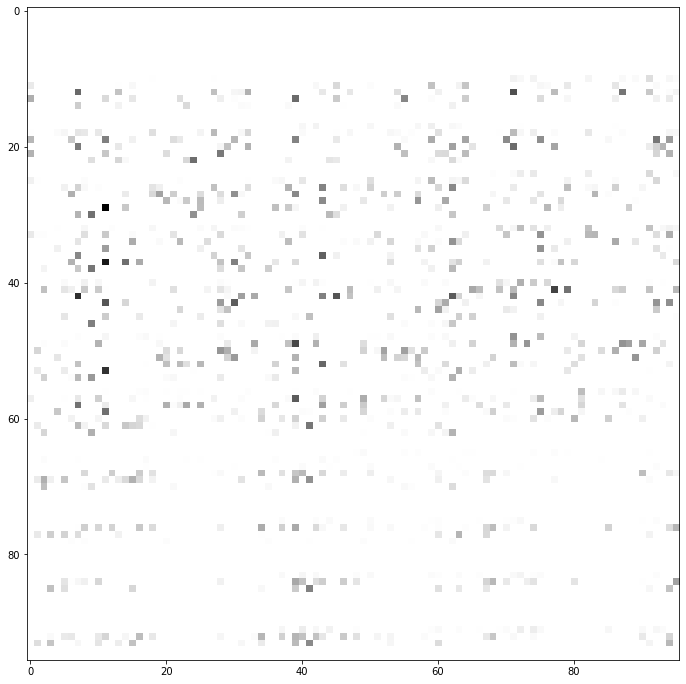

Displaying activation map 5
The activations for the layer is [ 477.31104    487.81485    654.2059     349.7257     813.8062
  801.0858     297.63138    958.34515   2128.5298       0.
 1919.8248    1086.5919    1492.3165       3.3419724 2598.5908
   87.32511    978.9257    1030.7434    2112.6365    2830.4036
  498.5477    3323.465      232.6813     784.58044   1354.4629
 1686.4427    1585.5312    1006.6852     675.2502       0.
  891.0294     332.0668    1859.0531      46.264946  1328.8187
  132.78905   2340.128      858.31494   1709.9393    1482.2834
  481.08768   2636.3596    2835.533      667.6239    2567.886
  413.7741    1591.6437    2102.236      486.92612     36.29142  ]


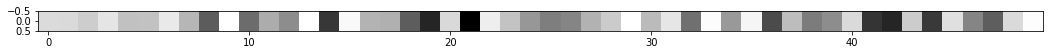

Displaying activation map 6
The activations for the layer is [1008.6774   817.1372   997.7419     0.      1003.1161  1457.4067
    0.         0.      3811.1978     0.      3558.1167  2080.4648
    0.         0.      4310.0503   442.35483 1668.7894     0.
    0.      4775.878      0.         0.       547.7259  1172.1255
 2413.332   3444.845      0.      1715.1084  1665.3121     0.
    0.         0.      3543.406    241.88446 2264.002      0.
 3863.9968     0.      2600.2642  2626.7246   940.8349     0.
    0.      1351.8907     0.       156.14825    0.      3555.6055
 1133.4586     0.     ]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).


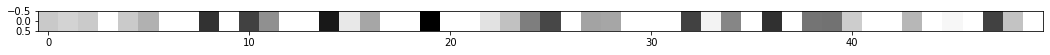

Displaying activation map 7
The activations for the layer is [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


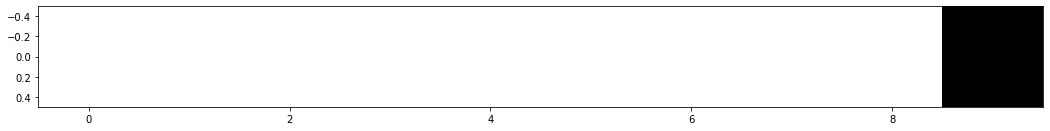

In [46]:
#test image for 9

test_image(x_test_img_9,333)

(28, 28)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
(1, 28, 28, 1)
----- activations -----
(1, 26, 26, 32)
(1, 24, 24, 64)
(1, 12, 12, 64)
(1, 12, 12, 64)
(1, 9216)
(1, 50)
(1, 50)
(1, 10)
Displaying activation map 0


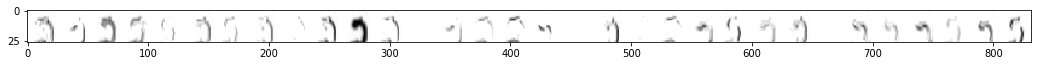

Displaying activation map 1


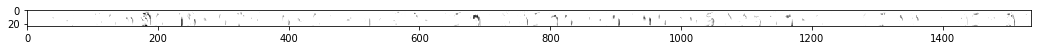

Displaying activation map 2


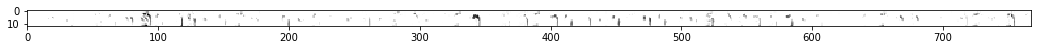

Displaying activation map 3


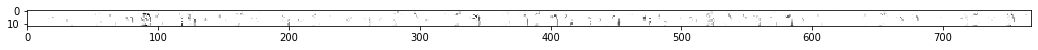

Displaying activation map 4
The activations for the layer is [0.         0.         0.         ... 0.60355115 0.         0.        ]


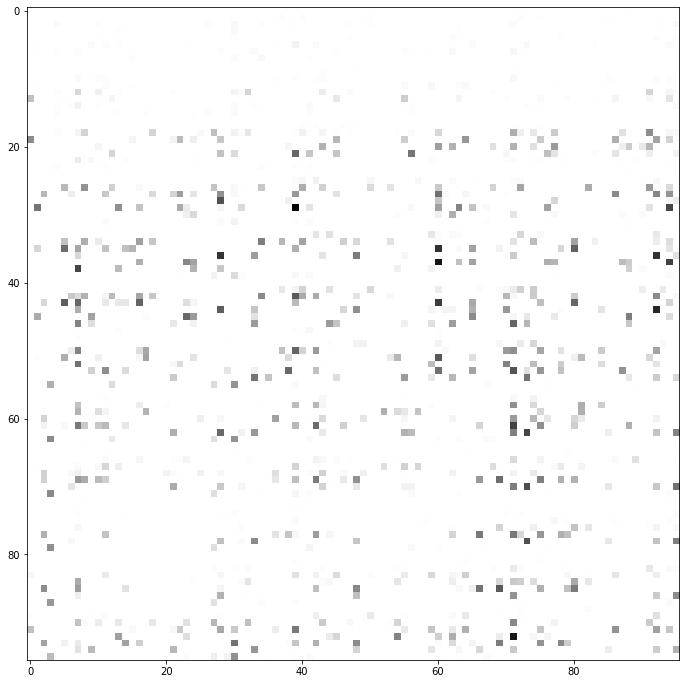

Displaying activation map 5
The activations for the layer is [ 837.4065  1228.099    340.99622  653.8785   566.6029  1135.3062
  707.35156 1248.697   1595.8497   714.5044  1150.012    523.7302
  791.26495  489.01114 1297.0604  1018.8728  1186.1375   856.2181
 1881.7188  1755.363    445.7612  2041.7152   732.72894  847.2024
 1149.939   1506.2821  1056.9714   603.84125  736.08795  292.0665
  848.08954  495.73648 1536.0067   235.70169  955.1745   387.21008
 1831.0823     0.      1368.9371   796.53656  252.49338 2050.905
 1424.5753   276.64014 1534.1787   894.3735  1707.3785  1166.8373
 1064.0245   400.144  ]


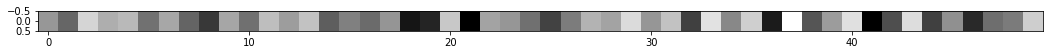

Displaying activation map 6
The activations for the layer is [   0.      2291.1675     0.      1155.2932   628.0219  1868.3453
  943.7209     0.      2546.8652  1088.4178  1889.819    719.6075
    0.       838.2198  2142.4524  1535.6981  1935.0862  1353.2277
    0.      2874.434    823.9333  3200.1797     0.         0.
 1430.4202  2326.6924  1616.1826     0.         0.         0.
 1033.8997     0.      2766.9114    36.94543 1627.1788     0.
 2882.0195     0.      2262.1206  1649.9001     0.         0.
    0.         0.      2457.101      0.      3003.4055  2042.4357
    0.       715.28235]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).


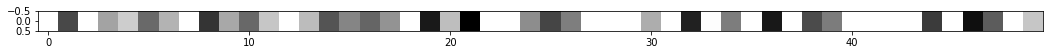

Displaying activation map 7
The activations for the layer is [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


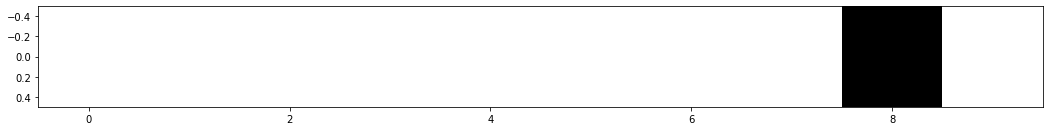

In [47]:
#cropping the image of 2

import cv2
from google.colab.patches import cv2_imshow
im_path = r'/gdrive/My Drive/datasetJPG/img_1.jpg'
img_2 = cv2.imread(im_path)
dim=(28,28)
crop_img_2 = img_2[0:16, 0:28,0:1] # Crop from {x, y, w, h } => {0, 0, 300, 400}

crop_img=cv2.resize(crop_img_2,dim,interpolation=1)

cv2_imshow(crop_img)
cv2.waitKey(0)


crop_test_2array=np.array(crop_img,dtype='float')
print(crop_test_2array.shape)

crop_test_2img=crop_test_2array.reshape(28,28,1)
crop_test_2img.shape

import numpy as np

test_image_crop =np.expand_dims(crop_test_2img, axis=0)
test_image_crop.shape

print(model.predict_proba(test_image_crop,batch_size=1))
print(test_image_crop.shape)

activation_crop=get_activations(model,test_image_crop)
display_activations(activation_crop)

(28, 28)
[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
(1, 28, 28, 1)
----- activations -----
(1, 26, 26, 32)
(1, 24, 24, 64)
(1, 12, 12, 64)
(1, 12, 12, 64)
(1, 9216)
(1, 50)
(1, 50)
(1, 10)
Displaying activation map 0


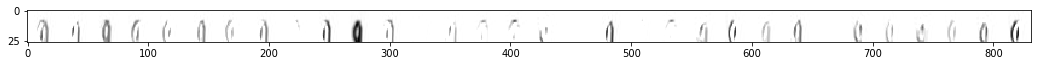

Displaying activation map 1


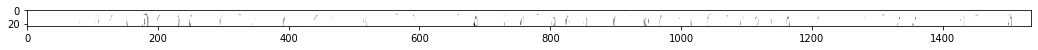

Displaying activation map 2


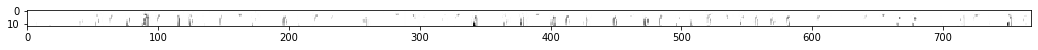

Displaying activation map 3


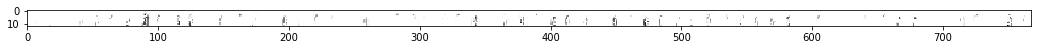

Displaying activation map 4
The activations for the layer is [0. 0. 0. ... 0. 0. 0.]


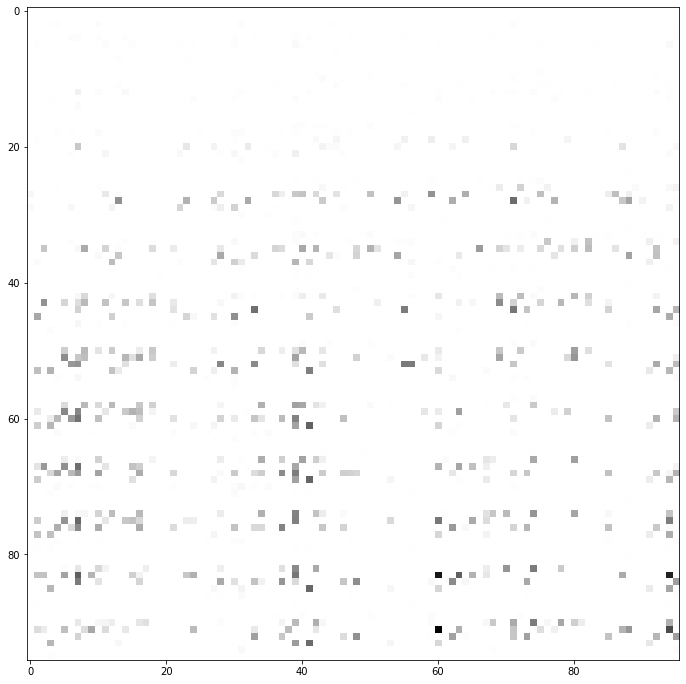

Displaying activation map 5
The activations for the layer is [ 890.67566 1224.9796  1203.4575   351.7213  1745.2793  2195.4043
  413.61832 1662.1123  1094.6602   956.73926 1555.8208  1425.3744
 1587.3832   349.3281   895.54956 2020.3231   900.50604 1575.5148
 1678.2135  1355.1326  1543.194   1258.3556  1363.5447   358.77197
  852.66626 1580.4218   709.2521  1680.2131  1572.9833  1266.4749
 1308.9805  1860.0265   802.96    1194.8108  1279.1796  1426.1415
 1497.7473   623.7075     0.       934.19586 1598.5201  1594.9431
 1469.9297   424.9398   904.0626  1739.0288   771.15344  974.6344
 1585.2025  1138.8153 ]


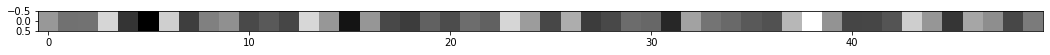

Displaying activation map 6
The activations for the layer is [1379.1637  1753.1829  1960.7152   391.64984    0.      3716.642
  473.82404    0.      1782.6981  1670.1046     0.         0.
    0.       538.9473  1440.7806  3267.4321  1477.1049  2253.304
 2664.5662  1952.3563     0.         0.         0.         0.
 1694.1827  2093.3665  1059.6508     0.      2376.2617  2074.0723
    0.      3128.1719     0.      2045.1827  2033.9094  2241.4102
    0.      1198.2815     0.      1460.1167     0.      2513.9395
    0.         0.         0.      2907.415   1012.40436    0.
 2406.2393     0.     ]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).


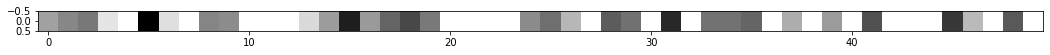

Displaying activation map 7
The activations for the layer is [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


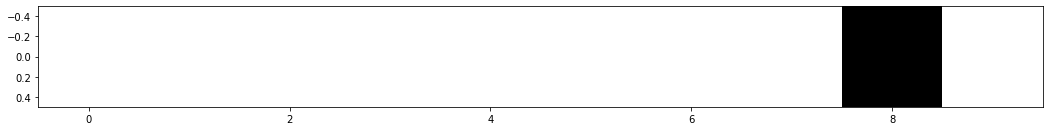

In [48]:
#cropping the image of 9

im_path = r'/gdrive/My Drive/datasetJPG/img_102.jpg'
img = cv2.imread(im_path)
dim=(28,28)
crop_img_9 = img[0:14, 0:28,0:1] # Crop from {x, y, w, h } => {0, 0, 300, 400}

crop_img_9=cv2.resize(crop_img_9,dim,interpolation=1)

cv2_imshow(crop_img_9)
cv2.waitKey(0)

#reshape and resize
crop_test_9array=np.array(crop_img_9,dtype='float')
print(crop_test_9array.shape)

crop_test_9img=crop_test_9array.reshape(28,28,1)
crop_test_9img.shape

test_image_crop_9 =np.expand_dims(crop_test_9img, axis=0)
test_image_crop_9.shape

print(model.predict_proba(test_image_crop_9,batch_size=1))
print(test_image_crop_9.shape)

activation_crop_img2=get_activations(model,test_image_crop_9)
display_activations(activation_crop_img2)

(28, 28)
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
(1, 28, 28, 1)
----- activations -----
(1, 26, 26, 32)
(1, 24, 24, 64)
(1, 12, 12, 64)
(1, 12, 12, 64)
(1, 9216)
(1, 50)
(1, 50)
(1, 10)
Displaying activation map 0


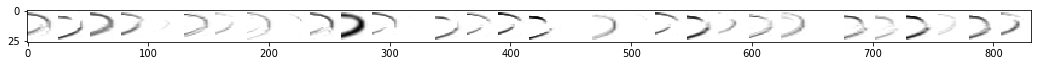

Displaying activation map 1


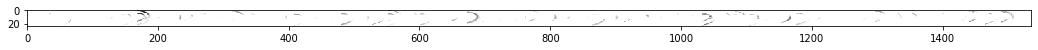

Displaying activation map 2


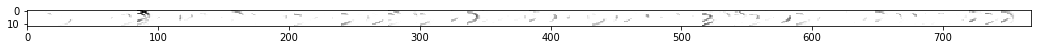

Displaying activation map 3


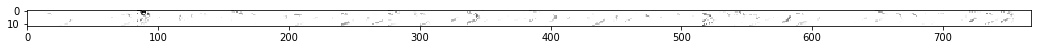

Displaying activation map 4
The activations for the layer is [0. 0. 0. ... 0. 0. 0.]


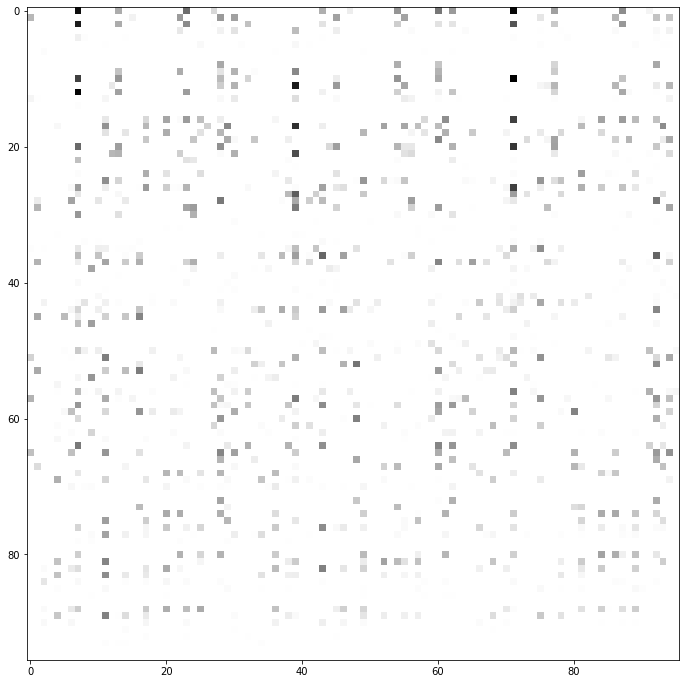

Displaying activation map 5
The activations for the layer is [ 749.7446      0.          0.        883.0592    206.91876    76.64279
  408.70578    75.21398  1493.6781   1710.1786   1531.7256    874.0123
 1494.3424      0.        965.1644      0.        892.17865  2353.7207
 1104.52     1495.2399    345.79523  1572.3188    547.5689    639.5332
  655.7853   2434.4067   1290.8533   1442.3483   2170.107       0.
 1399.6167   1157.8832   1478.6576    663.0234    816.17236    29.703983
  860.0919   1169.3951     77.35871   739.0307   1143.5176   2121.4307
 1407.3812    776.14264   143.04918     0.       1456.7661   1269.2155
    0.       1819.3086  ]


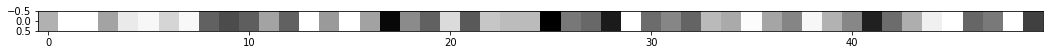

Displaying activation map 6


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).


The activations for the layer is [1223.6825     0.         0.      1216.0175   561.72894    0.
    0.         0.      2370.9758  2623.0005  2216.1357  1597.1511
    0.         0.      1294.7274     0.      1560.7792     0.
    0.         0.       532.5094     0.       510.62518  672.29364
 1245.531      0.         0.      1974.5414  3139.2878     0.
 1852.5079     0.      1673.2595   897.2051  1323.3357   125.65052
  979.0686     0.         0.      1300.3136  1506.5192     0.
 1937.4114  1234.7117   392.5277     0.      2244.839   1925.958
   79.66446 2631.4216 ]


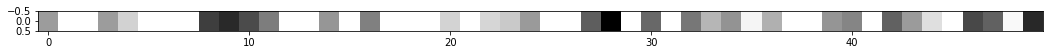

Displaying activation map 7
The activations for the layer is [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


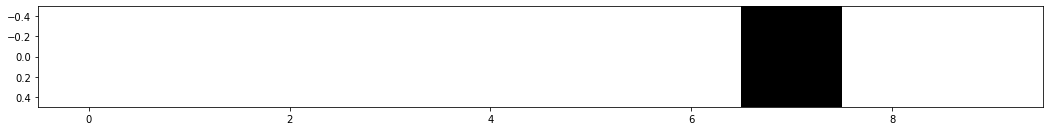

In [49]:
#cropping the right side of 0

im_path = r'/gdrive/My Drive/datasetJPG/img_109.jpg'
img = cv2.imread(im_path)
dim=(28,28)
crop_img_0 = img[0:28, 15:28,0:1] # Crop from {x, y, w, h } 

crop_img_0=cv2.resize(crop_img_0,dim,interpolation=1)

cv2_imshow(crop_img_0)
cv2.waitKey(0)

#reshape and resize
crop_test_0array=np.array(crop_img_0,dtype='float')
print(crop_test_0array.shape)

crop_test_0img=crop_test_0array.reshape(28,28,1)
crop_test_0img.shape

test_image_crop_0 =np.expand_dims(crop_test_0img, axis=0)
test_image_crop_0.shape

print(model.predict_proba(test_image_crop_0,batch_size=1))
print(test_image_crop_0.shape)

activation_crop_img3=get_activations(model,test_image_crop_0)
display_activations(activation_crop_img3)

In [0]:
def test_crop_image(path,x,y,w,h):
  img = cv2.imread(path)
  dim=(28,28)
  crop_img = img[x:y, w:h,0:1] # Crop from {x, y, w, h }

  crop_img=cv2.resize(crop_img,dim,interpolation=1)

  cv2_imshow(crop_img)

  #reshape and resize

  crop_test_array=np.array(crop_img,dtype='float')
  print(crop_test_array.shape)

  crop_test_img=crop_test_array.reshape(28,28,1)
  crop_test_img.shape

  test_image_crop =np.expand_dims(crop_test_img, axis=0)
  test_image_crop.shape

  print(model.predict_proba(test_image_crop,batch_size=1))
  print(test_image_crop.shape)

  activation_crop_img=get_activations(model,test_image_crop)
  display_activations(activation_crop_img)

(28, 28)
[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
(1, 28, 28, 1)
----- activations -----
(1, 26, 26, 32)
(1, 24, 24, 64)
(1, 12, 12, 64)
(1, 12, 12, 64)
(1, 9216)
(1, 50)
(1, 50)
(1, 10)
Displaying activation map 0


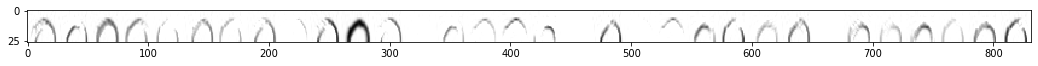

Displaying activation map 1


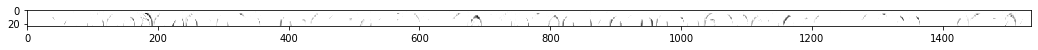

Displaying activation map 2


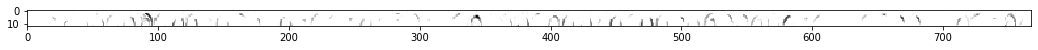

Displaying activation map 3


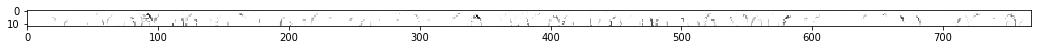

Displaying activation map 4
The activations for the layer is [  0.        0.        0.      ...   0.      217.23094   0.     ]


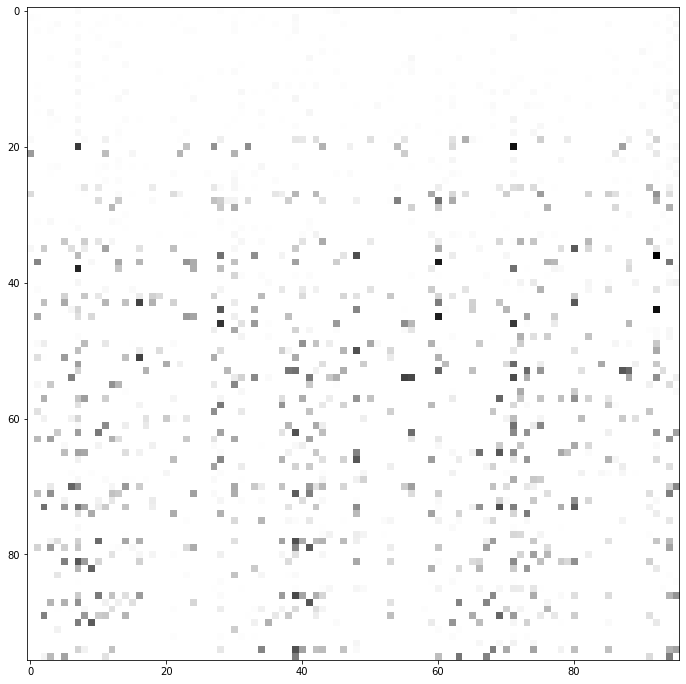

Displaying activation map 5
The activations for the layer is [ 911.4063   770.4321   656.01337  190.03944  740.42145 1268.0424
    0.      1021.80865  813.34686 1063.5226  1373.2069  1421.3905
 1334.1686     0.       544.9329   913.3186  1143.4575  1025.122
 1157.8256  1140.5931   961.5729  1393.4657   861.7251   256.20865
  573.3678   808.0082   661.15546  540.2702  1034.8184   925.1089
  714.25446 1085.1582   502.1002   366.97415  402.47546  904.51324
  937.11993  801.03314   69.6054  1101.3967   736.08563 1650.1139
 1148.4958     0.      1009.5411  1224.1198   271.72003  827.87494
  817.32135  739.14526]


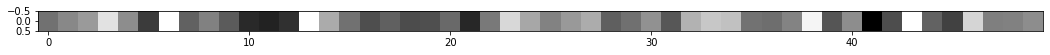

Displaying activation map 6
The activations for the layer is [   0.         0.      1006.672      0.      1252.2478  2194.9133
    0.      1509.3143  1144.7579     0.      2184.3853  2183.9048
    0.         0.       749.4786  1457.7958     0.         0.
 1890.2462  1803.9558     0.         0.         0.       522.92883
  906.9368     0.         0.         0.         0.      1372.079
    0.         0.       940.49646  507.3969   614.05164    0.
 1433.87       0.       128.87282    0.      1446.3577     0.
    0.         0.      1736.0222  1694.5989   615.1428  1355.62
 1285.7124  1218.9673 ]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).


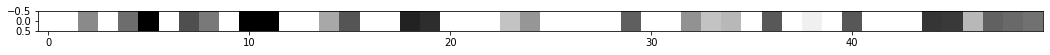

Displaying activation map 7
The activations for the layer is [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


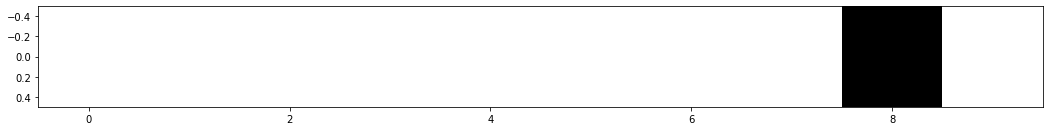

In [51]:
#cropping the lower half image 0

path=r'/gdrive/My Drive/datasetJPG/img_109.jpg'

test_crop_image(path,0,13,0,28)

(28, 28)
[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
(1, 28, 28, 1)
----- activations -----
(1, 26, 26, 32)
(1, 24, 24, 64)
(1, 12, 12, 64)
(1, 12, 12, 64)
(1, 9216)
(1, 50)
(1, 50)
(1, 10)
Displaying activation map 0


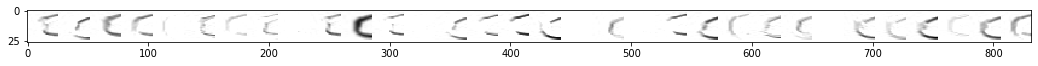

Displaying activation map 1


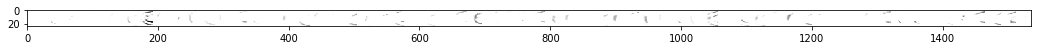

Displaying activation map 2


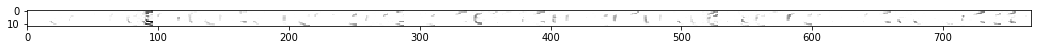

Displaying activation map 3


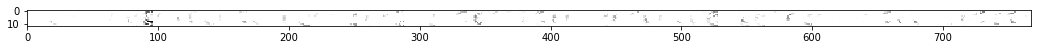

Displaying activation map 4
The activations for the layer is [0. 0. 0. ... 0. 0. 0.]


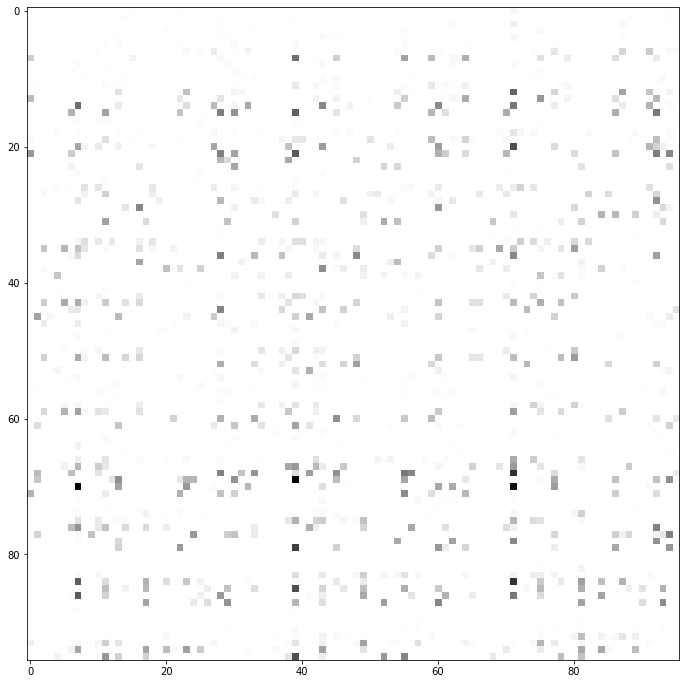

Displaying activation map 5
The activations for the layer is [6.54796387e+02 1.00495502e+03 9.08159546e+02 1.86079369e+01
 1.28908582e+03 1.82417371e+03 0.00000000e+00 1.75239380e+03
 6.80219177e+02 1.31264905e+03 1.54663562e+03 2.01700293e+03
 8.35549377e+02 1.02049414e+03 1.42210175e+02 1.18617090e+03
 9.84899658e+02 9.06450256e+02 1.33702588e+03 1.28817505e+02
 5.78930359e+02 1.21191199e+03 7.63385986e+02 0.00000000e+00
 1.79474634e+03 1.26405640e+03 2.17312183e+01 1.63664600e+03
 1.53564246e+03 9.25661560e+02 9.71578613e+02 1.48392651e+03
 0.00000000e+00 1.61535852e+03 4.23220673e+02 4.13973114e+02
 6.83013245e+02 6.65253235e+02 3.22320038e+02 1.56980348e+00
 1.40962708e+03 1.51024377e+03 1.60274292e+03 0.00000000e+00
 1.52005823e+03 1.28597034e+03 4.66132111e+02 6.23826111e+02
 1.57380664e+03 1.20887268e+03]


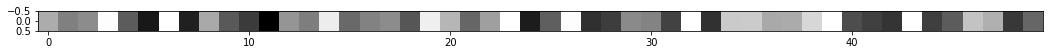

Displaying activation map 6
The activations for the layer is [   0.      1440.1575  1331.4583     0.      1868.7566     0.
    0.      2550.889      0.      2259.2197     0.      3039.2732
 1001.26746    0.       123.48209 1914.3046  1272.8015     0.
    0.       146.72961  732.5632     0.      1462.7384     0.
 3106.0576  2296.4255     0.         0.      2712.356   1604.4371
 1618.5424  2462.7478     0.      2889.1035   599.6031     0.
 1237.0604     0.       481.83267    0.      2465.5974  2258.5461
 2722.1643     0.      2277.717   1947.9646     0.       804.2826
    0.      1983.4131 ]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).


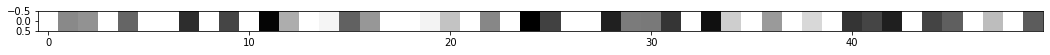

Displaying activation map 7
The activations for the layer is [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


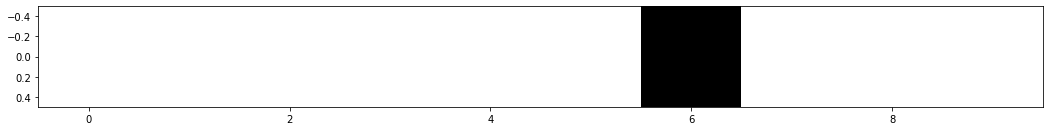

In [55]:
#cropping the right half image 0

path=r'/gdrive/My Drive/datasetJPG/img_109.jpg'

test_crop_image(path,0,28,0,13)

(28, 28)
[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]
(1, 28, 28, 1)
----- activations -----
(1, 26, 26, 32)
(1, 24, 24, 64)
(1, 12, 12, 64)
(1, 12, 12, 64)
(1, 9216)
(1, 50)
(1, 50)
(1, 10)
Displaying activation map 0


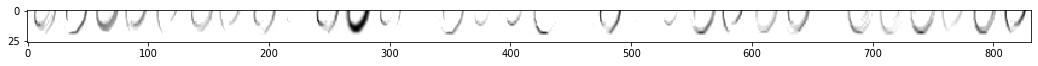

Displaying activation map 1


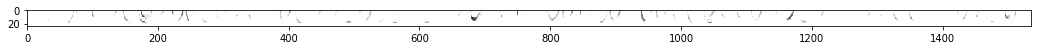

Displaying activation map 2


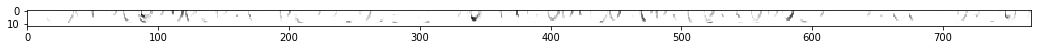

Displaying activation map 3


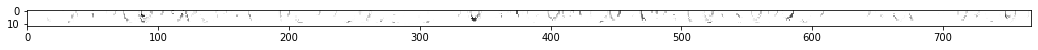

Displaying activation map 4
The activations for the layer is [0. 0. 0. ... 0. 0. 0.]


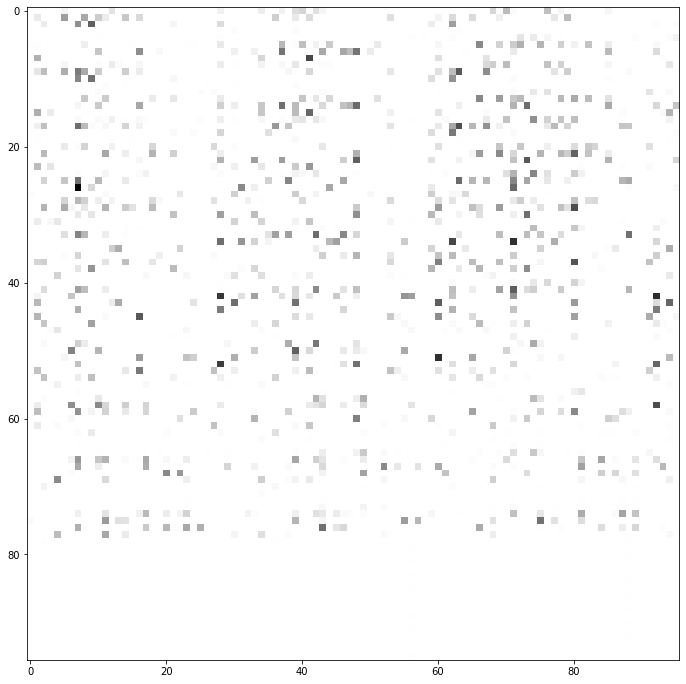

Displaying activation map 5
The activations for the layer is [ 380.82504 1084.8215   847.45     699.237   1962.7965  1750.6881
   80.69697 1762.8679   690.9332   434.71857 1037.6687     0.
  297.9165     0.      1717.3978  1747.7953  1335.3041     0.
 1683.6581  2030.4324  1521.8336  1552.1943  1306.2954   955.768
  804.765    314.64664  549.901   1172.1416   386.68613  454.4816
  822.1225   646.51855  825.3826  1795.6632   506.83167  868.9104
 2352.755      0.      1135.869    602.60785 1057.7385   672.7025
 1842.7687     0.      2100.5884  1716.5212   425.2462   966.79254
  409.4881     0.     ]


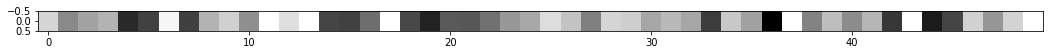

Displaying activation map 6
The activations for the layer is [ 694.2648  1737.433   1036.8684   925.33936 2542.792   2550.7139
  105.70833    0.      1035.1924   956.2073  1744.1068     0.
    0.         0.      2372.9207     0.         0.         0.
 2239.4065     0.         0.      2139.8953     0.      1284.2462
 1459.007    589.3375     0.         0.         0.         0.
 1229.7587  1028.3336  1387.5271     0.         0.         0.
 3595.53       0.         0.       694.03284 1625.421      0.
    0.         0.         0.         0.       686.2752  1335.9176
    0.         0.     ]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).


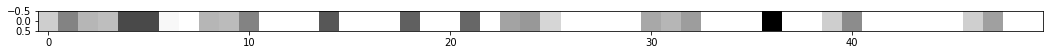

Displaying activation map 7
The activations for the layer is [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


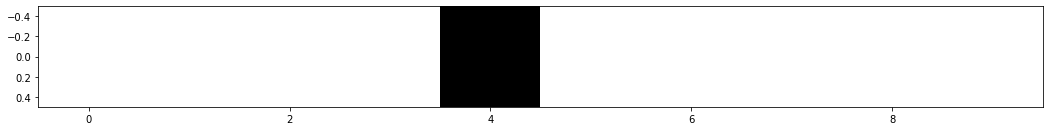

In [56]:
#cropping the lower half image 0

path=r'/gdrive/My Drive/datasetJPG/img_109.jpg'

test_crop_image(path,15,28,0,28)

(28, 28)
[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
(1, 28, 28, 1)
----- activations -----
(1, 26, 26, 32)
(1, 24, 24, 64)
(1, 12, 12, 64)
(1, 12, 12, 64)
(1, 9216)
(1, 50)
(1, 50)
(1, 10)
Displaying activation map 0


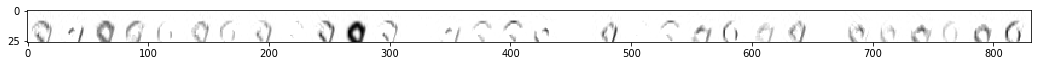

Displaying activation map 1


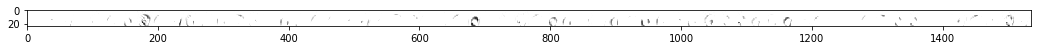

Displaying activation map 2


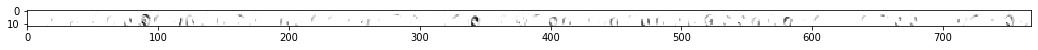

Displaying activation map 3


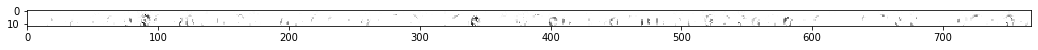

Displaying activation map 4
The activations for the layer is [0.        0.        0.        ... 0.        1.9300121 0.       ]


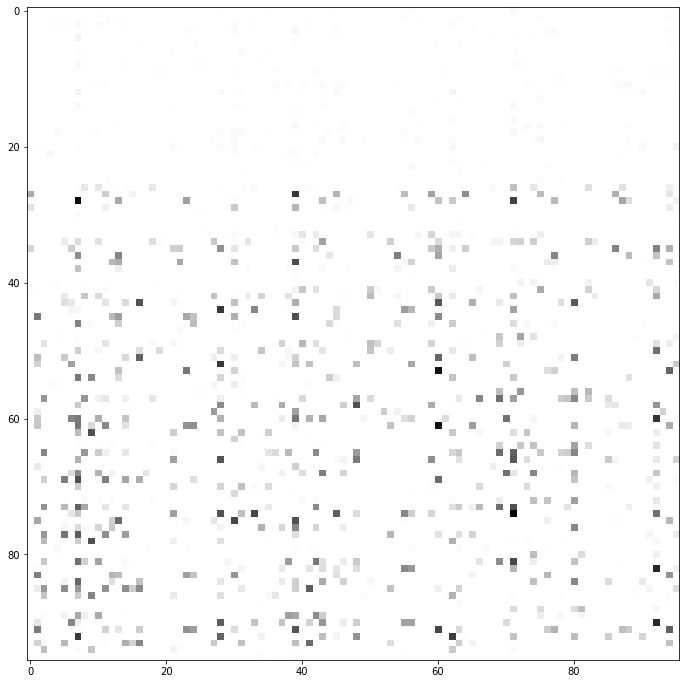

Displaying activation map 5
The activations for the layer is [ 376.48398  1409.5118    648.4297    617.0117   1096.1106   1917.498
   57.49604  1214.712     284.54465  1167.1138   1243.7214   1207.3254
 1420.5505      0.        776.4027   1760.6996   1103.0182   1663.5563
 1842.4846   1093.6257   1387.3418   1587.1832   1565.258     449.02765
  421.67868  1027.5748    416.96585   888.26996  1467.9303    930.3774
 1559.7389   1760.1993    518.51086   671.4611    344.36948   804.31946
 1459.0496    496.32004     8.105584  777.52496  1327.1024   2216.6064
 1409.4585      0.        941.236    1040.7472    403.4317    658.6608
  715.45404   918.0878  ]


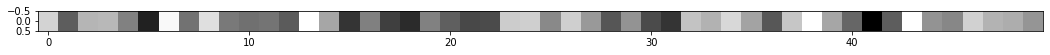

Displaying activation map 6
The activations for the layer is [ 998.73584 2013.7214  1169.0813   916.8286     0.         0.
    0.      1873.0481   277.05377 2202.7756     0.      1773.8794
 2150.6694     0.         0.         0.      1763.8287     0.
 3013.3096  1586.5323     0.         0.      2145.4092   550.89355
  567.1671     0.       382.47363  968.40186 2111.8425     0.
    0.         0.         0.         0.       502.29742 1356.1493
    0.         0.         0.         0.      1965.6189  3566.4216
    0.         0.      1539.9056  1464.3025     0.      1169.5796
 1319.5797  1137.3794 ]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).


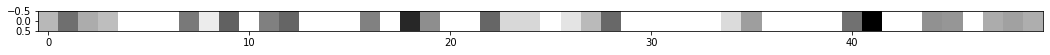

Displaying activation map 7
The activations for the layer is [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


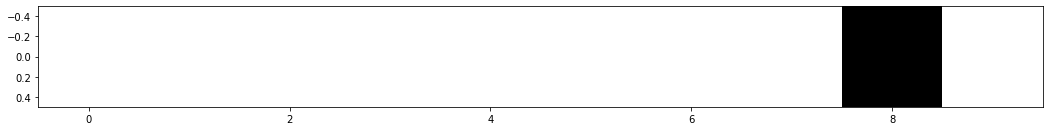

In [57]:
#cropping the lower half image 8

path=r'/gdrive/My Drive/datasetJPG/img_127.jpg'

test_crop_image(path,0,13,0,28)

(28, 28)
[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
(1, 28, 28, 1)
----- activations -----
(1, 26, 26, 32)
(1, 24, 24, 64)
(1, 12, 12, 64)
(1, 12, 12, 64)
(1, 9216)
(1, 50)
(1, 50)
(1, 10)
Displaying activation map 0


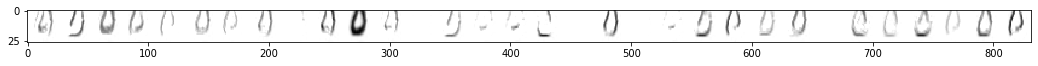

Displaying activation map 1


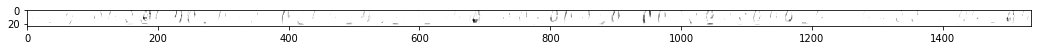

Displaying activation map 2


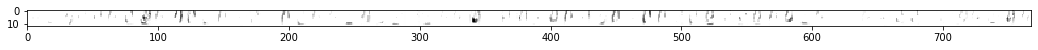

Displaying activation map 3


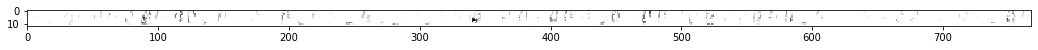

Displaying activation map 4
The activations for the layer is [0.         0.         0.         ... 0.29978186 0.         0.3986693 ]


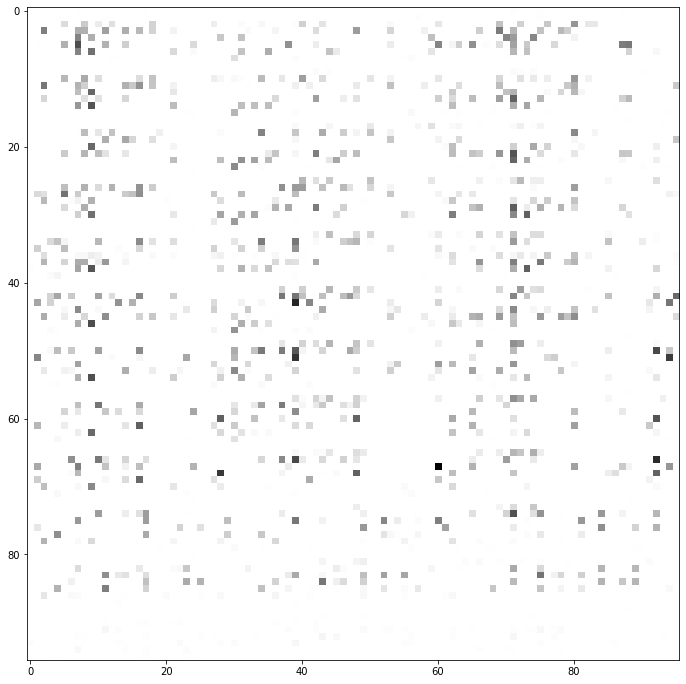

Displaying activation map 5
The activations for the layer is [ 787.8584   1584.6842     36.53191   258.37308  1631.0605   1842.6677
    0.       2260.2058    247.61287  2423.3264   2736.676    1443.4426
 1322.6354      0.       1749.6857   1600.0137   1191.1552   1364.8197
 1125.8534   1739.8813   1740.2616   1994.4476   2541.9175    925.1694
 1714.1102    565.1948      0.       1967.1559    711.91583  1814.6068
  920.0393   1147.0182    529.6659   2155.0222     24.876139 1436.8485
 2267.271    1123.8776    588.4646   1407.9694   1838.1954   1516.0114
 2511.2893      0.       1722.9287   2371.3408    101.23858   290.1774
 2138.1326    580.412   ]


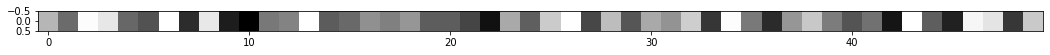

Displaying activation map 6
The activations for the layer is [   0.         0.       359.65714  452.8641  2702.0579     0.
    0.      3815.4482     0.      3842.9023  4131.427      0.
    0.         0.         0.      2590.9255  1980.4132  1901.6165
    0.         0.      2806.9724  2803.902      0.         0.
 2584.0422   748.63043    0.      2940.5369  1260.6083  3036.2441
    0.         0.         0.      3494.7363     0.      2283.38
    0.      1562.7401     0.      2005.749   2998.6611     0.
    0.         0.      2728.9653  3631.5574     0.       307.2008
    0.      1000.0758 ]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).


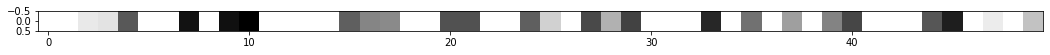

Displaying activation map 7
The activations for the layer is [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


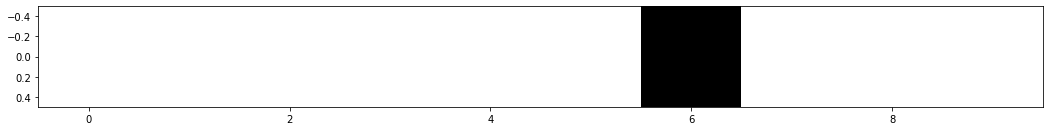

In [58]:
#cropping the upper half image 8

path=r'/gdrive/My Drive/datasetJPG/img_127.jpg'

test_crop_image(path,15,28,0,28)

(28, 28)
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
(1, 28, 28, 1)
----- activations -----
(1, 26, 26, 32)
(1, 24, 24, 64)
(1, 12, 12, 64)
(1, 12, 12, 64)
(1, 9216)
(1, 50)
(1, 50)
(1, 10)
Displaying activation map 0


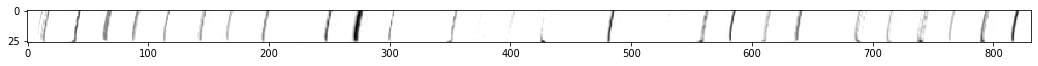

Displaying activation map 1


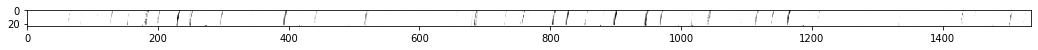

Displaying activation map 2


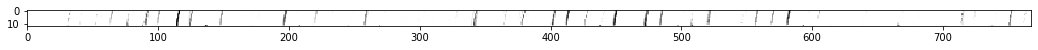

Displaying activation map 3


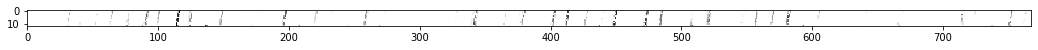

Displaying activation map 4
The activations for the layer is [0. 0. 0. ... 0. 0. 0.]


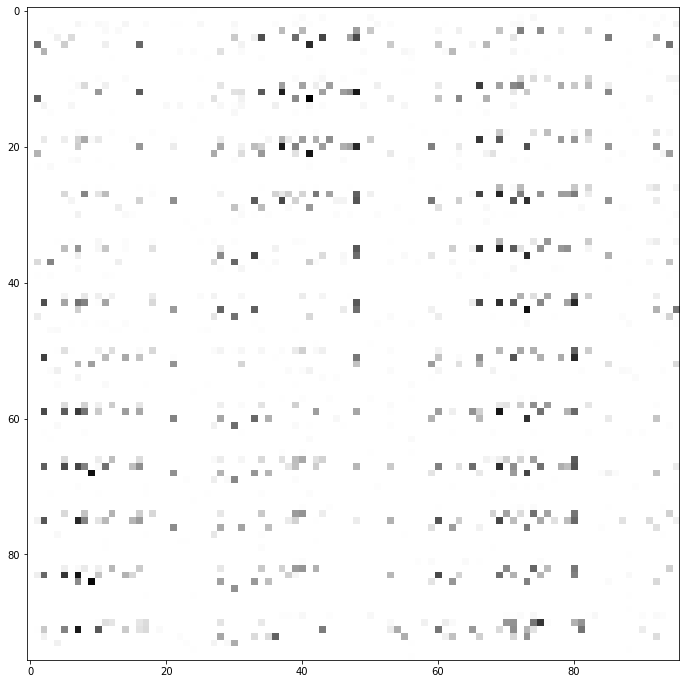

Displaying activation map 5
The activations for the layer is [1403.6073  1176.4126  1751.9974   519.4381  2470.7417  2212.9893
 1174.7797  2179.0671  1975.4194   796.785   1255.5889  1743.0828
 1054.0304  1458.6643  1121.3823  2573.5222  1095.3364   933.2283
 1648.7759  1170.974   1001.0808  1446.5507  1150.9568   244.42412
 1823.6144  2032.4022  1311.837   2559.607   1583.9921  1766.6006
 1504.4481  2293.49     724.6714  2237.8752  2001.3394  1450.127
 1635.9152   295.776    271.83414  541.8916  1497.1788  1426.7157
 1194.4877   679.90985 1429.72    2436.0356  1056.009   1296.9056
 2574.7932  1727.7216 ]


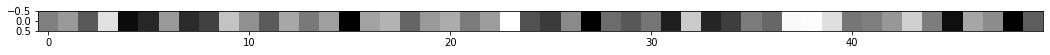

Displaying activation map 6
The activations for the layer is [   0.      1879.0785  2503.7705     0.      3444.842   3288.5818
 1512.6451  3328.5205  3126.1008     0.      2143.2363     0.
    0.      2070.2195  1957.3624     0.      1652.2712  1726.8219
 2351.1836  1958.6056     0.         0.      1936.8567   441.23453
 2671.4517     0.      2082.3076  3985.693      0.      2796.3997
 2213.9116     0.         0.      3248.6758  3117.0107  2321.9626
 2331.8545   754.67914  550.87836    0.      2340.597   2269.5513
    0.      1296.6313  2192.0974     0.         0.      2014.5613
 3756.1555  2670.8865 ]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).


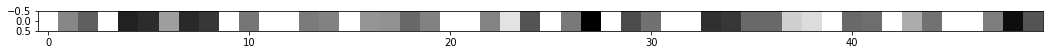

Displaying activation map 7
The activations for the layer is [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


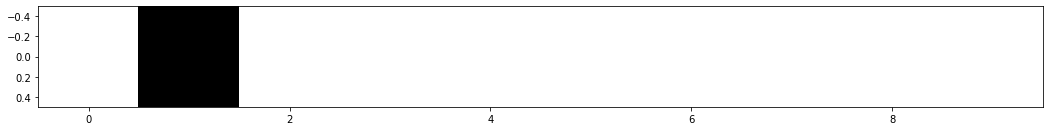

In [59]:
#cropping the upper half image 7

path=r'/gdrive/My Drive/datasetJPG/img_128.jpg'

test_crop_image(path,12,28,0,28)

(28, 28)
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
(1, 28, 28, 1)
----- activations -----
(1, 26, 26, 32)
(1, 24, 24, 64)
(1, 12, 12, 64)
(1, 12, 12, 64)
(1, 9216)
(1, 50)
(1, 50)
(1, 10)
Displaying activation map 0


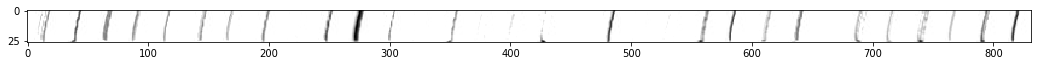

Displaying activation map 1


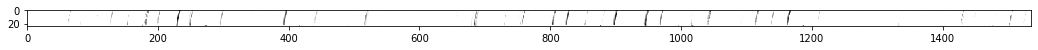

Displaying activation map 2


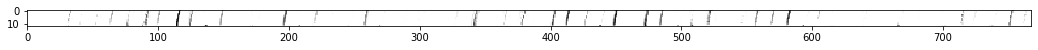

Displaying activation map 3


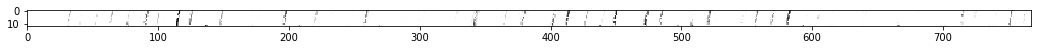

Displaying activation map 4
The activations for the layer is [0. 0. 0. ... 0. 0. 0.]


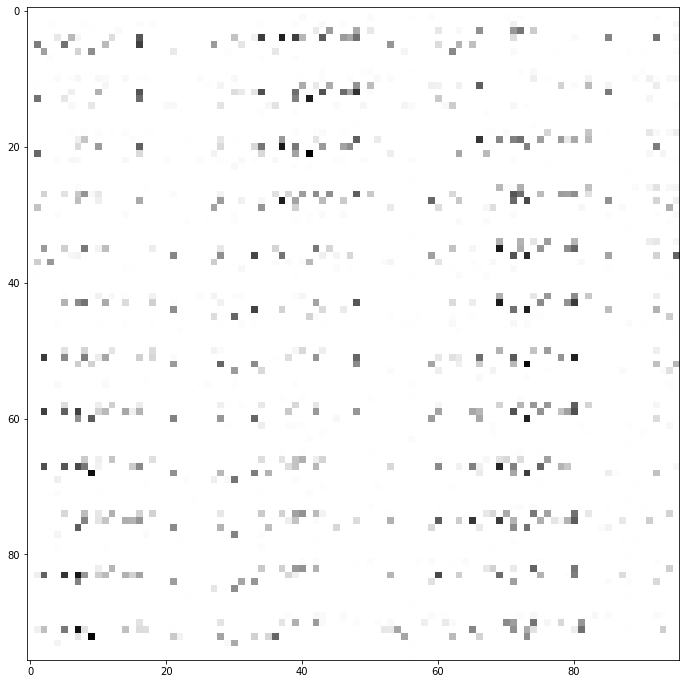

Displaying activation map 5
The activations for the layer is [1468.6189  1116.0093  1596.7097   399.96582 2286.357   2205.8184
 1118.6836  2140.2405  1891.2148   957.6013  1426.5879  1899.2681
 1175.966   1306.7297  1098.9695  2535.5723  1161.6647  1149.0638
 1645.9276  1165.6061  1021.93115 1400.653   1264.9225   248.75246
 1648.7673  2128.264   1252.1287  2463.6626  1749.9445  1976.2351
 1486.5636  2317.325    785.3784  2043.032   2023.9598  1577.3062
 1471.7206   480.3776   155.56384  638.9339  1558.0148  1517.6168
 1267.7583   672.6508  1319.5769  2369.9336  1037.4481  1304.8359
 2584.9604  1843.3855 ]


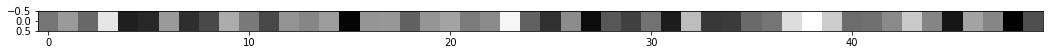

Displaying activation map 6
The activations for the layer is [2152.7024     0.      2343.4714     0.         0.      3284.628
    0.      3056.1887     0.      1424.3585     0.         0.
 1558.9434  1787.8728  1654.4873     0.      1435.3843  1566.3461
 2490.4763  1781.6873  1536.3912  2042.6279  1924.9817   269.96863
 2729.7827     0.         0.      3547.4963  2553.7407  2596.578
 2189.0854  3398.845      0.         0.      2696.7903  2143.094
 2473.1116   746.607      0.       781.63434 2404.404   2279.8442
 2034.7506   834.95844    0.         0.         0.         0.
 3665.7854  2692.1548 ]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).


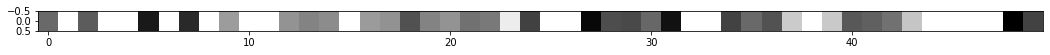

Displaying activation map 7
The activations for the layer is [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


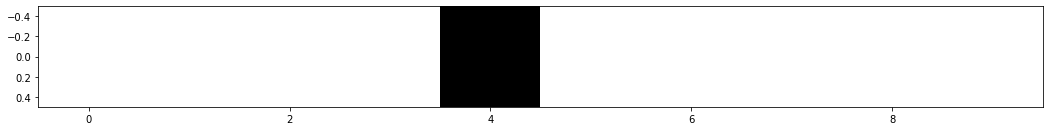

In [60]:
#cropping the upper half image 7

path=r'/gdrive/My Drive/datasetJPG/img_128.jpg'

test_crop_image(path,11,28,0,28)

(28, 28)
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]
(1, 28, 28, 1)
----- activations -----
(1, 26, 26, 32)
(1, 24, 24, 64)
(1, 12, 12, 64)
(1, 12, 12, 64)
(1, 9216)
(1, 50)
(1, 50)
(1, 10)
Displaying activation map 0


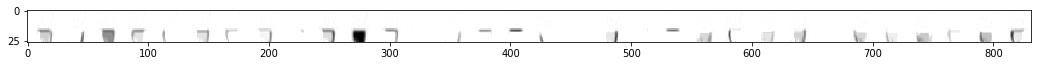

Displaying activation map 1


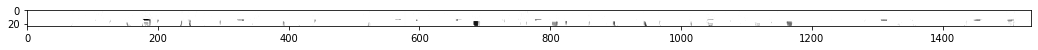

Displaying activation map 2


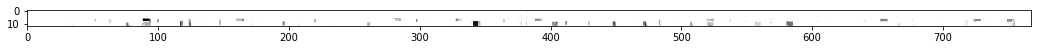

Displaying activation map 3


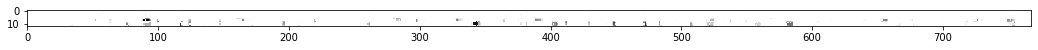

Displaying activation map 4
The activations for the layer is [0.        0.        0.        ... 0.        0.8021265 0.       ]


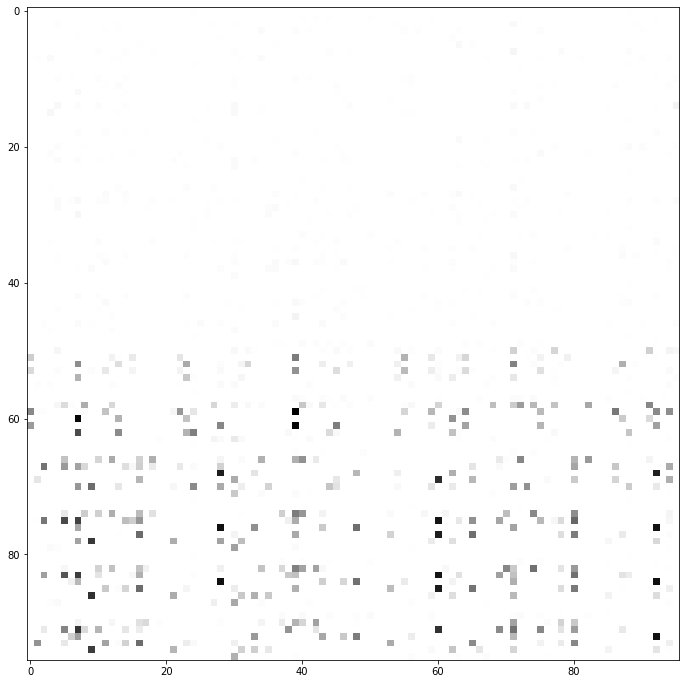

Displaying activation map 5
The activations for the layer is [   0.        858.6152    137.02403    16.80162   622.8073    883.3391
   46.119614  943.06415   224.36078   768.43097  1254.8899   1017.6675
 1020.64307   312.529     435.49475  1123.4678    490.2837   1177.2135
  645.6075    371.64203   554.67847   812.3728    794.9854    272.43762
  753.4971    928.8358      0.       1312.6454    986.6709    723.03125
 1002.4385   1165.8834      0.        961.53424   320.7077    549.4644
  275.52573   992.16425     0.        241.78809  1208.7228    823.7976
  775.29974   223.713     270.65982   713.01825   406.09125   163.1073
  461.34592   925.5736  ]


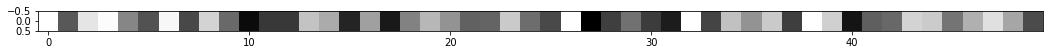

Displaying activation map 6
The activations for the layer is [   0.          0.        118.401596   34.958656  794.63446  1186.7303
   86.60722     0.        294.39005  1342.0135   1954.7355      0.
 1541.1932    462.1703    476.83496  1369.3699    651.0291   1693.5054
 1079.5629      0.        669.24756  1155.7266      0.          0.
 1256.7346   1358.4662      0.          0.          0.       1149.1372
    0.       1694.1569    136.92126  1322.1754    382.4581    783.4259
  519.3548   1491.6633      0.        433.0507   1746.4684      0.
 1386.8269      0.          0.        987.26385   631.08563     0.
  797.5203   1481.904   ]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).


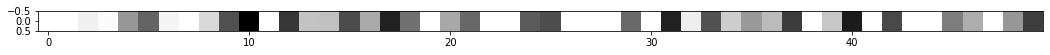

Displaying activation map 7
The activations for the layer is [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


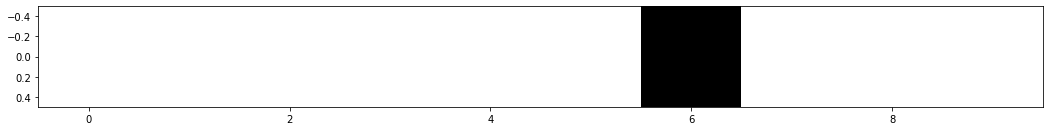

In [61]:
#cropping the image 7

path=r'/gdrive/My Drive/datasetJPG/img_128.jpg'

test_crop_image(path,0,11,0,28)

(28, 28)
[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
(1, 28, 28, 1)
----- activations -----
(1, 26, 26, 32)
(1, 24, 24, 64)
(1, 12, 12, 64)
(1, 12, 12, 64)
(1, 9216)
(1, 50)
(1, 50)
(1, 10)
Displaying activation map 0


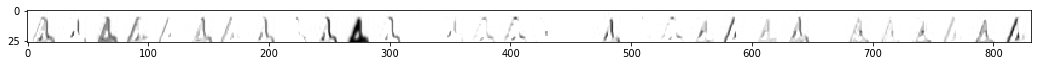

Displaying activation map 1


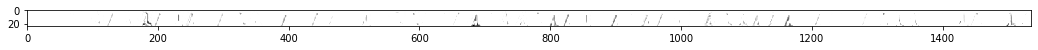

Displaying activation map 2


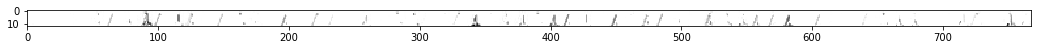

Displaying activation map 3


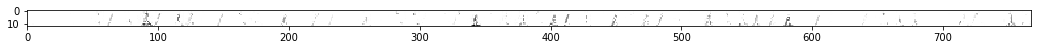

Displaying activation map 4
The activations for the layer is [  0.           0.           0.         ...   0.         137.07076
   0.96202034]


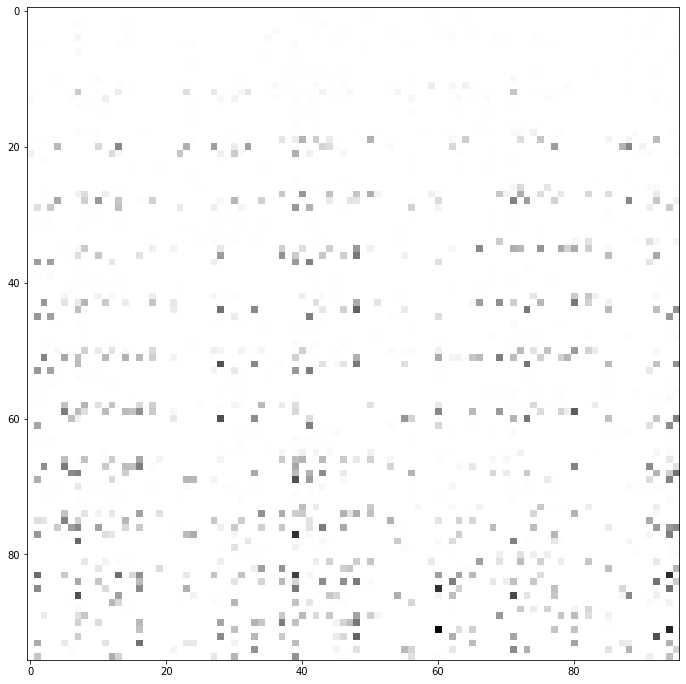

Displaying activation map 5
The activations for the layer is [ 816.41345  892.0585  1646.8508   194.86533 1997.059   1788.5604
  301.0822  1681.1254  1810.2924  1114.2552  1851.0292  1929.577
 1552.7936   709.5573  1185.0807  1450.7432   650.17975 1606.5636
 1782.4121  1237.9486   990.812   2050.9717  1062.7059    92.74543
 1769.1334  2432.967   1214.8284  2197.7793  1890.3885  1261.2451
 1609.3658  2297.5598  1131.5942  1713.9552  1366.9056  1323.1785
 1772.8389  1098.2596   340.12167  720.5948  1612.6938  1981.4249
 2087.6846   456.53635 1260.9764  1988.6108   874.58746 1494.1277
 1511.5553  1805.4315 ]


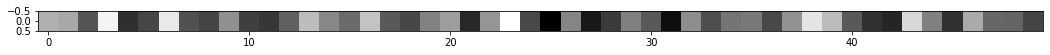

Displaying activation map 6
The activations for the layer is [   0.      1392.0349     0.         0.      2802.7163  3013.5022
  378.95517    0.      2686.2668     0.      3389.072   3221.4255
 2555.9778   874.8373  1825.4789  2374.7314     0.      2552.7153
 2394.247   1597.8634  1558.0273  3236.4258  1845.7913     0.
 2904.7883  3673.5442  1666.8889  3732.354   3100.0754     0.
 2505.8713  3553.7751  1555.7126     0.         0.         0.
 2918.7683  1964.0178   343.27127    0.      2811.5698  2865.8047
 3370.4023     0.      2034.5961  2929.008      0.      2338.4524
 2452.9087     0.     ]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).


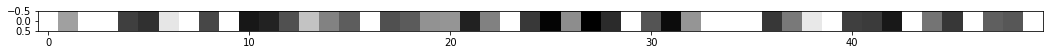

Displaying activation map 7
The activations for the layer is [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


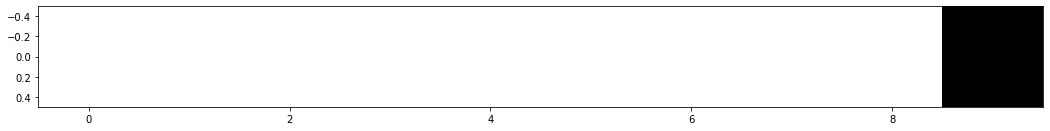

In [62]:
#cropping the image 4

path=r'/gdrive/My Drive/datasetJPG/img_113.jpg'

test_crop_image(path,0,18,0,28)